 **Importing dependencies**

In [4]:
#Utilities
import pandas as pd 
import numpy as np
import re
import string, time
from collections import defaultdict

#Visualization
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import plotly.graph_objects as go

#Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords.words('english')
from nltk.stem import PorterStemmer

import category_encoders as ce

**Importing dataset "Natural Language Processing with Disaster Tweets"**

In [1]:
#Description of the columns:

#id - a unique identifier for each tweet
#text - the text of the tweet
#location - the location the tweet was sent from (may be blank)
#keyword - a particular keyword from the tweet (may be blank)
#target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [13]:
#Importing dataset
dataset=pd.read_csv("https://raw.githubusercontent.com/kintis/VKR/main/train.csv")

pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

#Report the number of sentences
print('Number of sentences: {:,}\n'.format(dataset.shape[0]))

#Display 10 random rows from the dataset
dataset.sample(10, random_state=13)


Number of sentences: 7,613



id              keyword                        location                                                                                                                     text  target
3738   5313                 fire                             NaN   Morganite Gemstone White Fire Opal 925 Sterling Silver Ring Size 6 R1354 http://t.co/hHpVSAtQXN http://t.co/D12r8XpShy       0
4809   6845          loud%20bang                             NaN                                                     need to work in an office I can bang all my fav Future jams out loud       0
7600  10855                  NaN                             NaN                             Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1       1
1361   1963  burning%20buildings         Spying on your thoughts      @kshllcenterpri1 @Progress4Ohio burning down buildings what you mean like when you burnt down those black churches?       1
2773   3989          devastation                   Washington DC  Fascinating pics from inside North Korea. Not propaganda not devastation - just people living life. http://t.co/E2Db...       0
6268   8956                storm                             NaN                                The Secrets Of The Storm Vortex The Lightning Catcher Book Û_ : http://t.co/OIyWrzL79Z .       0
1063   1534                 bomb         Bolton & Tewkesbury, UK                                           Hiroshima prepares to remember the day the bomb dropped http://t.co/oJHCGZXLSt       1
4142   5889                 harm           Queensland, Australia                                                                      Vanderbilt: First Do No Harm http://t.co/cCdx7CGlQW       0
5312   7585             outbreak     Ile-Ife,Osun state, Nigeria  #News Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires'... ht...       1
2512   3608           desolation  [marvelÛ¢dragon ageÛ¢wicdiv]                  i decided to take a break from my emotional destruction to watch tangled then watch desolation of smaug       0

**Summarizing data**

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
dataset.shape

(7613, 5)

In [8]:
print(dataset.describe().T)
print('-----------------------------------------------------------------------------')
print(dataset.describe(include='object').T)

         count         mean         std  min     25%     50%     75%      max
id      7613.0  5441.934848  3137.11609  1.0  2734.0  5408.0  8146.0  10873.0
target  7613.0     0.429660     0.49506  0.0     0.0     0.0     1.0      1.0
-----------------------------------------------------------------------------
         count unique                                                                                                                      top freq
keyword   7552    221                                                                                                               fatalities   45
location  5080   3341                                                                                                                      USA  104
text      7613   7503  11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter ...   10


In [10]:
#Get the number of null values for each column of dataset
print(dataset.isnull().sum())
print('----------------')
print(100*dataset.isnull().sum()/len(dataset))

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
----------------
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


In [14]:
#Remove column "location" from dataset that has a high proportion of missing values (>33%), remove column "id" due to unnecessary
#Replace missing values at column "keyword"

dataset['keyword'].fillna('', inplace=True)
dataset['keyword'] = dataset['keyword'].map(lambda x: x.replace('%20', ' '))
dataset = dataset.drop(columns=['location', 'id'])
#Display 10 random rows from the dataset
dataset.sample(10, random_state=13)

keyword                                                                                                                     text  target
3738               fire   Morganite Gemstone White Fire Opal 925 Sterling Silver Ring Size 6 R1354 http://t.co/hHpVSAtQXN http://t.co/D12r8XpShy       0
4809          loud bang                                                     need to work in an office I can bang all my fav Future jams out loud       0
7600                                                Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1       1
1361  burning buildings      @kshllcenterpri1 @Progress4Ohio burning down buildings what you mean like when you burnt down those black churches?       1
2773        devastation  Fascinating pics from inside North Korea. Not propaganda not devastation - just people living life. http://t.co/E2Db...       0
6268              storm                                The Secrets Of The Storm Vortex The Lightning Catcher Book Û_ : http://t.co/OIyWrzL79Z .       0
1063               bomb                                           Hiroshima prepares to remember the day the bomb dropped http://t.co/oJHCGZXLSt       1
4142               harm                                                                      Vanderbilt: First Do No Harm http://t.co/cCdx7CGlQW       0
5312           outbreak  #News Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires'... ht...       1
2512         desolation                  i decided to take a break from my emotional destruction to watch tangled then watch desolation of smaug       0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


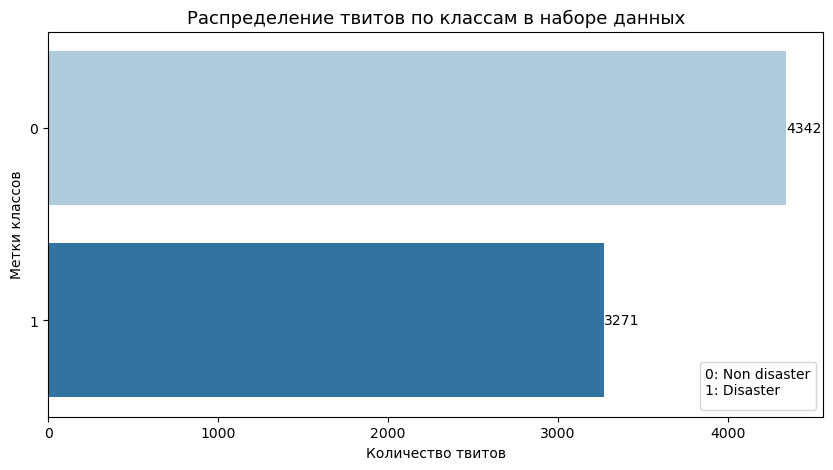

In [15]:
#Visualizing class distribution (1 is real disaster, 0 isn't real disaster)
plt.figure(figsize=(10,5))
ax = sns.countplot(data=dataset, y='target', palette='Paired')
ax.set_title('Распределение твитов по классам в наборе данных', fontsize=13)
ax.set_xlabel('Количество твитов')
ax.set_ylabel('Метки классов')
for label in ax.containers:
    ax.bar_label(label)
plt.legend(loc='lower right', title="0: Non disaster\n1: Disaster", ncol = 2)
plt.show()

In [16]:
#Visualizing class distribution (1 is real disaster, 0 isn't real disaster)
dataset_0 = dataset[dataset['target'] == 0] # Non disaster
dataset_1 = dataset[dataset['target'] == 1] # Disaster

values = np.array([len(dataset_0), len(dataset_1)])
labels = ['Non disaster', 'Disaster']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.3, textinfo = 'percent', title = " ")])
fig.update_traces(marker=dict(colors=['green', 'red']))

text_title = "Распределение твитов по классам в наборе данных"
fig.update_layout(height = 500, width = 750, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
fig.show()

In [17]:
temp = dataset.groupby('target').count()['text'].reset_index()
temp['label'] = temp['target'].apply(lambda x : 'Disaster Tweet' if x==1 else 'Non Disaster Tweet')
temp

target  text               label
0       0  4342  Non Disaster Tweet
1       1  3271      Disaster Tweet

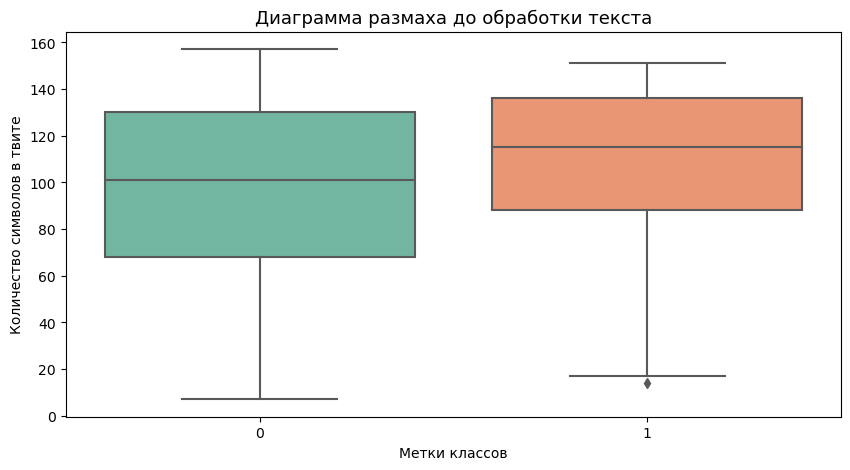

In [18]:
#Visualizing tweet length by characaters BEFORE preprocessing
plt.figure(figsize=(10,5))
ds_sent = dataset['text'].str.len()
sns.boxplot(x="target", y=ds_sent, data=dataset, palette="Set2")
plt.xlabel("Метки классов")
plt.ylabel("Количество символов в твите")
plt.title('Диаграмма размаха до обработки текста', fontsize=13)
plt.show()

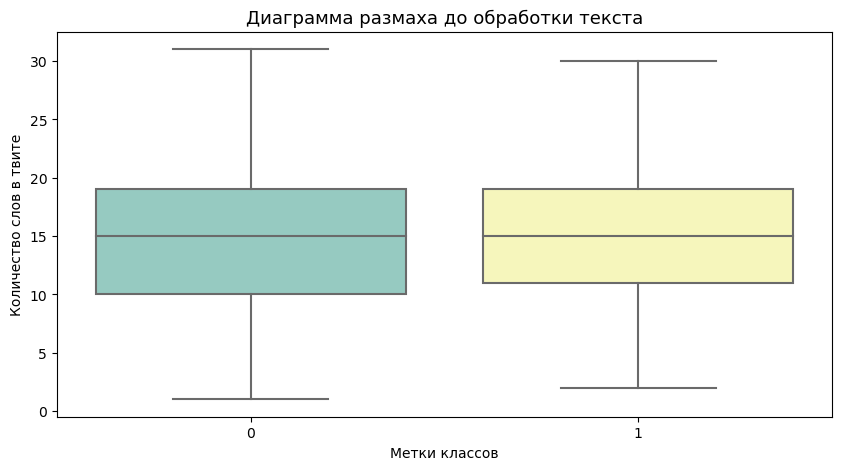

In [19]:
#Visualizing tweet length by words BEFORE preprocessing
plt.figure(figsize=(10,5))
ds_sent = dataset['text'].str.split().map(lambda x : len(x))
sns.boxplot(x="target", y=ds_sent, data=dataset, palette="Set3")
plt.xlabel("Метки классов")
plt.ylabel("Количество слов в твите")
plt.title('Диаграмма размаха до обработки текста', fontsize=13)
plt.show()


Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are:

1. word_count number of words in text<br>
2. unique_word_count number of unique words in text<br>
3. stop_word_count number of stop words in text<br>
4. url_count number of urls in text<br>
5. mean_word_length average character count in words<br>
6. char_count number of characters in text<br>
7. punctuation_count number of punctuations in text<br>
8. hashtag_count number of hashtags (#) in text<br>
9. mention_count number of mentions (@) in text<br>

In [20]:
#Word_count
dataset['word_count'] = dataset['text'].apply(lambda x: len(str(x).split()))

#Unique_word_count
dataset['unique_word_count'] = dataset['text'].apply(lambda x: len(set(str(x).split())))

#Mean_word_length
dataset['mean_word_length'] = dataset['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Char_count
dataset['char_count'] = dataset['text'].apply(lambda x: len(str(x)))

#Stop_word_count
dataset['stop_word_count'] = dataset['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

#Url_count
dataset['url_count'] = dataset['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

#Punctuation_count
dataset['punctuation_count'] = dataset['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#Hashtag_count
dataset['hashtag_count'] = dataset['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

#Mention_count
dataset['mention_count'] = dataset['text'].apply(lambda x: len([c for c in str(x) if c == '@']))


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_30684\611803762.py:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_30684\611803762.py:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_30684\611803762.py:11: UserWarning:



`distplot`

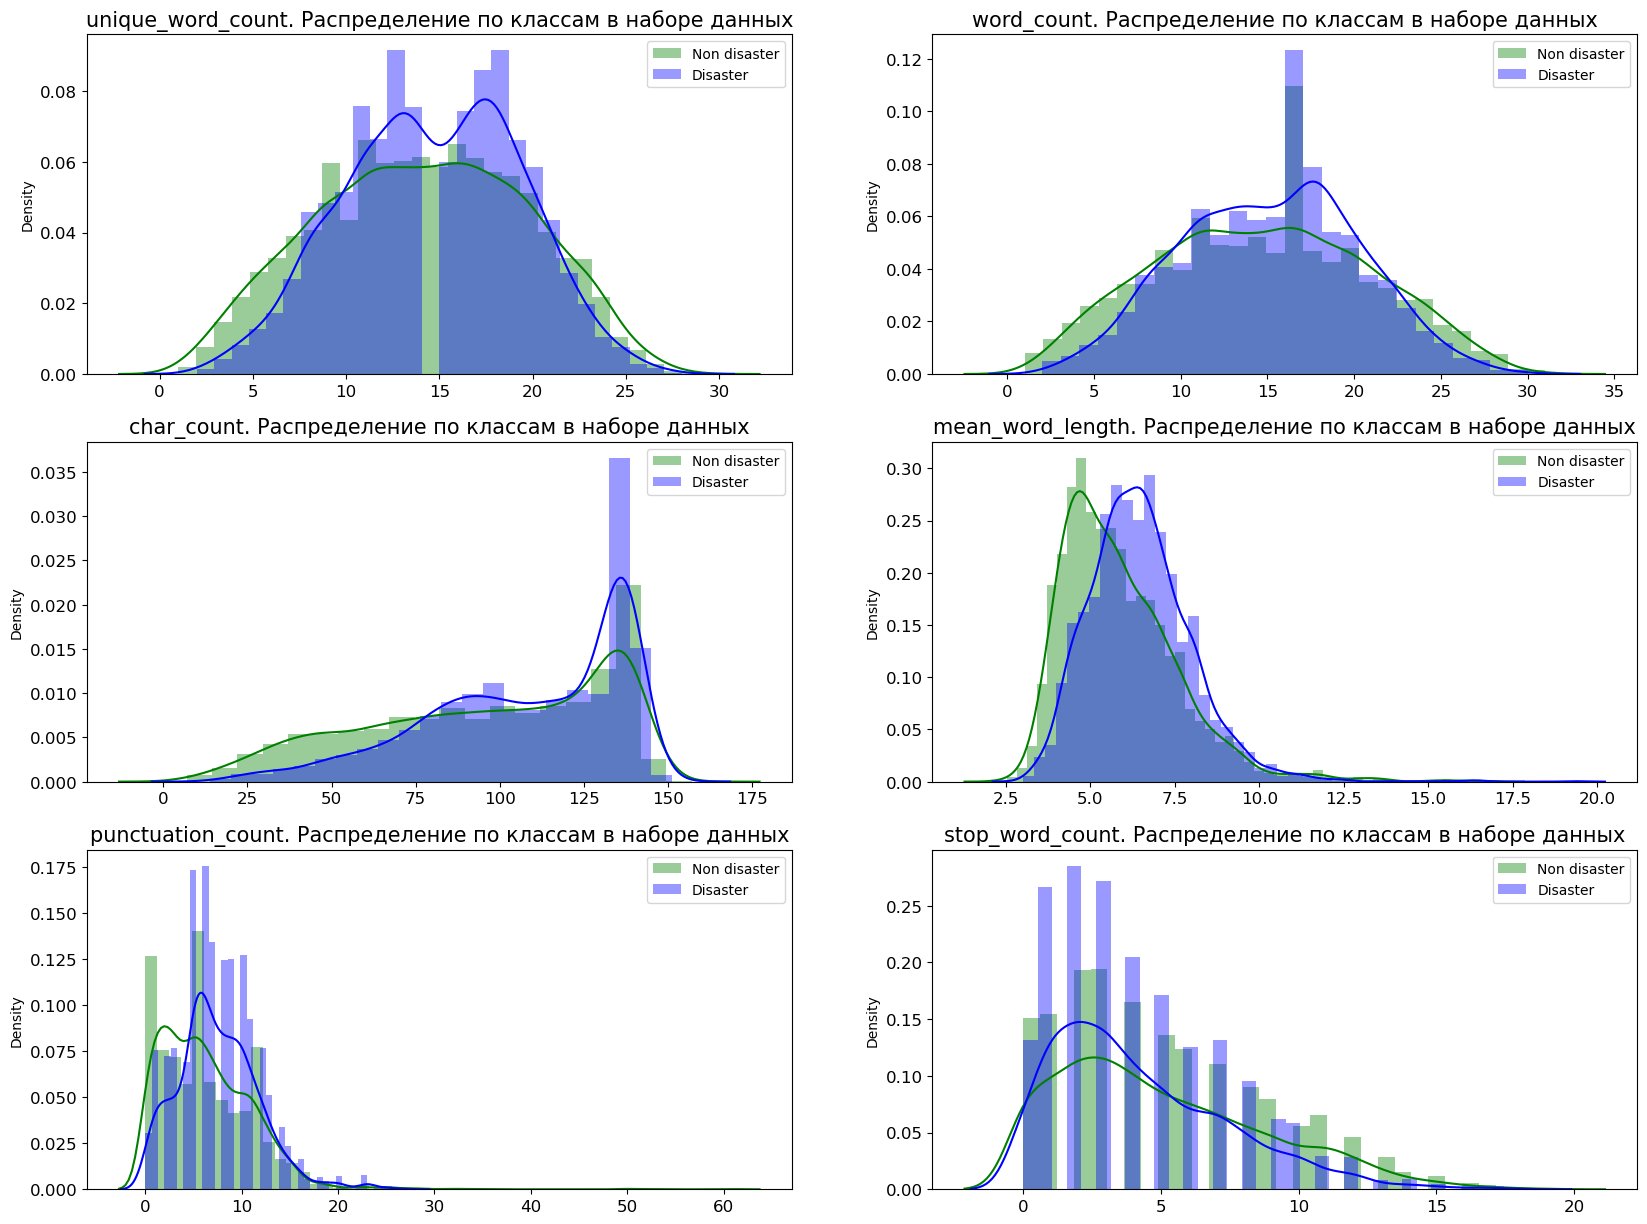

In [21]:
METAFEATURES = ['word_count', 'unique_word_count', 'mean_word_length', 'char_count', 'stop_word_count',
                'punctuation_count']
DISASTER_TWEETS = dataset['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 15), dpi=100)

ypos = 0
xpos = 0
for i, feature in enumerate(METAFEATURES):
    xpos = int(not xpos)
    sns.distplot(dataset.loc[~DISASTER_TWEETS][feature], label='Non disaster', ax=axes[ypos][xpos], color='green')
    sns.distplot(dataset.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[ypos][xpos], color='blue')

    axes[ypos][xpos].set_xlabel('')

    axes[ypos][xpos].tick_params(axis='x', labelsize=12)
    axes[ypos][xpos].tick_params(axis='y', labelsize=12)
    axes[ypos][xpos].legend()
    axes[ypos][xpos].set_title(f'{feature}. Распределение по классам в наборе данных', fontsize=15)
    
    if i % 2 != 0:
        ypos += 1

plt.show()


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_30684\663153780.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_30684\663153780.py:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_30684\663153780.py:7: UserWarning:



`distplot` is

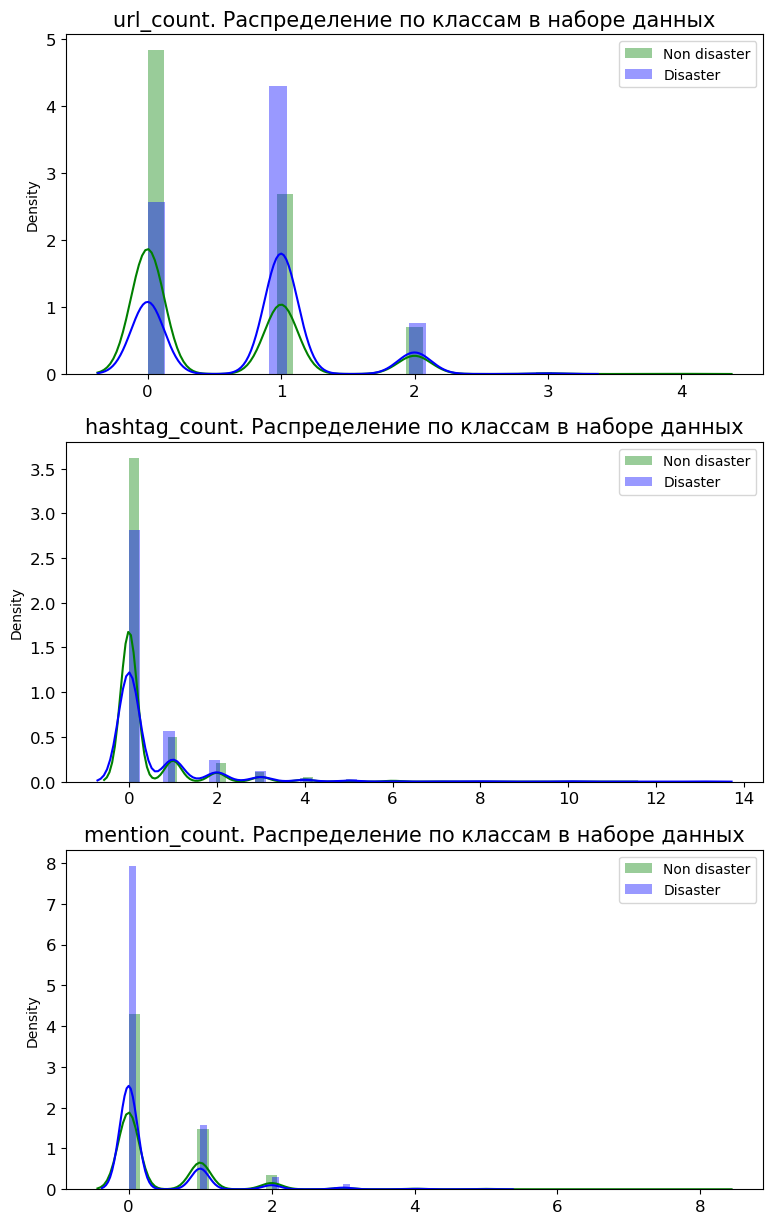

In [22]:
METAFEATURES = ['url_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = dataset['target'] == 1

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(9, 15), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(dataset.loc[~DISASTER_TWEETS][feature], label='Non disaster', ax=axes[i], color='green')
    sns.distplot(dataset.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i], color='blue')


    
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()
    axes[i].set_title(f'{feature}. Распределение по классам в наборе данных', fontsize=15)


plt.show()

All of the meta features have information about target as well, but some of them are not good enough such as url_count, hashtag_count and mention_count.

On the other hand, word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count have very different distributions for disaster and non-disaster tweets. Those features might be useful in models.

In [23]:
dataset = dataset.drop(columns=['url_count', 'hashtag_count', 'mention_count'])



In [24]:
dataset

keyword                                                                                                                     text  target  word_count  unique_word_count  mean_word_length  char_count  stop_word_count  punctuation_count
0                                                               Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all       1          13                 13          4.384615          69                6                  1
1                                                                                              Forest fire near La Ronge Sask. Canada       1           7                  7          4.571429          38                0                  1
2             All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...       1          22                 20          5.090909         133               11                  3
3                                                                   13,000 people receive #wildfires evacuation orders in California        1           8                  8          7.125000          65                1                  2
4                                            Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school        1          16                 15          4.500000          88                7                  2
...      ...                                                                                                                      ...     ...         ...                ...               ...         ...              ...                ...
7608                                              Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5       1          11                 11          6.636364          83                2                  5
7609          @aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very t...       1          20                 17          5.300000         125                9                  5
7610                                                                M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ       1           8                  8          7.250000          65                1                 11
7611          Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life ...       1          19                 19          6.263158         137                5                  5
7612                                   The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d       1          13                 13          6.307692          94                3                  7

[7613 rows x 9 columns]

In [25]:
#'8 features' columns will be added to our dataset, these features will help us to train our model and achieve good results
#'word_count', 'unique_word_count', 'mean_word_length', 'char_count', 'stop_word_count', 'punctuation_count', 'caps_count', 'caps_ratio'
def create_stat(df):
    # Word count
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    # Unique word count
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
    # Mean word length
    df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    # Char count
    df['char_count'] = df['text'].apply(lambda x: len(str(x)))
    # Stopword count
    df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of uppercase letters
    df['caps_count'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['char_count']
    return df

dataset_feat = create_stat(dataset)


print(dataset_feat.shape)
dataset_feat = dataset_feat[['keyword', 'text', 'word_count', 'unique_word_count', 'mean_word_length', 'char_count', 'stop_word_count', 'punctuation_count', 'caps_count', 'caps_ratio', 'target']]
dataset_feat.head()

(7613, 11)


keyword                                                                                                                     text  word_count  unique_word_count  mean_word_length  char_count  stop_word_count  punctuation_count  caps_count  caps_ratio  target
0                                                            Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all          13                 13          4.384615          69                6                  1          10    0.144928       1
1                                                                                           Forest fire near La Ronge Sask. Canada           7                  7          4.571429          38                0                  1           5    0.131579       1
2          All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...          22                 20          5.090909         133               11                  3           2    0.015038       1
3                                                                13,000 people receive #wildfires evacuation orders in California            8                  8          7.125000          65                1                  2           1    0.015385       1
4                                         Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school           16                 15          4.500000          88                7                  2           3    0.034091       1

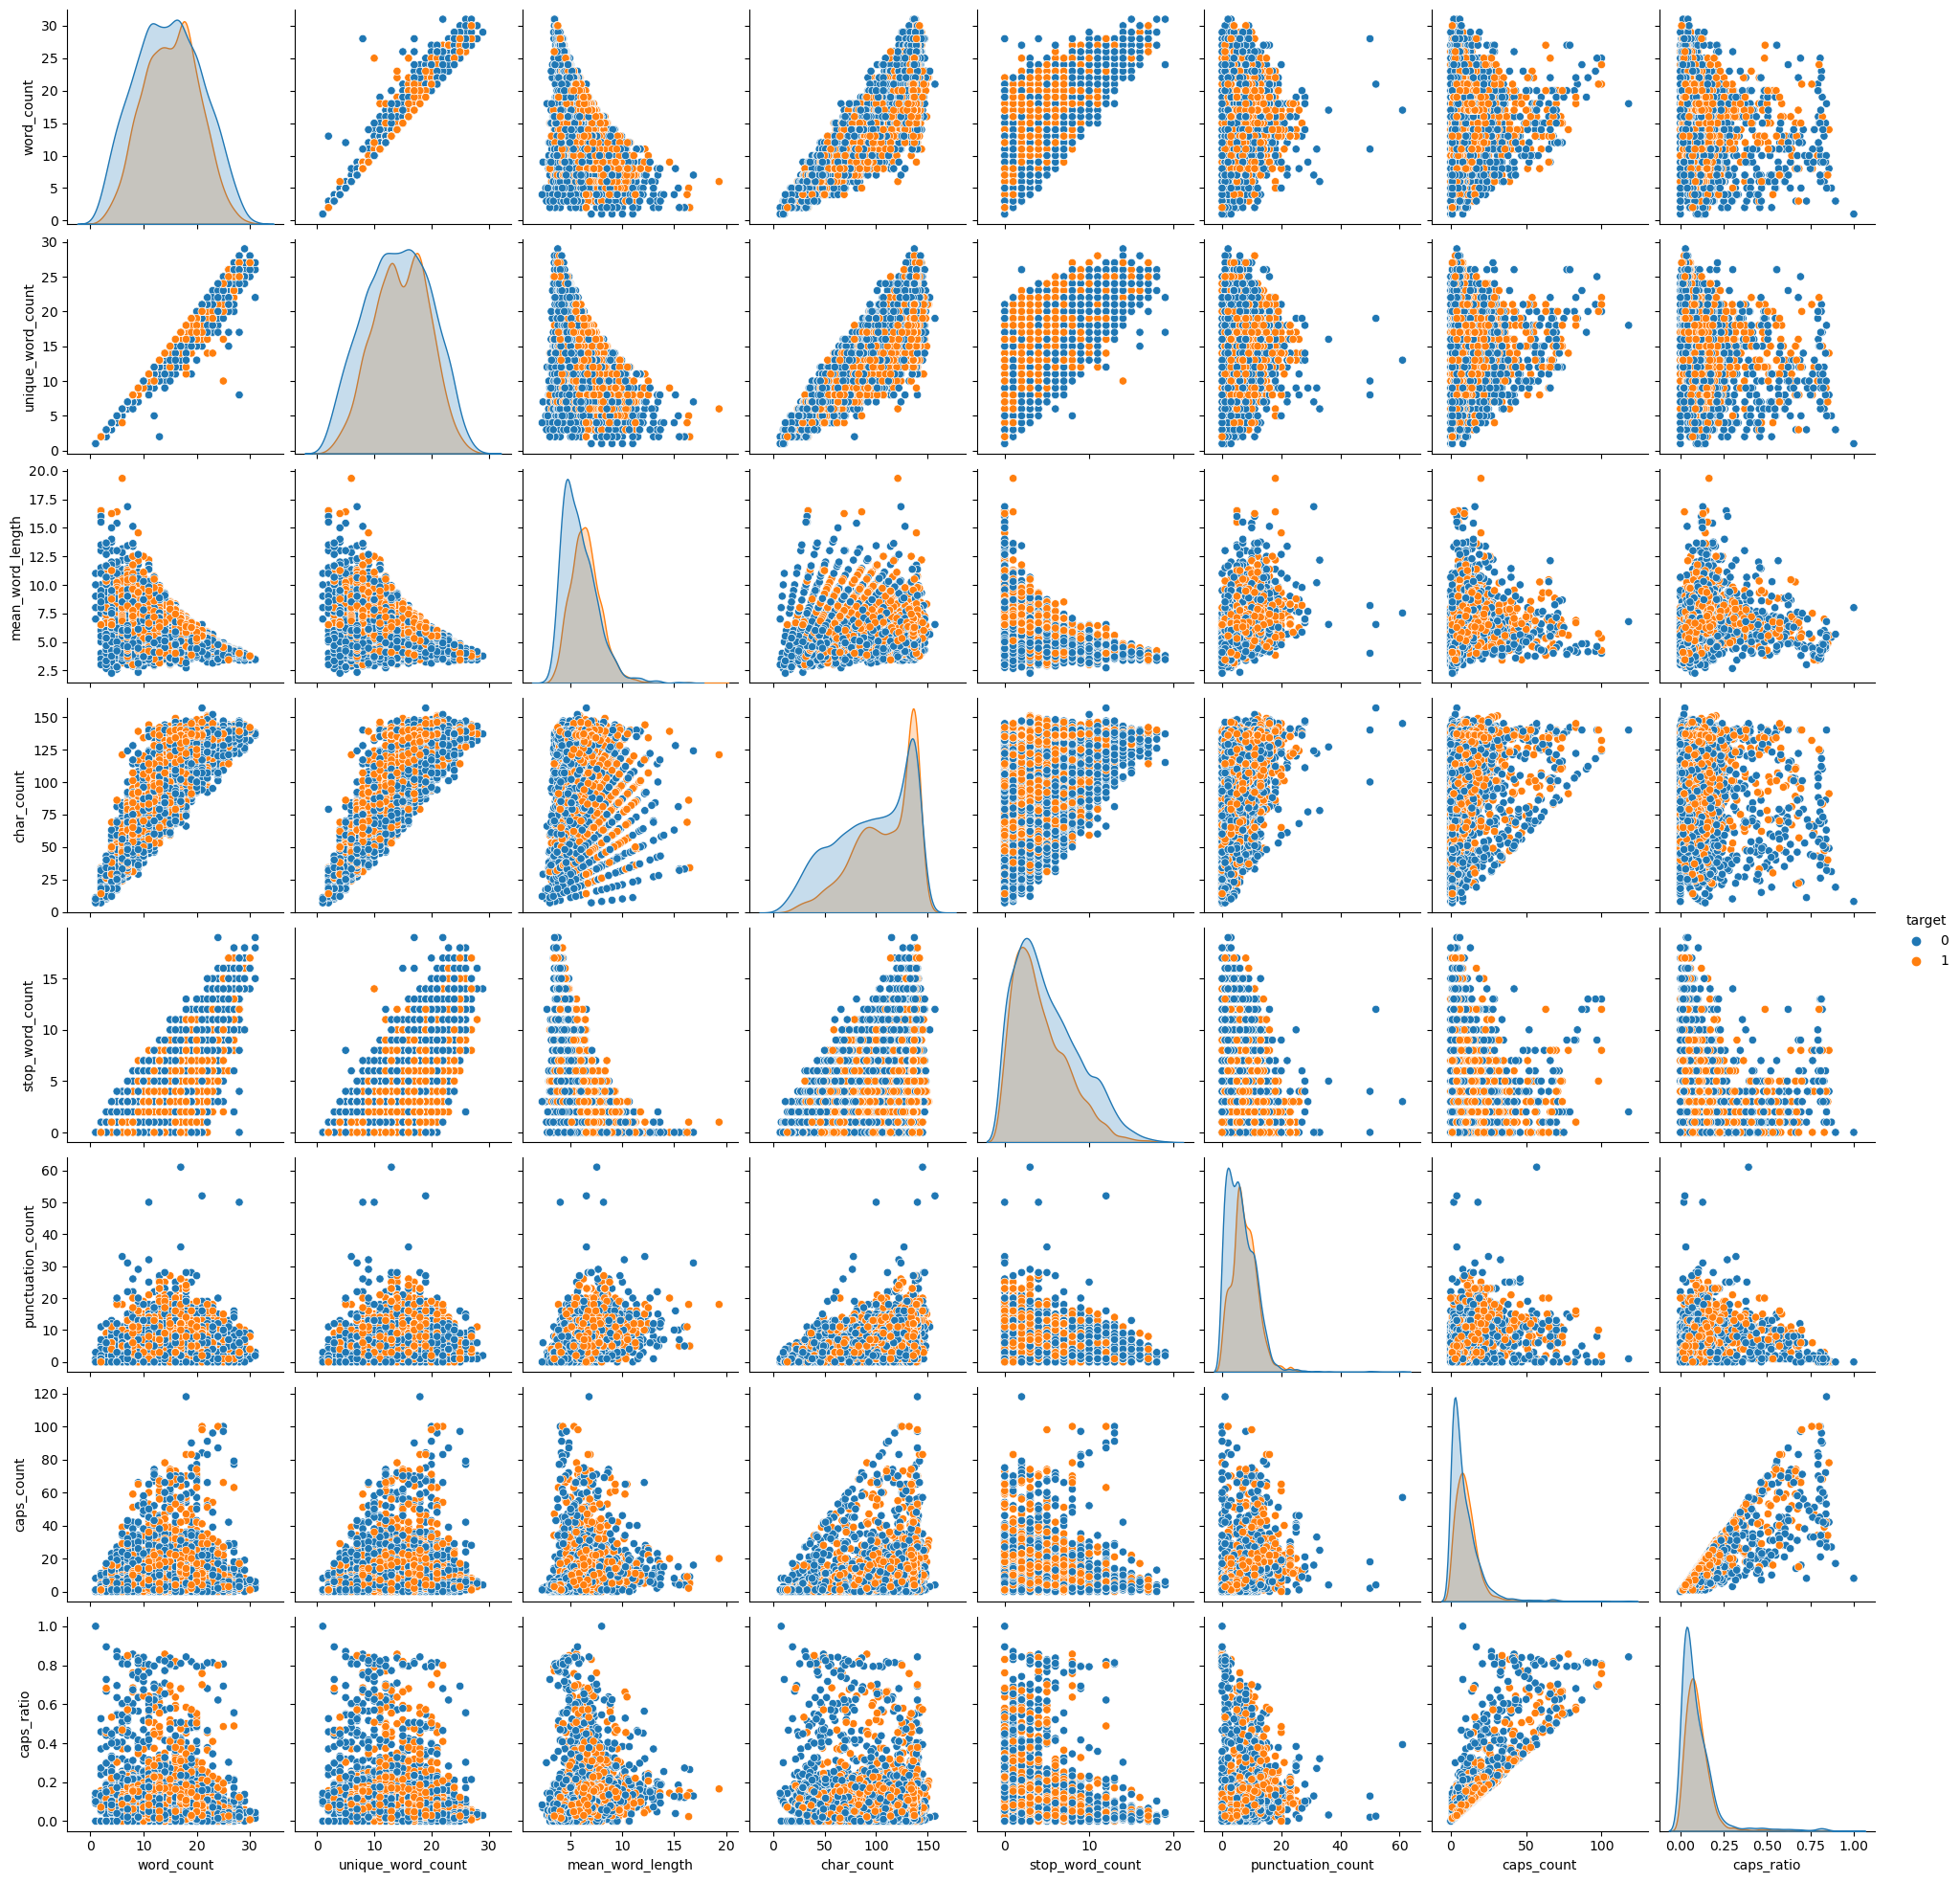

In [26]:
sns.pairplot(dataset_feat, hue='target')
plt.show()

In [27]:
#Correlation coefficients between the target variable and our set of features
dataset_feat.corr()['target'].drop('target').sort_values()

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_30684\1232225031.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



stop_word_count     -0.111250
caps_ratio           0.018154
word_count           0.039966
unique_word_count    0.053326
caps_count           0.078806
punctuation_count    0.132606
mean_word_length     0.176855
char_count           0.181817
Name: target, dtype: float64

**Data preprocessing**

In [29]:
#A quick glance over the existing data
dataset_feat['text'][30:40]

30                                                                                                                   The end!
31                                                                    @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
32                                                        We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw
33                                         #AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi
34                                                                                         Crying out for more! Set me ablaze
35                                               On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N
36    @PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this s...
37                                                                    INEC Office in Abia Set Ablaze - http://t.co/3Im

In [31]:
#Applying a text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('û', '', text)

    return text

# Applying the cleaning function to dataset
dataset_feat['text'] = dataset_feat['text'].apply(lambda x: clean_text(x))


# Let's take a look at the updated text
dataset_feat['text'][30:40]

30                                                                                                                   the end
31                                                                                          bbcmtd wholesale markets ablaze 
32                                                                                we always try to bring the heavy metal rt 
33                                                                  africanbaze breaking newsnigeria flag set ablaze in aba 
34                                                                                         crying out for more set me ablaze
35                                                                    on plus side look at the sky last night it was ablaze 
36    phdsquares mufc theyve built so much hype around new acquisitions but i doubt they will set the epl ablaze this season
37                                                                                          inec office in abia set ablaze  


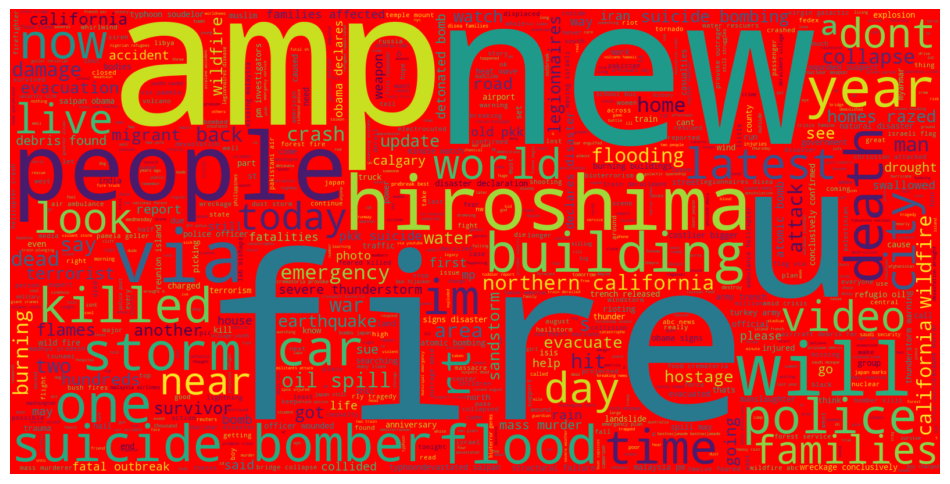

In [32]:
#Disaster tweets wordcloud 
disaster_tweets = dataset_feat[dataset_feat.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, max_words = 800, background_color='red').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

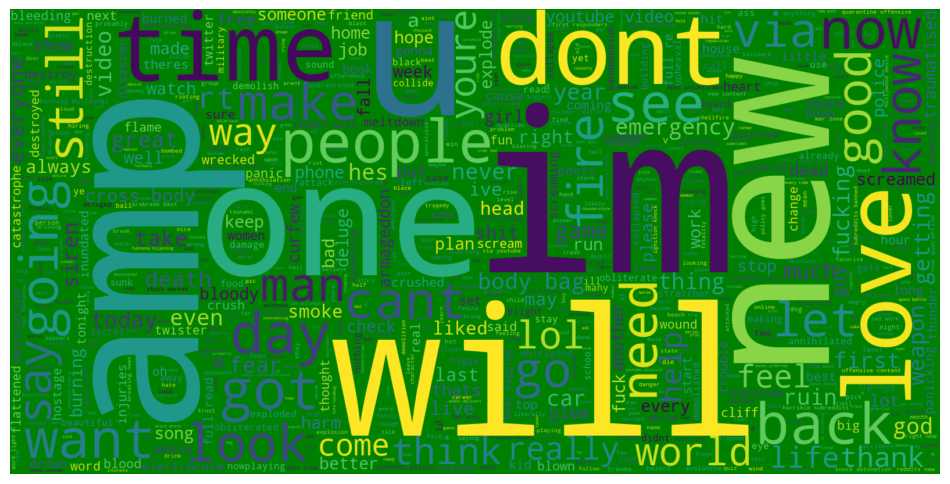

In [33]:
#Non disaster tweets wordcloud 
no_disaster_tweets = dataset_feat[dataset_feat.target == 0]
disaster_string = []
for t in no_disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, max_words = 800, background_color='green').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

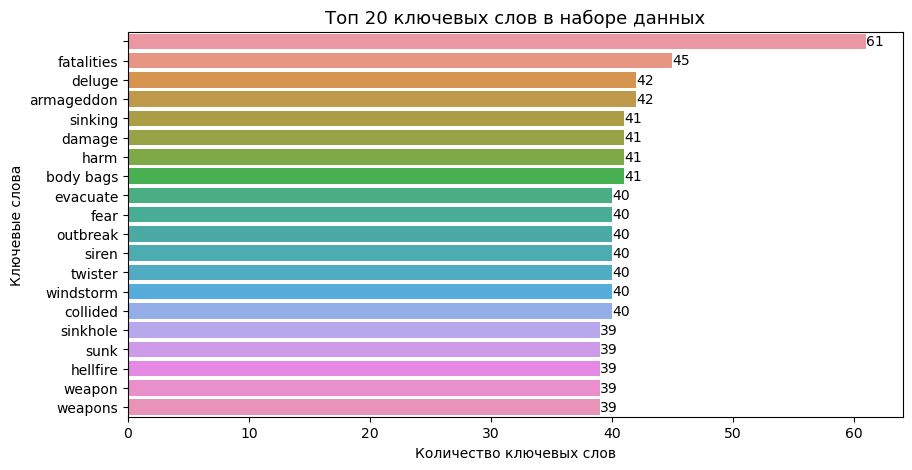

In [34]:
#Most common keywords
plt.figure(figsize=(10,5))
ax = sns.countplot(y=dataset_feat.keyword, order = dataset_feat.keyword.value_counts().iloc[:20].index)
ax.set_title('Топ 20 ключевых слов в наборе данных', fontsize=13)
ax.set_xlabel('Количество ключевых слов')
ax.set_ylabel('Ключевые слова')
for label in ax.containers:
    ax.bar_label(label)

plt.show()

In [35]:
#Explore the column keyword
keyword_stats = dataset_feat.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Disaster Probability'})
keywords_disaster = keyword_stats.loc[keyword_stats['Disaster Probability']==1]
keywords_no_disaster  = keyword_stats.loc[keyword_stats['Disaster Probability']==0]
keyword_stats.sort_values('Disaster Probability', ascending=False).head(10)

Count  Disaster Probability
keyword                                     
wreckage            39              1.000000
debris              37              1.000000
derailment          39              1.000000
outbreak            40              0.975000
oil spill           38              0.973684
typhoon             38              0.973684
suicide bombing     33              0.969697
suicide bomber      31              0.967742
bombing             29              0.931034
suicide bomb        35              0.914286

In [36]:
# heck number of unique keywords
print (f"Unique keywords for dataset -> {dataset_feat.keyword.nunique()}" )

Unique keywords for dataset -> 222


**N-grams**

In [37]:
from wordcloud import STOPWORDS

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 20

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in dataset_feat[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in dataset_feat[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in dataset_feat[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in dataset_feat[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in dataset_feat[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in dataset_feat[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

**Unigrams**<br>
Most common unigrams exist in both classes are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about target.<br>

Most common unigrams in disaster tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.<br>

Most common unigrams in non-disaster tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.<br>

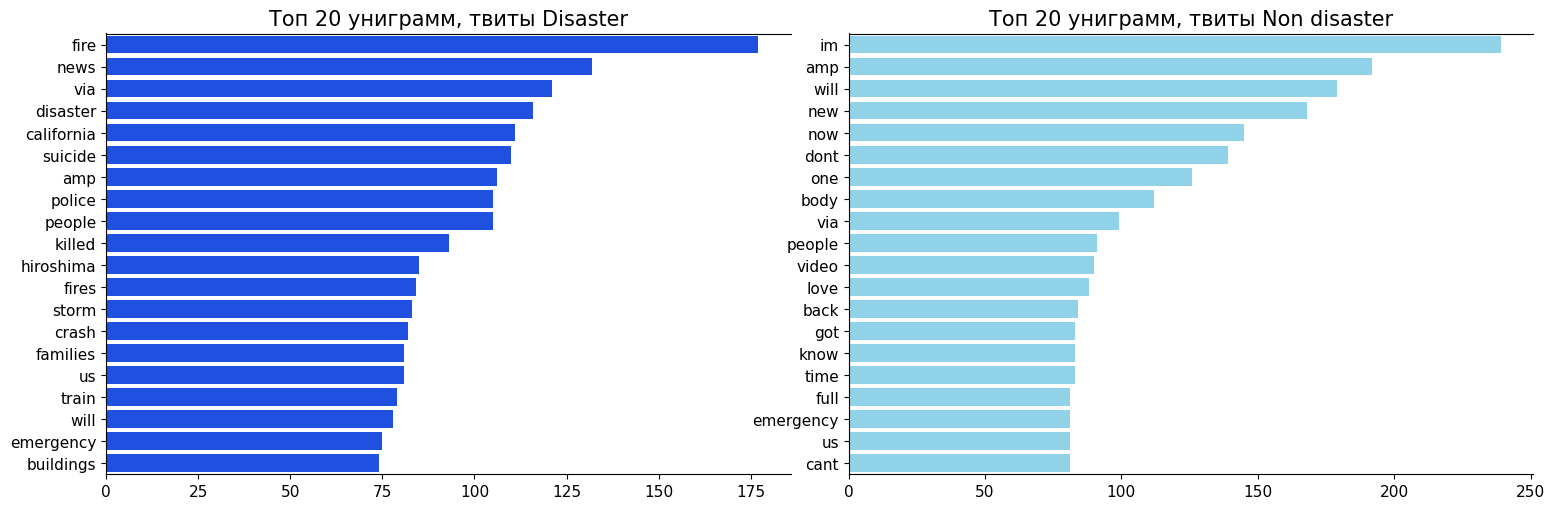

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='#0040FF')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='#81DAF5')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=11)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Топ {N} униграмм, твиты Disaster', fontsize=15)
axes[1].set_title(f'Топ {N} униграмм, твиты Non disaster', fontsize=15)

plt.show()



**Bigrams**<br>
There are no common bigrams exist in both classes because the context is clearer.<br>

Most common bigrams in disaster tweets are giving more information about the disasters than unigrams.<br>

Most common bigrams in non-disaster tweets are mostly about reddit or youtube.

c:\Users\Iuliia\miniconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 137 (\x89) missing from current font.



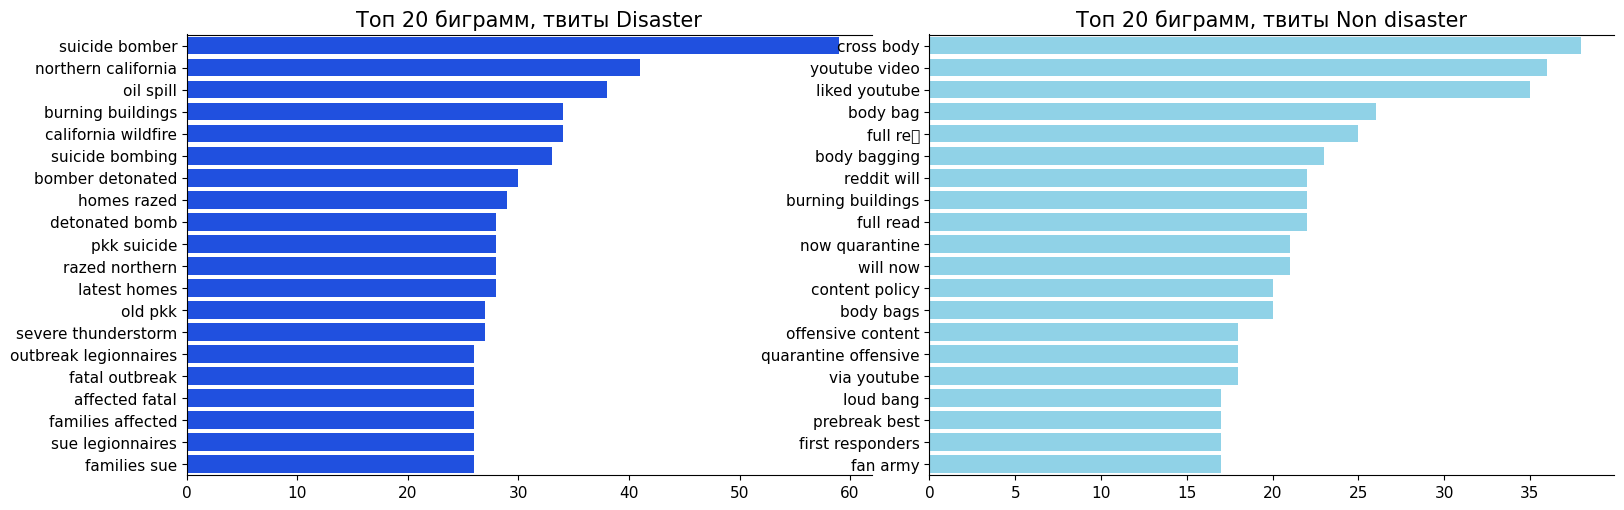

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='#0040FF')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='#81DAF5')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=11)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Топ {N} биграмм, твиты Disaster', fontsize=15)
axes[1].set_title(f'Топ {N} биграмм, твиты Non disaster', fontsize=15)

plt.show()

**Trigrams**<br>
There are no common trigrams exist in both classes because the context is clearer.<br>

Most common trigrams in disaster tweets are very similar to bigrams. They give lots of information about disasters, but they may not provide any additional information along with bigrams.<br>

Most common trigrams in non-disaster tweets are also very similar to bigrams.

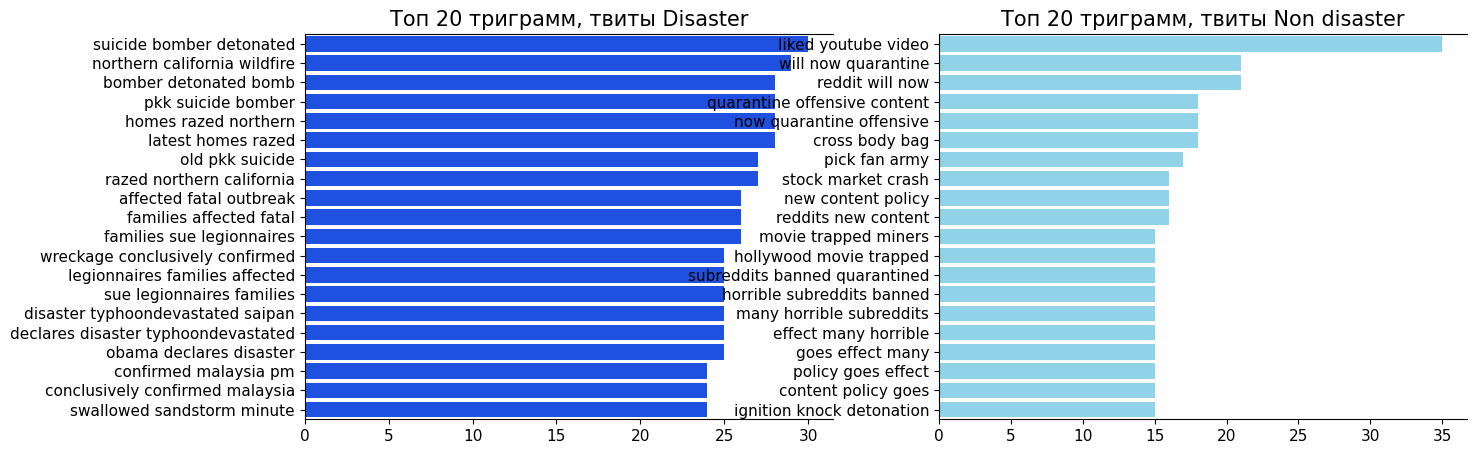

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='#0040FF')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='#81DAF5')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=11)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Топ {N} триграмм, твиты Disaster', fontsize=15)
axes[1].set_title(f'Топ {N} триграмм, твиты Non disaster', fontsize=15)

plt.show()

After creating bar plots of the most frequent words in tweets related to disasters and non-disasters, we can observe that the most commonly occurring words in actual disasters reflect an unpleasant and negative situation, while the words in non-disaster tweets tend to be more general and reflect everyday life.

This leads us to conclude that keywords play an important role in the detection of disaster-related tweets.

**Tokenization**<br>
Tokenization is a process that splits an input sequence into so-called tokens where the tokens can be a word, sentence, paragraph etc.

In [51]:
#Tokenizing dataset
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
dataset_feat['text'] = dataset_feat['text'].apply(lambda x: tokenizer.tokenize(x))

dataset_feat['text'][30:40]

30                                                                                                                 [the, end]
31                                                                                       [bbcmtd, wholesale, markets, ablaze]
32                                                                        [we, always, try, to, bring, the, heavy, metal, rt]
33                                                           [africanbaze, breaking, newsnigeria, flag, set, ablaze, in, aba]
34                                                                                  [crying, out, for, more, set, me, ablaze]
35                                                         [on, plus, side, look, at, the, sky, last, night, it, was, ablaze]
36    [phdsquares, mufc, theyve, built, so, much, hype, around, new, acquisitions, but, i, doubt, they, will, set, the, ep...
37                                                                                      [inec, office, in, abia, set, 

**Stopwords Removal**<br>
Now, let's get rid of the stopwords i.e words which occur very frequently but have no possible value like a, an, the, are etc.

In [52]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words

dataset_feat['text'] = dataset_feat['text'].apply(lambda x : remove_stopwords(x))

dataset_feat['text'][30:40]

30                                                                                                                    [end]
31                                                                                     [bbcmtd, wholesale, markets, ablaze]
32                                                                                   [always, try, bring, heavy, metal, rt]
33                                                             [africanbaze, breaking, newsnigeria, flag, set, ablaze, aba]
34                                                                                                    [crying, set, ablaze]
35                                                                             [plus, side, look, sky, last, night, ablaze]
36                [phdsquares, mufc, theyve, built, much, hype, around, new, acquisitions, doubt, set, epl, ablaze, season]
37                                                                                        [inec, office, abia, set, ablaze]
38    [b

In [53]:
#After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

dataset_feat['text'] = dataset_feat['text'].apply(lambda x : combine_text(x))

dataset_feat[30:40]


keyword                                                                                                  text  word_count  unique_word_count  mean_word_length  char_count  stop_word_count  punctuation_count  caps_count  caps_ratio  target
30                                                                                                           end           2                  2          3.500000           8                1                  1           1    0.125000       0
31  ablaze                                                                       bbcmtd wholesale markets ablaze           5                  5         10.200000          55                0                  6          10    0.181818       1
32  ablaze                                                                       always try bring heavy metal rt          10                 10          5.800000          67                3                  8           5    0.074627       0
33  ablaze                                                  africanbaze breaking newsnigeria flag set ablaze aba           9                  9          8.222222          82                1                  9          17    0.207317       1
34  ablaze                                                                                     crying set ablaze           7                  7          4.000000          34                3                  1           2    0.058824       0
35  ablaze                                                                  plus side look sky last night ablaze          13                 13          4.923077          76                5                  5          35    0.460526       0
36  ablaze            phdsquares mufc theyve built much hype around new acquisitions doubt set epl ablaze season          21                 21          4.857143         122                7                  4           7    0.057377       0
37  ablaze                                                                           inec office abia set ablaze           8                  8          6.000000          55                1                  6          10    0.181818       1
38  ablaze  barbados bridgetown jamaica ò two cars set ablaze santa cruz ó head st elizabeth police superintende          19                 19          6.368421         140                2                 10          33    0.235714       1
39  ablaze                                                                                           ablaze lord           5                  5          3.600000          22                2                  1           3    0.136364       0

**Splitting the Data**<br>
The Preprocessed Data is divided into 2 sets of data:<br>

Training Data: The dataset upon which the model would be trained on. Contains 80% data.<br>
Test Data: The dataset upon which the model would be tested against. Contains20% data.<br>

In [ ]:
dataset_feat.columns

In [55]:
TRAIN_SIZE=0.8
# Splits Dataset into Training and Testing set
train_data, test_data = train_test_split(dataset_feat, test_size=1-TRAIN_SIZE,
                                         random_state=13) 
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

print(train_data.shape)
print(test_data.shape)

Train Data size: 6090
Test Data size 1523
(6090, 11)
(1523, 11)


In [56]:
#Comparison of sizes of training set, and test set
values = np.array([len(train_data), len(test_data)])
labels = ['Train set', 'Test set']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Распределение на обучающую и тестовую выборку"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
fig.show()

**Encoding and Vectorization**

Encoding and vectorizers are important techniques for transforming text data into a numerical format that can be used as input to machine learning models.<br>

In the context of the tweet disaster dataset, encoding and vectorization techniques can help to extract useful features from the cleaned text data and prepare it for modeling.<br>

In this code bellow, we are importing the category_encoders library to perform target encoding on the keyword column. Target encoding is a technique used to transform categorical data into numerical data.<br>

First, we specify the keyword column as the feature to encode. Then we create a target encoder object and fit it on the training set. Next, we apply the encoding to both the training and test sets and add suffix "_target" to the new columns. Finally, we display the first 3 rows of the training set after adding the encoded keyword_target column.<br>

In [57]:

#Target encoding
#Specify the column to encode
features = ['keyword']

#Create a target encoder object
encoder = ce.TargetEncoder(cols=features)

#Fit the encoder on the training set
encoder.fit(train_data[features], train_data['target'])

#Apply the encoding to both the train and test sets and add suffix "_target" to the new columns'
train_data = train_data.join(encoder.transform(train_data[features]).add_suffix('_target'))
test_data = test_data.join(encoder.transform(test_data[features]).add_suffix('_target'))
train_data.head(3)

print(train_data.shape)
print(test_data.shape)

(6090, 12)
(1523, 12)


In [58]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6090 entries, 5753 to 338
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   keyword            6090 non-null   object 
 1   text               6090 non-null   object 
 2   word_count         6090 non-null   int64  
 3   unique_word_count  6090 non-null   int64  
 4   mean_word_length   6090 non-null   float64
 5   char_count         6090 non-null   int64  
 6   stop_word_count    6090 non-null   int64  
 7   punctuation_count  6090 non-null   int64  
 8   caps_count         6090 non-null   int64  
 9   caps_ratio         6090 non-null   float64
 10  target             6090 non-null   int64  
 11  keyword_target     6090 non-null   float64
dtypes: float64(3), int64(7), object(2)
memory usage: 747.6+ KB


In [59]:

print(train_data.isnull().sum(axis = 1))

5753    0
169     0
2101    0
6644    0
3989    0
       ..
866     0
2790    0
74      0
6320    0
338     0
Length: 6090, dtype: int64


**Countvectorizer**

In [60]:
#ngram_range=(1, 2)
count_vectorizer_12 = CountVectorizer(ngram_range=(1, 2), min_df=5, stop_words='english', analyzer='word', max_features=7000)

%time train_vectors_12 = count_vectorizer_12.fit_transform((train_data['text'].values.astype(str)))
test_vectors_12 = count_vectorizer_12.transform((test_data["text"]))

#Create dataframes to store the vectorized data
X_train_vectors_12 = pd.DataFrame(train_vectors_12.toarray(), columns=count_vectorizer_12.get_feature_names_out())
X_test_vectors_12 = pd.DataFrame(test_vectors_12.toarray(), columns=count_vectorizer_12.get_feature_names_out())

print(X_train_vectors_12.shape)
print(X_test_vectors_12.shape)

#ngram_range=(1, 3)
count_vectorizer_13 = CountVectorizer(ngram_range=(1, 3), min_df=5, stop_words='english', max_features=7000)

%time train_vectors_13 = count_vectorizer_13.fit_transform(train_data['text'])
test_vectors_13 = count_vectorizer_13.transform(test_data["text"])

#Create dataframes to store the vectorized data
X_train_vectors_13 = pd.DataFrame(train_vectors_13.toarray(), columns=count_vectorizer_13.get_feature_names_out())
X_test_vectors_13 = pd.DataFrame(test_vectors_13.toarray(), columns=count_vectorizer_13.get_feature_names_out())

print(X_train_vectors_13.shape)
print(X_test_vectors_13.shape)

CPU times: total: 31.2 ms
Wall time: 206 ms
(6090, 2621)
(1523, 2621)
CPU times: total: 46.9 ms
Wall time: 302 ms
(6090, 3059)
(1523, 3059)


In [ ]:
X_train_vectors_12

In [ ]:
print(X_train_vectors_12.isnull().sum(axis=1))
print('-----')
print(X_test_vectors_12.isnull().sum(axis=1))
print('-----')
# print(X_train_vectors_13.isnull().sum(axis=0))
# print(X_test_vectors_13.isnull().sum(axis=0))


**TF-IDF Vectorizer**

In [64]:
#ngram_range=(1, 2)
tfidf_12 = TfidfVectorizer(min_df=5, ngram_range=(1, 2), stop_words='english', max_features=7000)

%time train_tfidf_12 = tfidf_12.fit_transform(train_data['text'])
test_tfidf_12 = tfidf_12.transform(test_data["text"])

#Create dataframes to store the vectorized data
X_train_tfidf_12 = pd.DataFrame(train_tfidf_12.toarray(), columns=tfidf_12.get_feature_names_out())
X_test_tfidf_12 = pd.DataFrame(test_tfidf_12.toarray(), columns=tfidf_12.get_feature_names_out())


#Print the shape of the vectorized dataframes
print(X_train_tfidf_12.shape)
print(X_test_tfidf_12.shape)

#ngram_range=(1, 3)
tfidf_13 = TfidfVectorizer(min_df=5, ngram_range=(1, 3), stop_words='english', max_features=7000)

%time train_tfidf_13 = tfidf_13.fit_transform(train_data['text'])
test_tfidf_13 = tfidf_13.transform(test_data["text"])

#Create dataframes to store the vectorized data
X_train_tfidf_13 = pd.DataFrame(train_tfidf_13.toarray(), columns=tfidf_13.get_feature_names_out())
X_test_tfidf_13 = pd.DataFrame(test_tfidf_13.toarray(), columns=tfidf_13.get_feature_names_out())


#Print the shape of the vectorized dataframes
print(X_train_tfidf_13.shape)
print(X_test_tfidf_13.shape)

CPU times: total: 62.5 ms
Wall time: 168 ms
(6090, 2621)
(1523, 2621)
CPU times: total: 46.9 ms
Wall time: 257 ms
(6090, 3059)
(1523, 3059)


In [65]:
#combine the dataframes together
#ngram_range=(1, 2)
#Countvectorize
train_vec_12 = train_data.join(X_train_vectors_12, rsuffix='_textVec')
test_vec_12 = test_data.join(X_test_vectors_12, rsuffix='_textVec')


#TF-IDF Vectorizer
train_tfidf_12 = train_data.join(X_train_tfidf_12, rsuffix='_textTfidf')
test_tfidf_12 = test_data.join(X_test_tfidf_12, rsuffix='_textTfidf')

print (train_vec_12.shape, test_vec_12.shape)
print (train_tfidf_12.shape, test_tfidf_12.shape)

#ngram_range=(1, 3)
#Countvectorize
train_vec_13 = train_data.join(X_train_vectors_13, rsuffix='_textVec')
test_vec_13 = test_data.join(X_test_vectors_13, rsuffix='_textVec')

#TF-IDF Vectorizer
train_tfidf_13 = train_data.join(X_train_tfidf_13, rsuffix='_textTfidf')
test_tfidf_13 = test_data.join(X_test_tfidf_13, rsuffix='_textTfidf')

print (train_vec_13.shape, test_vec_13.shape)
print (train_tfidf_13.shape, test_tfidf_13.shape)




(6090, 2633) (1523, 2633)
(6090, 2633) (1523, 2633)
(6090, 3071) (1523, 3071)
(6090, 3071) (1523, 3071)


In [66]:
train_vec_12=train_vec_12.fillna(0)
train_vec_13=train_vec_13.fillna(0)
train_tfidf_12 = train_tfidf_12.fillna(0)
train_tfidf_13=train_tfidf_13.fillna(0)

test_vec_12=test_vec_12.fillna(0)
test_vec_13=test_vec_13.fillna(0)
test_tfidf_12 = test_tfidf_12.fillna(0)
test_tfidf_13=test_tfidf_13.fillna(0)

In [ ]:
print(train_vec_12.isnull().sum(axis = 0))
print(test_vec_12.isnull().sum(axis = 0))


**Machine learning models**


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import optuna

In [69]:
#Features to drop from the training and testing datasets
features_to_drop = ['keyword','text']

#Separate the target variable from the training and testing datasets
# Countvectorize
X_train_V12 = train_vec_12.drop(columns=features_to_drop + ['target'])
y_train_V12 = train_vec_12['target']

X_test_V12 = test_vec_12.drop(columns=features_to_drop + ['target'])
y_test_V12 = test_vec_12['target']

X_train_V13 = train_vec_13.drop(columns=features_to_drop + ['target'])
y_train_V13 = train_vec_13['target']

X_test_V13 = test_vec_13.drop(columns=features_to_drop + ['target'])
y_test_V13 = test_vec_13['target']

#TF-IDF Vectorizer
X_train_TI12 = train_tfidf_12.drop(columns=features_to_drop + ['target'])
y_train_TI12 = train_tfidf_12['target']

X_test_TI12 = test_tfidf_12.drop(columns=features_to_drop + ['target'])
y_test_TI12 = test_tfidf_12['target']

X_train_TI13 = train_tfidf_13.drop(columns=features_to_drop + ['target'])
y_train_TI13 = train_tfidf_13['target']

X_test_TI13 = test_tfidf_13.drop(columns=features_to_drop + ['target'])
y_test_TI13 = test_tfidf_13['target']


#Initialize a scaler to normalize the features
scaler = MinMaxScaler()

#Test options and evaluation metric
num_folds = 5
seed = 13
scoring = 'accuracy'


**Evaluate Algorithms: Baseline**

In [70]:
#Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('KN', KNeighborsClassifier(n_jobs=-1)))
models.append(('GNB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
models.append(('XGB', XGBClassifier(n_jobs=-1)))
models.append(('PA', PassiveAggressiveClassifier(n_jobs=-1)))



In [72]:
#Countvectorize, ngram_range=(1, 2)
results_V12 = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_V12, y_train_V12, cv=kfold, scoring=scoring)
    results_V12.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.753366 (0.004997)
KN: 0.635796 (0.011571)
GNB: 0.470279 (0.007314)
SVM: 0.636289 (0.009728)
DT: 0.704762 (0.012425)
RF: 0.758785 (0.012499)
XGB: 0.757964 (0.009899)
PA: 0.545156 (0.100717)


In [ ]:
#Countvectorize, ngram_range=(1, 3)
results_V13 = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_V13, y_train_V13, cv=kfold, scoring=scoring)
    results_V13.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.748933 (0.004294)
KN: 0.638259 (0.012251)
GNB: 0.466010 (0.004997)
SVM: 0.636453 (0.009580)
DT: 0.706076 (0.013269)


c:\Users\Iuliia\miniconda3\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RF: 0.751888 (0.010390)
XGB: 0.757964 (0.009899)
PA: 0.565846 (0.075486)


In [ ]:
#TF-IDF Vectorizer, ngram_range=(1, 2)
results_TI12 = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_TI12, y_train_TI12, cv=kfold, scoring=scoring)
    results_TI12.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.759442 (0.004344)
KN: 0.640558 (0.011534)
GNB: 0.482759 (0.005712)
SVM: 0.636617 (0.009181)
DT: 0.713629 (0.011914)
RF: 0.761084 (0.004218)
XGB: 0.756322 (0.006240)
PA: 0.561905 (0.075076)


In [ ]:
#TF-IDF Vectorizer, ngram_range=(1, 3)
results_TI13 = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_TI13, y_train_TI13, cv=kfold, scoring=scoring)
    results_TI13.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.754516 (0.002380)
KN: 0.640558 (0.011925)
GNB: 0.479967 (0.006881)
SVM: 0.636617 (0.009181)
DT: 0.708210 (0.008366)
RF: 0.759278 (0.009104)
XGB: 0.755501 (0.007089)
PA: 0.578325 (0.111204)


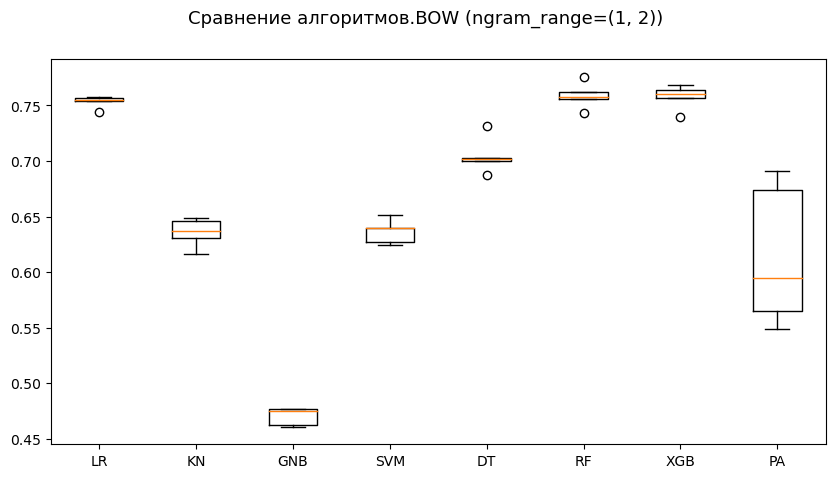

In [ ]:
#Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Сравнение алгоритмов.BOW (ngram_range=(1, 2))', fontsize=13)
ax = fig.add_subplot(111)
plt.boxplot(results_V12)
ax.set_xticklabels(names)
plt.show()


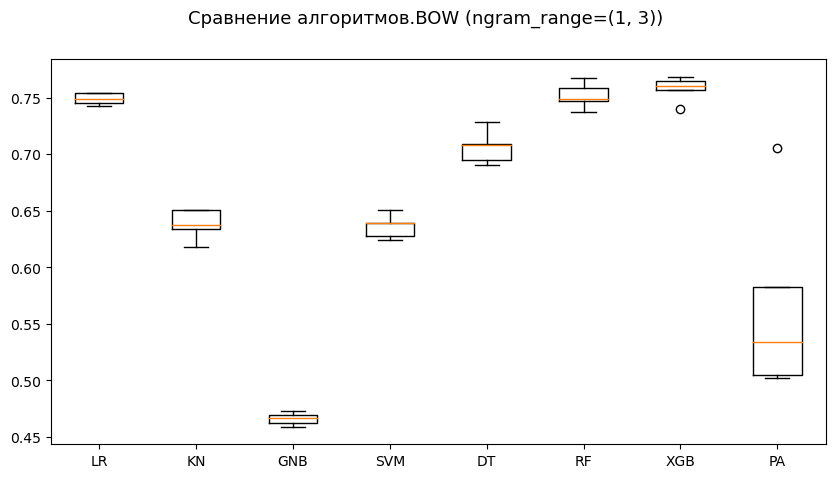

In [ ]:
#Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Сравнение алгоритмов.BOW (ngram_range=(1, 3))', fontsize=13)
ax = fig.add_subplot(111)
plt.boxplot(results_V13)
ax.set_xticklabels(names)
plt.show()

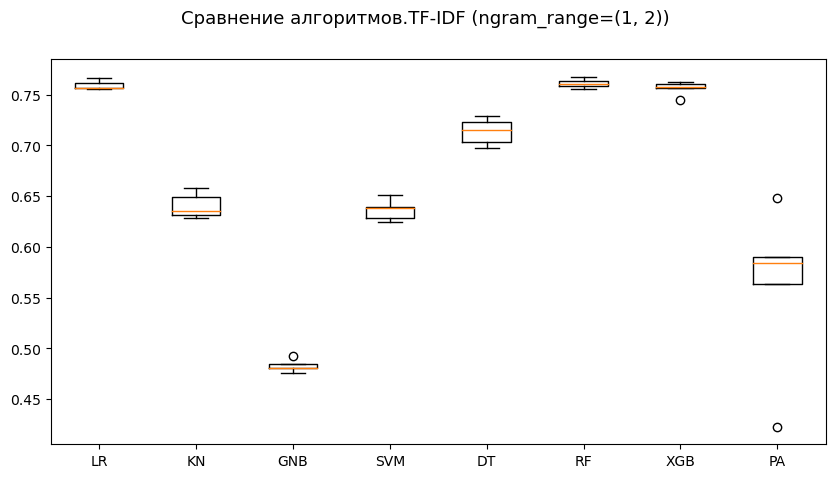

In [ ]:
#Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Сравнение алгоритмов.TF-IDF (ngram_range=(1, 2))', fontsize=13)
ax = fig.add_subplot(111)
plt.boxplot(results_TI12)
ax.set_xticklabels(names)
plt.show()

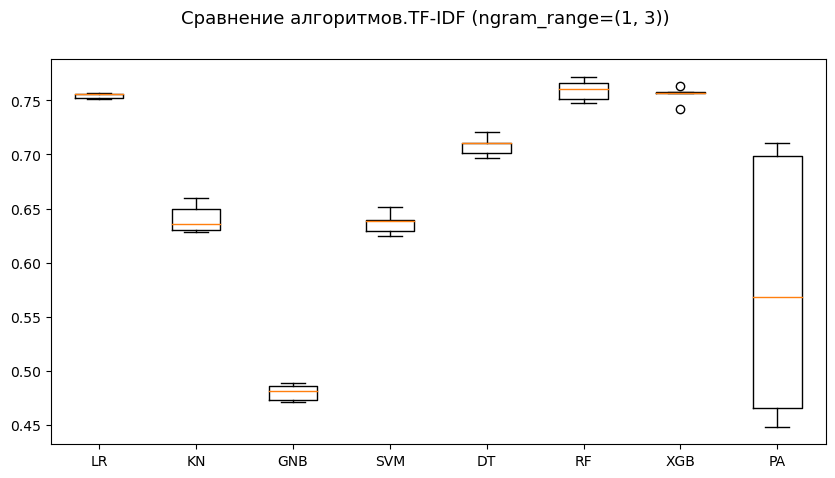

In [ ]:
#Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Сравнение алгоритмов.TF-IDF (ngram_range=(1, 3))', fontsize=13)
ax = fig.add_subplot(111)
plt.boxplot(results_TI13)
ax.set_xticklabels(names)
plt.show()

**Evaluate Algorithms: Standardize Data**

In [ ]:
#Standardize the dataset
#Countvectorize, ngram_range=(1, 2)
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MinMaxScaler()),('LR', LogisticRegression(n_jobs=-1))])))
pipelines.append(('ScaledKN', Pipeline([('Scaler', MinMaxScaler()),('KN', KNeighborsClassifier(n_jobs=-1))])))
pipelines.append(('ScaledGNB', Pipeline([('Scaler', MinMaxScaler()),('GNB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', MinMaxScaler()),('SVM', SVC())])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', MinMaxScaler()),('DT', DecisionTreeClassifier())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', MinMaxScaler()),('RF', RandomForestClassifier(n_jobs=-1))])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', MinMaxScaler()),('XGB', XGBClassifier(n_jobs=-1))])))
pipelines.append(('ScaledPA', Pipeline([('Scaler', MinMaxScaler()),('PA', PassiveAggressiveClassifier(n_jobs=-1))])))
results_V12 = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_V12, y_train_V12, cv=kfold, scoring=scoring)
    results_V12.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)




ScaledLR: 0.740394 (0.011393)
ScaledKN: 0.677833 (0.011071)
ScaledGNB: 0.455337 (0.003141)
ScaledSVM: 0.734647 (0.010128)
ScaledDT: 0.704269 (0.014745)
ScaledRF: 0.759442 (0.006986)
ScaledXGB: 0.757964 (0.009899)
ScaledPA: 0.630706 (0.036167)


In [ ]:
#Standardize the dataset
#Countvectorize, ngram_range=(1, 3)
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MinMaxScaler()),('LR', LogisticRegression(n_jobs=-1))])))
pipelines.append(('ScaledKN', Pipeline([('Scaler', MinMaxScaler()),('KN', KNeighborsClassifier(n_jobs=-1))])))
pipelines.append(('ScaledGNB', Pipeline([('Scaler', MinMaxScaler()),('GNB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', MinMaxScaler()),('SVM', SVC())])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', MinMaxScaler()),('DT', DecisionTreeClassifier())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', MinMaxScaler()),('RF', RandomForestClassifier(n_jobs=-1))])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', MinMaxScaler()),('XGB', XGBClassifier(n_jobs=-1))])))
pipelines.append(('ScaledPA', Pipeline([('Scaler', MinMaxScaler()),('PA', PassiveAggressiveClassifier(n_jobs=-1))])))
results_V13 = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_V13, y_train_V13, cv=kfold, scoring=scoring)
    results_V13.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


ScaledLR: 0.740558 (0.012255)
ScaledKN: 0.677668 (0.011240)
ScaledGNB: 0.451560 (0.002596)
ScaledSVM: 0.734647 (0.011117)
ScaledDT: 0.706240 (0.012745)
ScaledRF: 0.758292 (0.008138)
ScaledXGB: 0.757964 (0.009899)
ScaledPA: 0.653859 (0.024841)


In [ ]:
#Standardize the dataset
#TF-IDF Vectorizer, ngram_range=(1, 2)
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MinMaxScaler()),('LR', LogisticRegression(n_jobs=-1))])))
pipelines.append(('ScaledKN', Pipeline([('Scaler', MinMaxScaler()),('KN', KNeighborsClassifier(n_jobs=-1))])))
pipelines.append(('ScaledGNB', Pipeline([('Scaler', MinMaxScaler()),('GNB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', MinMaxScaler()),('SVM', SVC())])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', MinMaxScaler()),('DT', DecisionTreeClassifier())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', MinMaxScaler()),('RF', RandomForestClassifier(n_jobs=-1))])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', MinMaxScaler()),('XGB', XGBClassifier(n_jobs=-1))])))
pipelines.append(('ScaledPA', Pipeline([('Scaler', MinMaxScaler()),('PA', PassiveAggressiveClassifier(n_jobs=-1))])))
results_TI12 = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_TI12, y_train_TI12, cv=kfold, scoring=scoring)
    results_TI12.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.751560 (0.011252)
ScaledKN: 0.707882 (0.013772)
ScaledGNB: 0.465681 (0.003723)
ScaledSVM: 0.739409 (0.009583)
ScaledDT: 0.710509 (0.013245)
ScaledRF: 0.757635 (0.010260)
ScaledXGB: 0.756322 (0.006240)
ScaledPA: 0.667488 (0.009948)


In [ ]:
#Standardize the dataset
#TF-IDF Vectorizer, ngram_range=(1, 3)
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MinMaxScaler()),('LR', LogisticRegression(n_jobs=-1))])))
pipelines.append(('ScaledKN', Pipeline([('Scaler', MinMaxScaler()),('KN', KNeighborsClassifier(n_jobs=-1))])))
pipelines.append(('ScaledGNB', Pipeline([('Scaler', MinMaxScaler()),('GNB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', MinMaxScaler()),('SVM', SVC())])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', MinMaxScaler()),('DT', DecisionTreeClassifier())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', MinMaxScaler()),('RF', RandomForestClassifier(n_jobs=-1))])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', MinMaxScaler()),('XGB', XGBClassifier(n_jobs=-1))])))
pipelines.append(('ScaledPA', Pipeline([('Scaler', MinMaxScaler()),('PA', PassiveAggressiveClassifier(n_jobs=-1))])))
results_TI13 = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_TI13, y_train_TI13, cv=kfold, scoring=scoring)
    results_TI13.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.750739 (0.010825)
ScaledKN: 0.708374 (0.013574)
ScaledGNB: 0.463054 (0.000899)
ScaledSVM: 0.737110 (0.008586)
ScaledDT: 0.707553 (0.010823)
ScaledRF: 0.755008 (0.005260)
ScaledXGB: 0.755501 (0.007089)
ScaledPA: 0.646962 (0.024043)


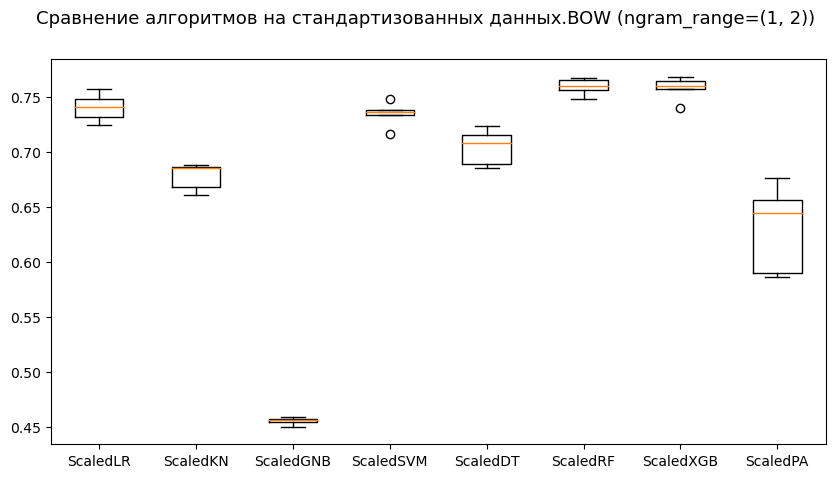

In [ ]:
#Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Сравнение алгоритмов на стандартизованных данных.BOW (ngram_range=(1, 2))', fontsize=13)
ax = fig.add_subplot(111)
plt.boxplot(results_V12)
ax.set_xticklabels(names)
plt.show()

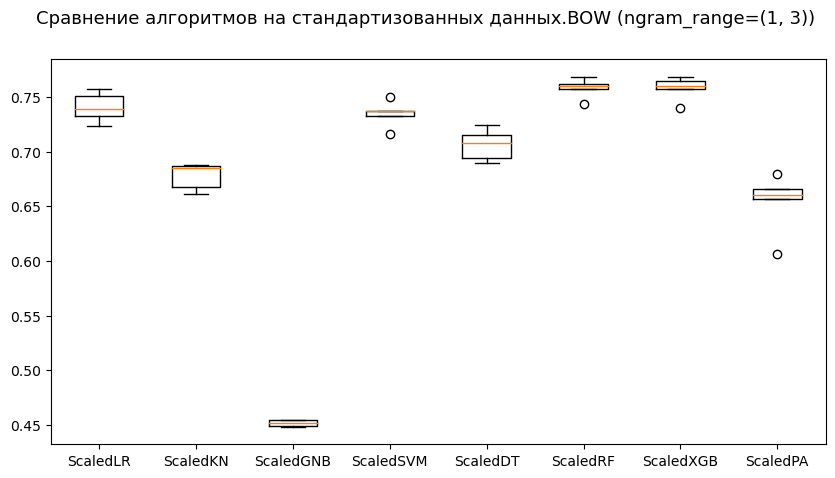

In [ ]:
#Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Сравнение алгоритмов на стандартизованных данных.BOW (ngram_range=(1, 3))', fontsize=13)
ax = fig.add_subplot(111)
plt.boxplot(results_V13)
ax.set_xticklabels(names)
plt.show()

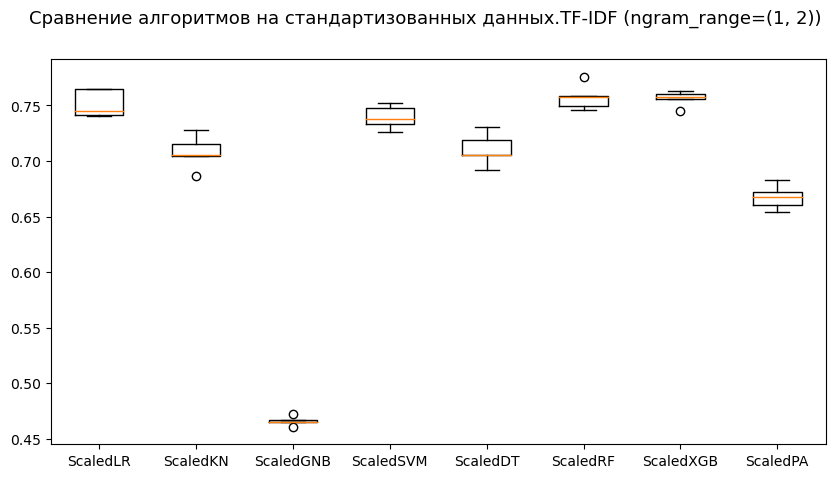

In [ ]:
#Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Сравнение алгоритмов на стандартизованных данных.TF-IDF (ngram_range=(1, 2))', fontsize=13)
ax = fig.add_subplot(111)
plt.boxplot(results_TI12)
ax.set_xticklabels(names)
plt.show()

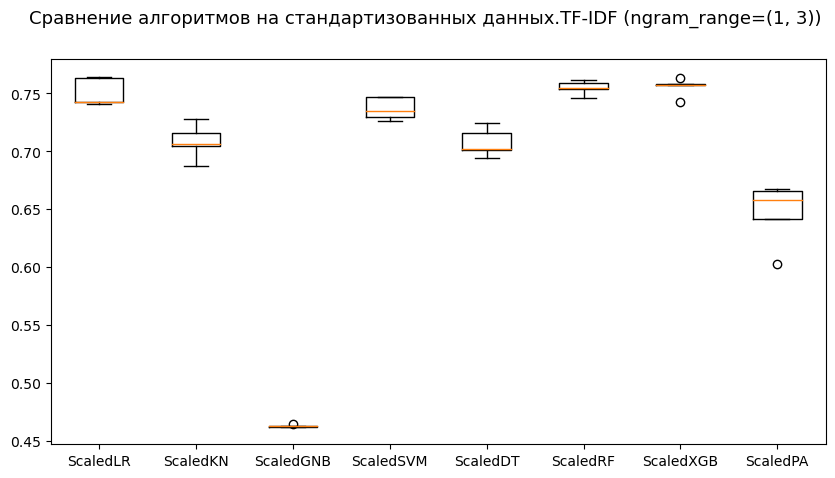

In [ ]:
#Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Сравнение алгоритмов на стандартизованных данных.TF-IDF (ngram_range=(1, 3))', fontsize=13)
ax = fig.add_subplot(111)
plt.boxplot(results_TI13)
ax.set_xticklabels(names)
plt.show()

**Algorithm Tuning**

In [71]:
print("Optuna Version : {}".format(optuna.__version__))

Optuna Version : 3.1.1


**LogisticRegression**

In [73]:
#Countvectorize, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    C = trial.suggest_float("C", 1.0, 10.0, log=True)
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    #Define the logistic regression model with the hyperparameters
    model_V12 = LogisticRegression(penalty=penalty, C=C, solver=solver)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V12_scaled = scaler.fit_transform(X_train_V12)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(model_V12, X_train_V12_scaled, y_train_V12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_V12 = optuna.create_study(direction="maximize", study_name="LR_CV12")
study_V12.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params LR_CV12: {}".format(study_V12.best_params))
print("\nBest Accuracy LR_CV12: {}".format(study_V12.best_value))


#Train the logistic regression model with the optimized hyperparameters
best_params_V12 = study_V12.best_params
model_V12 = LogisticRegression(**best_params_V12, n_jobs=-1)
scaler = MinMaxScaler()
X_train_V12_scaled = scaler.fit_transform(X_train_V12)
model_V12.fit(X_train_V12_scaled, y_train_V12)


#Evaluate the performance of the model on the testing set
X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_V12 = model_V12.predict(X_test_V12_scaled)





[I 2023-06-09 11:33:07,865] A new study created in memory with name: LR_CV12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-06-09 11:33:21,946] Trial 13 finished with value: 0.7336617405582924 and parameters: {'penalty': 'l1', 'C': 1.8480705355856424, 'solver': 'liblinear'}. Best is trial 13 with value: 0.7336617405582924.
[I 2023-06-09 11:33:22,200] Trial 5 finished with value: 0.7267651888341543 and parameters: {'penalty': 'l2', 'C': 2.9739163462286275, 'solver': 'liblinear'}. Best is trial 13 with value: 0.7336617405582924.
[I 2023-06-09 11:33:23,190] Trial 3 finished with value: 0.7113300492610837 and parameters: {'penalty': 'l1', 'C': 3.81644307656521, 'solver': 'liblinear'}. Best is trial 13 with value: 0.7336617405582924.
[I 2023-06-09 11:33:23,303] Trial 11 finished with value: 0.732183908045977 and parameters: {'penalty': 'l1', 'C': 2.075208198433035, 'solver': 'liblinear'}. Best is trial 13 with value: 0.7336617405582924.
[I 2023-06-09 11:33:23,507] Trial 14 finished with value: 0.7118226600985221 and parameters: {'penalty': 'l1', 'C': 3.637827239170902, 'solver': 'liblinear'}. Best is tri

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\I

[I 2023-06-09 11:34:59,800] Trial 21 finished with value: 0.7420361247947456 and parameters: {'penalty': 'l2', 'C': 1.0022802771553307, 'solver': 'saga'}. Best is trial 21 with value: 0.7420361247947456.
[I 2023-06-09 11:35:04,744] Trial 25 finished with value: 0.7410509031198687 and parameters: {'penalty': 'l2', 'C': 1.0406950278394385, 'solver': 'saga'}. Best is trial 21 with value: 0.7420361247947456.
[I 2023-06-09 11:35:10,576] Trial 8 finished with value: 0.7380952380952381 and parameters: {'penalty': 'l2', 'C': 1.273991361870638, 'solver': 'saga'}. Best is trial 21 with value: 0.7420361247947456.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\I

[I 2023-06-09 11:35:38,564] Trial 22 finished with value: 0.7354679802955666 and parameters: {'penalty': 'l2', 'C': 1.5640248226802687, 'solver': 'saga'}. Best is trial 21 with value: 0.7420361247947456.
[I 2023-06-09 11:35:41,546] Trial 12 finished with value: 0.7348111658456487 and parameters: {'penalty': 'l2', 'C': 1.7342417320769996, 'solver': 'saga'}. Best is trial 21 with value: 0.7420361247947456.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:35:46,064] Trial 6 finished with value: 0.7211822660098524 and parameters: {'penalty': 'l2', 'C': 3.8005503441671915, 'solver': 'saga'}. Best is trial 21 with value: 0.7420361247947456.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:35:47,265] Trial 1 finished with value: 0.7188834154351396 and parameters: {'penalty': 'l2', 'C': 4.224124513238856, 'solver': 'saga'}. Best is trial 21 with value: 0.7420361247947456.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\I

[I 2023-06-09 11:36:36,185] Trial 26 finished with value: 0.7481116584564861 and parameters: {'penalty': 'l1', 'C': 1.0856449220655484, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:36:39,310] Trial 27 finished with value: 0.7463054187192119 and parameters: {'penalty': 'l1', 'C': 1.1299103872405571, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:36:41,797] Trial 28 finished with value: 0.7454844006568144 and parameters: {'penalty': 'l1', 'C': 1.1495114593246922, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.
[I 2023-06-09 11:36:42,341] Trial 30 finished with value: 0.7407224958949097 and parameters: {'penalty': 'l2', 'C': 1.0881695728655114, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:36:44,404] Trial 20 finished with value: 0.7339901477832511 and parameters: {'penalty': 'l1', 'C': 1.976175097841942, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:36:45,560] Trial 29 finished with value: 0.7454844006568144 and parameters: {'penalty': 'l1', 'C': 1.160352671280763, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.
[I 2023-06-09 11:36:46,490] Trial 31 finished with value: 0.741871921182266 and parameters: {'penalty': 'l2', 'C': 1.0071844817527398, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.
[I 2023-06-09 11:36:50,857] Trial 32 finished with value: 0.7407224958949097 and parameters: {'penalty': 'l2', 'C': 1.0914710729404393, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:36:57,316] Trial 2 finished with value: 0.719376026272578 and parameters: {'penalty': 'l1', 'C': 4.0882182189525516, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:37:00,896] Trial 7 finished with value: 0.7136288998357964 and parameters: {'penalty': 'l1', 'C': 5.5835833917374735, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:37:04,717] Trial 17 finished with value: 0.7131362889983579 and parameters: {'penalty': 'l1', 'C': 5.566092952200457, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:37:07,950] Trial 4 finished with value: 0.7083743842364532 and parameters: {'penalty': 'l1', 'C': 7.543112818088295, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:37:17,146] Trial 33 finished with value: 0.7407224958949097 and parameters: {'penalty': 'l2', 'C': 1.0686018080049724, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.
[I 2023-06-09 11:37:18,007] Trial 34 finished with value: 0.7412151067323481 and parameters: {'penalty': 'l2', 'C': 1.057186516763337, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:37:27,885] Trial 36 finished with value: 0.7407224958949097 and parameters: {'penalty': 'l2', 'C': 1.065333723384804, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:37:37,034] Trial 35 finished with value: 0.7394088669950739 and parameters: {'penalty': 'l2', 'C': 1.2215363031072886, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\I

[I 2023-06-09 11:38:08,264] Trial 37 finished with value: 0.7408866995073892 and parameters: {'penalty': 'l2', 'C': 1.0339133090401567, 'solver': 'saga'}. Best is trial 26 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\I

[I 2023-06-09 11:39:28,444] Trial 38 finished with value: 0.7504105090311987 and parameters: {'penalty': 'l1', 'C': 1.0174878033963992, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:39:32,628] Trial 39 finished with value: 0.7451559934318555 and parameters: {'penalty': 'l1', 'C': 1.2428551971294737, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:39:32,952] Trial 40 finished with value: 0.7431855500821019 and parameters: {'penalty': 'l1', 'C': 1.2965361568998508, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:39:33,475] Trial 41 finished with value: 0.7435139573070607 and parameters: {'penalty': 'l1', 'C': 1.2776131298668691, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:39:34,010] Trial 42 finished with value: 0.7423645320197044 and parameters: {'penalty': 'l1', 'C': 1.3346530049144685, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:39:36,302] Trial 43 finished with value: 0.7433497536945813 and parameters: {'penalty': 'l1', 'C': 1.2920394970766436, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:39:38,452] Trial 44 finished with value: 0.7423645320197044 and parameters: {'penalty': 'l1', 'C': 1.3343635787054093, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:39:41,578] Trial 45 finished with value: 0.7417077175697865 and parameters: {'penalty': 'l1', 'C': 1.3451329170261448, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:39:43,596] Trial 46 finished with value: 0.7423645320197044 and parameters: {'penalty': 'l1', 'C': 1.3311865688244942, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:39:44,846] Trial 47 finished with value: 0.7417077175697865 and parameters: {'penalty': 'l1', 'C': 1.3470552155856663, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:39:46,035] Trial 48 finished with value: 0.7431855500821017 and parameters: {'penalty': 'l1', 'C': 1.2987360886872068, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2023-06-09 11:39:49,070] Trial 49 finished with value: 0.7408866995073892 and parameters: {'penalty': 'l1', 'C': 1.4123723696567296, 'solver': 'saga'}. Best is trial 38 with value: 0.7504105090311987.
Best Params LR_CV12: {'penalty': 'l1', 'C': 1.0174878033963992, 'solver': 'saga'}

Best Accuracy LR_CV12: 0.7504105090311987


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [74]:
predicted_prob_V12 = model_V12.predict_proba(X_test_V12_scaled)
predicted_prob_V12

array([[0.57256069, 0.42743931],
       [0.89388585, 0.10611415],
       [0.1301542 , 0.8698458 ],
       ...,
       [0.50550374, 0.49449626],
       [0.92112531, 0.07887469],
       [0.22812876, 0.77187124]])

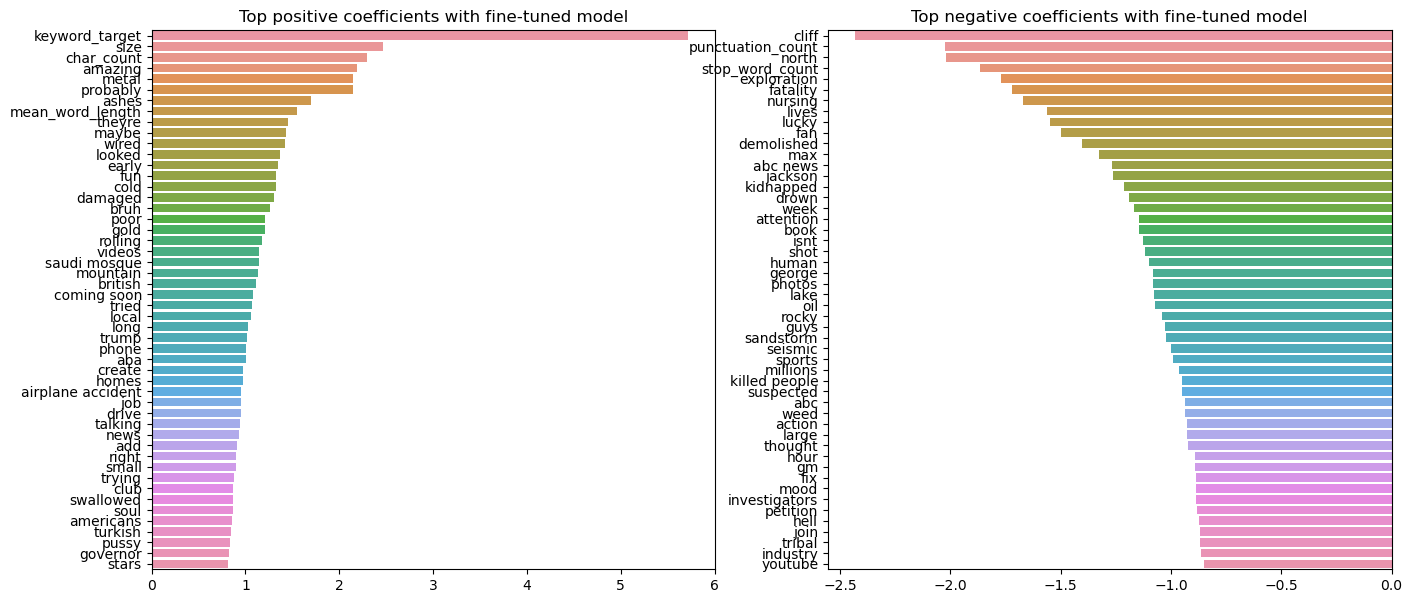

In [75]:
#Top features with fine-tuned model
plt.figure(figsize=(16,7))
s1 = pd.Series(np.transpose(model_V12.coef_[0]), index=X_test_V12.columns).sort_values(ascending=False)[:50]
s2 = pd.Series(np.transpose(model_V12.coef_[0]), index=X_test_V12.columns).sort_values()[:50]
plt.subplot(121)
sns.barplot(y=s1.index, x=s1)
plt.title('Top positive coefficients with fine-tuned model')
plt.subplot(122)
sns.barplot(y=s2.index, x=s2)
plt.title('Top negative coefficients with fine-tuned model')
plt.show()

In [76]:
probabilities_V12 = model_V12.predict_proba(X_test_V12_scaled)[:,1]
print(probabilities_V12.shape)

print("Predictions:", predictions_V12)
print("Probabilities:", probabilities_V12)


checker = test_data.loc[:,['text','keyword','target']]
checker['pred_prob'] = probabilities_V12
checker['error'] = np.abs(checker['target'] - checker['pred_prob'])

#Top 50 mispredicted tweets
error50 = checker.sort_values('error', ascending=False).head(50)
error50 = error50.rename_axis('id').reset_index()
error50.target.value_counts()

(1523,)
Predictions: [0 0 1 ... 0 0 1]
Probabilities: [0.42743931 0.10611415 0.8698458  ... 0.49449626 0.07887469 0.77187124]


1    43
0     7
Name: target, dtype: int64

In [77]:
pd.options.display.max_colwidth = 125

error50.loc[0:20,['text','target','pred_prob']]

text  target  pred_prob
0                                                                   yankees body bagging mfs       1   0.008488
1                                                                       get smoke shit peace       1   0.028020
2                                       remember u like blew one game u probs dont kings cup       1   0.028076
3   band buildings fire playing bbcintroducing purpleturtlerdg wednesday giantgiantsound rdg       0   0.952666
4              foxnews still beard visited prison keeps hideous beard electrocute uglypeople       1   0.053285
5                                                             israel wrecked home wants land       1   0.055005
6                                                                      opposite love fear ªs       1   0.057186
7              ollymursaus feel sorry piece meat nice guy people dont need rush screams face       1   0.057535
8                                                real question tornado siren going dyersburg       1   0.060737
9                billmccabe sky looks clear smoke fires enjoy time tahoe one favorite places       1   0.061837
10                                   pendleton media office said fire base right horno blaze       1   0.062803
11                                                          alil twister tha end like oh nah       1   0.068821
12                                                             imagine room walls lava lamps       1   0.069550
13                              dirknomissski yea someone faints panicking thats basic stuff       1   0.069729
14                                                               like could danger something       1   0.072159
15                                                           beckyfeigin defs stops bleeding       1   0.072726
16                                             crashdid queen diedid something explode knows       1   0.077757
17                                                                    flattened thee striker       1   0.078875
18                                                                           sevenfigz crush       1   0.079055
19                                                                pandemonium use fav cd get       1   0.079562
20                  update mac pros company bought may catastrophe failures requiring repair       1   0.080440

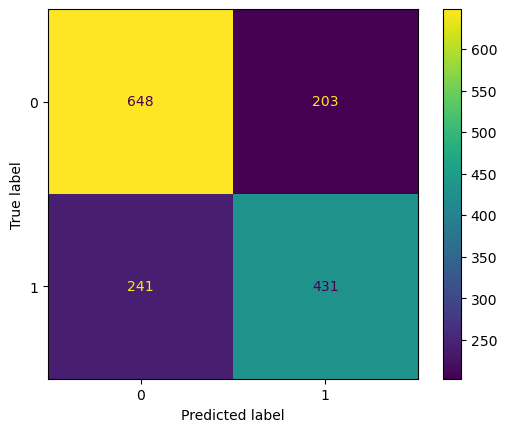

              precision    recall  f1-score   support

           0      0.729     0.761     0.745       851
           1      0.680     0.641     0.660       672

    accuracy                          0.708      1523
   macro avg      0.704     0.701     0.702      1523
weighted avg      0.707     0.708     0.707      1523



In [78]:
#Confusion matrix
cm=confusion_matrix(y_test_V12, predictions_V12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V12, predictions_V12, digits=3))

Accuracy: 0.71
Auc: 0.78


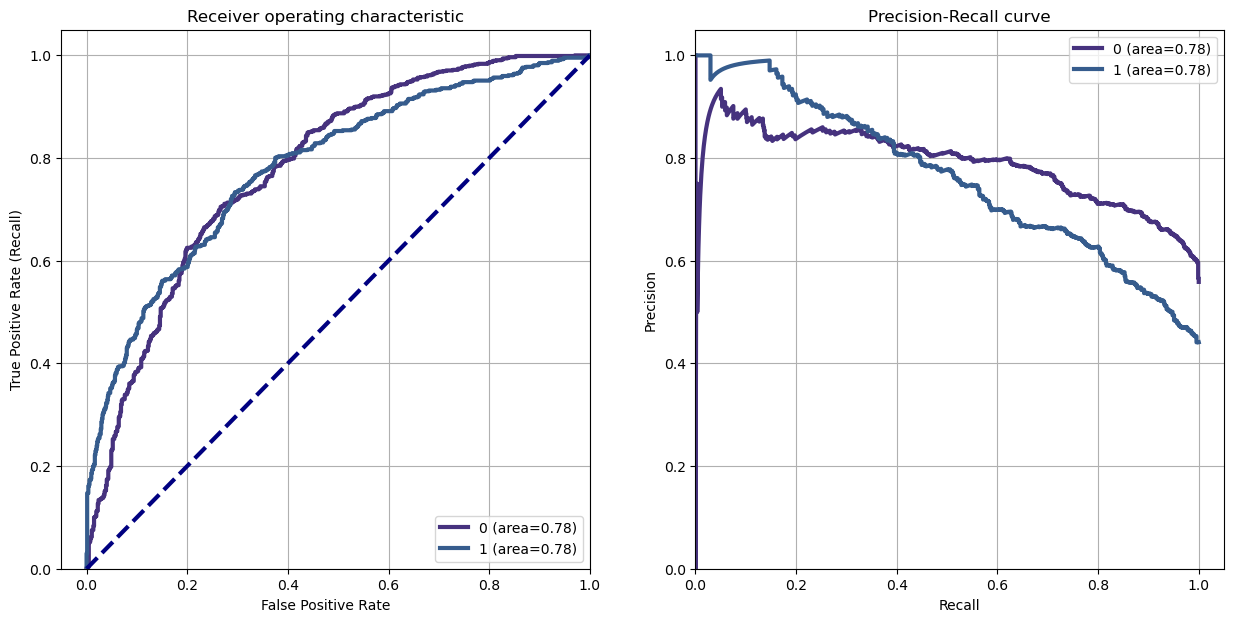

In [80]:
#https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, auc, precision_recall_curve

classes = np.unique(y_test_V12)
y_test_V12_array = pd.get_dummies(y_test_V12, drop_first=False).values
    
# Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_V12, predictions_V12)

auc = roc_auc_score(y_test_V12, predicted_prob_V12[:,1], multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
#print("Detail:")
#print(classification_report(y_test_V12, predictions_V12))
    
# Plot confusion matrix
# cm = confusion_matrix(y_test_V12, predictions_V12)
# fig, ax = plt.subplots()
# sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
#             cbar=False)
# ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
#        yticklabels=classes, title="Confusion matrix")
# plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
# Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_V12_array[:,i],  
                           predicted_prob_V12[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              roc_auc_score(y_test_V12_array[:, i], predicted_prob_V12[:, i])))
               
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
# Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_V12_array[:,i], predicted_prob_V12[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  roc_auc_score(y_test_V12_array[:, i], predicted_prob_V12[:, i]))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [185]:
#Countvectorize, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    C = trial.suggest_float("C", 1.0, 10.0, log=True)
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    #Define the logistic regression model with the hyperparameters
    model_V13 = LogisticRegression(penalty=penalty, C=C, solver=solver)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V13_scaled = scaler.fit_transform(X_train_V13)
    #X_test_scaled = scaler.transform(X_test_V13)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(model_V13, X_train_V13_scaled, y_train_V13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_V13 = optuna.create_study(direction="maximize", study_name="LR_CV13")
study_V13.optimize(objective, n_trials=20, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params LR_CV13: {}".format(study_V13.best_params))
print("\nBest Accuracy LR_CV13: {}".format(study_V13.best_value))


#Train the logistic regression model with the optimized hyperparameters
best_params_V13 = study_V13.best_params
model_V13 = LogisticRegression(**best_params_V13, n_jobs=-1)
scaler = MinMaxScaler()
X_train_V13_scaled = scaler.fit_transform(X_train_V13)
model_V13.fit(X_train_V13_scaled, y_train_V13)


#Evaluate the performance of the model on the testing set
X_test_V13_scaled = scaler.transform(X_test_V13)
predictions_V13 = model_V13.predict(X_test_V13_scaled)


[I 2023-05-30 22:28:21,805] A new study created in memory with name: LR_CV13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-05-30 22:28:25,742] Trial 1 finished with value: 0.7164203612479475 and parameters: {'penalty': 'l2', 'C': 4.457765954511704, 'solver': 'liblinear'}. Best is trial 1 with value: 0.7164203612479475.
[I 2023-05-30 22:28:25,799] Trial 7 finished with value: 0.7333333333333334 and parameters: {'penalty': 'l2', 'C': 2.0271711391213256, 'solver': 'liblinear'}. Best is trial 7 with value: 0.7333333333333334.
[I 2023-05-30 22:28:26,027] Trial 8 finished with value: 0.706568144499179 and parameters: {'penalty': 'l2', 'C': 7.816881578401291, 'solver': 'liblinear'}. Best is trial 7 with value: 0.7333333333333334.
[I 2023-05-30 22:28:26,146] Trial 4 finished with value: 0.7082101806239738 and parameters: {'penalty': 'l2', 'C': 7.193795018540421, 'solver': 'liblinear'}. Best is trial 7 with value: 0.7333333333333334.
[I 2023-05-30 22:28:26,266] Trial 10 finished with value: 0.7333333333333334 and parameters: {'penalty': 'l2', 'C': 2.0104745888934645, 'solver': 'liblinear'}. Best is trial 7 

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-30 22:30:02,171] Trial 14 finished with value: 0.738752052545156 and parameters: {'penalty': 'l2', 'C': 1.1935587346316947, 'solver': 'saga'}. Best is trial 14 with value: 0.738752052545156.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-30 22:30:06,239] Trial 11 finished with value: 0.7308702791461413 and parameters: {'penalty': 'l2', 'C': 2.5839881376403793, 'solver': 'saga'}. Best is trial 14 with value: 0.738752052545156.
[I 2023-05-30 22:30:06,284] Trial 13 finished with value: 0.7247947454844007 and parameters: {'penalty': 'l2', 'C': 3.570621480360711, 'solver': 'saga'}. Best is trial 14 with value: 0.738752052545156.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-30 22:30:08,686] Trial 9 finished with value: 0.732512315270936 and parameters: {'penalty': 'l2', 'C': 2.049684804185528, 'solver': 'saga'}. Best is trial 14 with value: 0.738752052545156.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-30 22:30:33,612] Trial 5 finished with value: 0.7443349753694581 and parameters: {'penalty': 'l1', 'C': 1.2592943512410044, 'solver': 'saga'}. Best is trial 5 with value: 0.7443349753694581.
[I 2023-05-30 22:30:33,697] Trial 6 finished with value: 0.7458128078817734 and parameters: {'penalty': 'l1', 'C': 1.1735402055155524, 'solver': 'saga'}. Best is trial 6 with value: 0.7458128078817734.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-30 22:30:35,755] Trial 2 finished with value: 0.7394088669950739 and parameters: {'penalty': 'l1', 'C': 1.5013901612428289, 'solver': 'saga'}. Best is trial 6 with value: 0.7458128078817734.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-30 22:30:38,196] Trial 3 finished with value: 0.7349753694581281 and parameters: {'penalty': 'l1', 'C': 2.252853548040788, 'solver': 'saga'}. Best is trial 6 with value: 0.7458128078817734.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-30 22:30:45,450] Trial 17 finished with value: 0.7295566502463054 and parameters: {'penalty': 'l1', 'C': 2.940851288927395, 'solver': 'saga'}. Best is trial 6 with value: 0.7458128078817734.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-30 22:30:51,365] Trial 18 finished with value: 0.713464696223317 and parameters: {'penalty': 'l1', 'C': 9.445452954490804, 'solver': 'saga'}. Best is trial 6 with value: 0.7458128078817734.
Best Params LR_CV13: {'penalty': 'l1', 'C': 1.1735402055155524, 'solver': 'saga'}

Best Accuracy LR_CV13: 0.7458128078817734


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


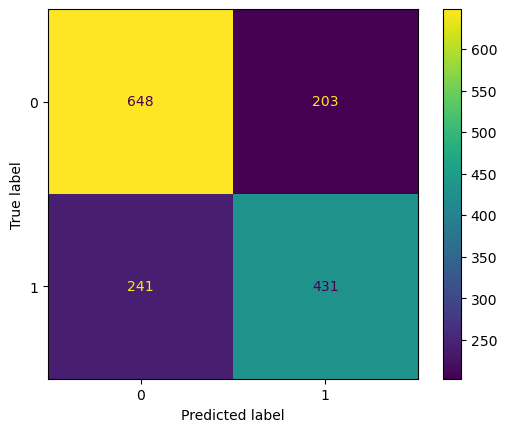

              precision    recall  f1-score   support

           0      0.729     0.761     0.745       851
           1      0.680     0.641     0.660       672

    accuracy                          0.708      1523
   macro avg      0.704     0.701     0.702      1523
weighted avg      0.707     0.708     0.707      1523



In [ ]:
#Confusion matrix
cm=confusion_matrix(y_test_V13, predictions_V13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V13, predictions_V13, digits=3))

In [ ]:
#TF-IDF Vectorizer, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    C = trial.suggest_float("C", 1.0, 10.0, log=True)
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    #Define the logistic regression model with the hyperparameters
    model_TI12 = LogisticRegression(penalty=penalty, C=C, solver=solver)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(model_TI12, X_train_TI12_scaled, y_train_TI12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_TI12 = optuna.create_study(direction="maximize", study_name="LR_TI12")
study_TI12.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params LR_TI12: {}".format(study_TI12.best_params))
print("\nBest Accuracy LR_TI12: {}".format(study_TI12.best_value))


#Train the logistic regression model with the optimized hyperparameters
best_params_TI12 = study_TI12.best_params
model_TI12 = LogisticRegression(**best_params_TI12, n_jobs=-1)
scaler = MinMaxScaler()
X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
model_TI12.fit(X_train_TI12_scaled, y_train_TI12)


#Evaluate the performance of the model on the testing set
X_test_TI12_scaled = scaler.transform(X_test_TI12)
predictions_TI12 = model_TI12.predict(X_test_TI12_scaled)



[I 2023-05-29 15:17:35,128] A new study created in memory with name: LR_TI12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-05-29 15:17:43,157] Trial 4 finished with value: 0.7481116584564861 and parameters: {'penalty': 'l2', 'C': 1.247059026742977, 'solver': 'liblinear'}. Best is trial 4 with value: 0.7481116584564861.
[I 2023-05-29 15:17:43,838] Trial 1 finished with value: 0.729392446633826 and parameters: {'penalty': 'l2', 'C': 3.5457397026773134, 'solver': 'liblinear'}. Best is trial 4 with value: 0.7481116584564861.
[I 2023-05-29 15:17:43,919] Trial 2 finished with value: 0.7300492610837438 and parameters: {'penalty': 'l2', 'C': 3.452221332845526, 'solver': 'liblinear'}. Best is trial 4 with value: 0.7481116584564861.
[I 2023-05-29 15:17:43,972] Trial 8 finished with value: 0.7270935960591134 and parameters: {'penalty': 'l2', 'C': 4.046409616457077, 'solver': 'liblinear'}. Best is trial 4 with value: 0.7481116584564861.
[I 2023-05-29 15:17:44,343] Trial 15 finished with value: 0.7467980295566502 and parameters: {'penalty': 'l1', 'C': 1.4628005033713791, 'solver': 'liblinear'}. Best is trial 4 

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max

[I 2023-05-29 15:18:04,085] Trial 6 finished with value: 0.7119868637110016 and parameters: {'penalty': 'l1', 'C': 3.865441044764492, 'solver': 'liblinear'}. Best is trial 4 with value: 0.7481116584564861.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:18:43,770] Trial 0 finished with value: 0.7517241379310345 and parameters: {'penalty': 'l2', 'C': 1.0540703354532024, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:18:51,688] Trial 5 finished with value: 0.7482758620689655 and parameters: {'penalty': 'l2', 'C': 1.1927033821654034, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:19:26,987] Trial 11 finished with value: 0.7394088669950739 and parameters: {'penalty': 'l2', 'C': 2.0283776631296218, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:19:37,379] Trial 7 finished with value: 0.7211822660098524 and parameters: {'penalty': 'l2', 'C': 6.311028913028138, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:19:37,937] Trial 9 finished with value: 0.732183908045977 and parameters: {'penalty': 'l2', 'C': 3.092922499362881, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:19:39,155] Trial 10 finished with value: 0.7323481116584565 and parameters: {'penalty': 'l2', 'C': 3.2791973188011183, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:19:41,923] Trial 22 finished with value: 0.7146141215106733 and parameters: {'penalty': 'l2', 'C': 9.189416344088146, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:19:42,938] Trial 3 finished with value: 0.7218390804597701 and parameters: {'penalty': 'l2', 'C': 6.171413610148562, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:19:44,924] Trial 13 finished with value: 0.7336617405582923 and parameters: {'penalty': 'l2', 'C': 2.696731284204583, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:19:45,998] Trial 19 finished with value: 0.7200328407224958 and parameters: {'penalty': 'l2', 'C': 6.8136066114362315, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:19:51,666] Trial 21 finished with value: 0.7331691297208539 and parameters: {'penalty': 'l2', 'C': 2.7546461280894188, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:20:04,540] Trial 24 finished with value: 0.7334975369458128 and parameters: {'penalty': 'l2', 'C': 2.7166893127523415, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:20:36,065] Trial 18 finished with value: 0.7399014778325123 and parameters: {'penalty': 'l1', 'C': 1.971784462539928, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:20:39,802] Trial 20 finished with value: 0.7305418719211823 and parameters: {'penalty': 'l1', 'C': 2.9081177672365706, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:20:42,634] Trial 12 finished with value: 0.7129720853858784 and parameters: {'penalty': 'l1', 'C': 6.2039072189099915, 'solver': 'saga'}. Best is trial 0 with value: 0.7517241379310345.
[I 2023-05-29 15:20:43,188] Trial 38 finished with value: 0.7574712643678161 and parameters: {'penalty': 'l1', 'C': 1.0459396638003038, 'solver': 'liblinear'}. Best is trial 38 with value: 0.7574712643678161.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:20:45,441] Trial 39 finished with value: 0.7502463054187192 and parameters: {'penalty': 'l2', 'C': 1.0779132026221345, 'solver': 'liblinear'}. Best is trial 38 with value: 0.7574712643678161.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:20:47,301] Trial 23 finished with value: 0.712807881773399 and parameters: {'penalty': 'l1', 'C': 6.348244018058948, 'solver': 'saga'}. Best is trial 38 with value: 0.7574712643678161.
[I 2023-05-29 15:20:49,487] Trial 41 finished with value: 0.7558292282430213 and parameters: {'penalty': 'l1', 'C': 1.0904056080410682, 'solver': 'liblinear'}. Best is trial 38 with value: 0.7574712643678161.
[I 2023-05-29 15:20:50,931] Trial 42 finished with value: 0.7574712643678161 and parameters: {'penalty': 'l1', 'C': 1.0642487228648072, 'solver': 'liblinear'}. Best is trial 38 with value: 0.7574712643678161.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:20:52,987] Trial 43 finished with value: 0.7574712643678161 and parameters: {'penalty': 'l1', 'C': 1.0622996248787069, 'solver': 'liblinear'}. Best is trial 38 with value: 0.7574712643678161.
[I 2023-05-29 15:20:54,497] Trial 44 finished with value: 0.7591133004926107 and parameters: {'penalty': 'l1', 'C': 1.0085677300152986, 'solver': 'liblinear'}. Best is trial 44 with value: 0.7591133004926107.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:20:56,470] Trial 45 finished with value: 0.7586206896551724 and parameters: {'penalty': 'l1', 'C': 1.0148096067555719, 'solver': 'liblinear'}. Best is trial 44 with value: 0.7591133004926107.
[I 2023-05-29 15:20:58,213] Trial 46 finished with value: 0.7584564860426929 and parameters: {'penalty': 'l1', 'C': 1.025210193941111, 'solver': 'liblinear'}. Best is trial 44 with value: 0.7591133004926107.
[I 2023-05-29 15:21:00,197] Trial 47 finished with value: 0.7584564860426929 and parameters: {'penalty': 'l1', 'C': 1.0164468439704115, 'solver': 'liblinear'}. Best is trial 44 with value: 0.7591133004926107.
[I 2023-05-29 15:21:02,015] Trial 48 finished with value: 0.7495894909688013 and parameters: {'penalty': 'l1', 'C': 1.3586691885987774, 'solver': 'liblinear'}. Best is trial 44 with value: 0.7591133004926107.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:21:03,880] Trial 49 finished with value: 0.7499178981937602 and parameters: {'penalty': 'l1', 'C': 1.366594037181406, 'solver': 'liblinear'}. Best is trial 44 with value: 0.7591133004926107.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:21:33,001] Trial 26 finished with value: 0.758128078817734 and parameters: {'penalty': 'l1', 'C': 1.0342294245272856, 'solver': 'saga'}. Best is trial 44 with value: 0.7591133004926107.
[I 2023-05-29 15:21:33,096] Trial 25 finished with value: 0.7556650246305419 and parameters: {'penalty': 'l1', 'C': 1.0942878811988097, 'solver': 'saga'}. Best is trial 44 with value: 0.7591133004926107.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:22:11,065] Trial 27 finished with value: 0.7576354679802956 and parameters: {'penalty': 'l1', 'C': 1.0710550368474492, 'solver': 'saga'}. Best is trial 44 with value: 0.7591133004926107.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:22:17,035] Trial 29 finished with value: 0.7541871921182265 and parameters: {'penalty': 'l1', 'C': 1.1140914335511507, 'solver': 'saga'}. Best is trial 44 with value: 0.7591133004926107.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:22:17,357] Trial 28 finished with value: 0.7558292282430213 and parameters: {'penalty': 'l1', 'C': 1.087189276250246, 'solver': 'saga'}. Best is trial 44 with value: 0.7591133004926107.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:22:18,353] Trial 30 finished with value: 0.7576354679802956 and parameters: {'penalty': 'l1', 'C': 1.0669950565302302, 'solver': 'saga'}. Best is trial 44 with value: 0.7591133004926107.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:22:19,728] Trial 31 finished with value: 0.7587848932676519 and parameters: {'penalty': 'l1', 'C': 1.0030427552582486, 'solver': 'saga'}. Best is trial 44 with value: 0.7591133004926107.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:22:22,796] Trial 34 finished with value: 0.7540229885057472 and parameters: {'penalty': 'l1', 'C': 1.1303759812142307, 'solver': 'saga'}. Best is trial 44 with value: 0.7591133004926107.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:22:23,628] Trial 32 finished with value: 0.7591133004926108 and parameters: {'penalty': 'l1', 'C': 1.024422139100203, 'solver': 'saga'}. Best is trial 32 with value: 0.7591133004926108.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:22:24,912] Trial 33 finished with value: 0.7587848932676519 and parameters: {'penalty': 'l1', 'C': 1.0029370701195004, 'solver': 'saga'}. Best is trial 32 with value: 0.7591133004926108.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:22:28,378] Trial 35 finished with value: 0.7558292282430213 and parameters: {'penalty': 'l1', 'C': 1.0887226926596376, 'solver': 'saga'}. Best is trial 32 with value: 0.7591133004926108.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:22:32,207] Trial 36 finished with value: 0.7574712643678161 and parameters: {'penalty': 'l1', 'C': 1.0568289821266839, 'solver': 'saga'}. Best is trial 32 with value: 0.7591133004926108.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:22:44,564] Trial 37 finished with value: 0.7589490968801315 and parameters: {'penalty': 'l1', 'C': 1.0175964067041259, 'solver': 'saga'}. Best is trial 32 with value: 0.7591133004926108.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:22:46,044] Trial 40 finished with value: 0.7591133004926108 and parameters: {'penalty': 'l1', 'C': 1.0124059116529482, 'solver': 'saga'}. Best is trial 32 with value: 0.7591133004926108.
Best Params LR_TI12: {'penalty': 'l1', 'C': 1.024422139100203, 'solver': 'saga'}

Best Accuracy LR_TI12: 0.7591133004926108


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


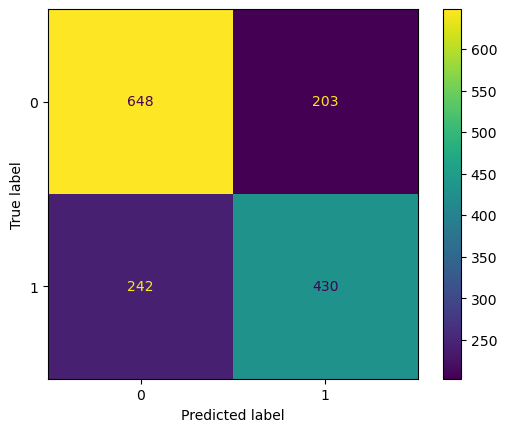

              precision    recall  f1-score   support

           0      0.728     0.761     0.744       851
           1      0.679     0.640     0.659       672

    accuracy                          0.708      1523
   macro avg      0.704     0.701     0.702      1523
weighted avg      0.707     0.708     0.707      1523



In [ ]:
#Confusion matrix LR_TI12
cm=confusion_matrix(y_test_TI12, predictions_TI12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI12, predictions_TI12, digits=3))

In [ ]:
#TF-IDF Vectorizer, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    C = trial.suggest_float("C", 1.0, 10.0, log=True)
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    #Define the logistic regression model with the hyperparameters
    model_TI13 = LogisticRegression(penalty=penalty, C=C, solver=solver)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(model_TI13, X_train_TI13_scaled, y_train_TI13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_TI13 = optuna.create_study(direction="maximize", study_name="LR_TI13")
study_TI13.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params LR_TI13: {}".format(study_TI13.best_params))
print("\nBest Accuracy LR_TI13: {}".format(study_TI13.best_value))


#Train the logistic regression model with the optimized hyperparameters
best_params_TI13 = study_TI13.best_params
model_TI13 = LogisticRegression(**best_params_TI13, n_jobs=-1)
scaler = MinMaxScaler()
X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
model_TI13.fit(X_train_TI13_scaled, y_train_TI13)


#Evaluate the performance of the model on the testing set
X_test_TI13_scaled = scaler.transform(X_test_TI13)
predictions_TI13 = model_TI13.predict(X_test_TI13_scaled)

[I 2023-05-29 15:31:12,597] A new study created in memory with name: LR_TI13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-05-29 15:31:21,398] Trial 6 finished with value: 0.748768472906404 and parameters: {'penalty': 'l2', 'C': 1.165205150453224, 'solver': 'liblinear'}. Best is trial 6 with value: 0.748768472906404.
[I 2023-05-29 15:31:21,561] Trial 8 finished with value: 0.7210180623973728 and parameters: {'penalty': 'l2', 'C': 5.497956859990949, 'solver': 'liblinear'}. Best is trial 6 with value: 0.748768472906404.
[I 2023-05-29 15:31:21,967] Trial 4 finished with value: 0.7259441707717571 and parameters: {'penalty': 'l2', 'C': 4.023012312636918, 'solver': 'liblinear'}. Best is trial 6 with value: 0.748768472906404.
[I 2023-05-29 15:31:22,103] Trial 5 finished with value: 0.7392446633825944 and parameters: {'penalty': 'l2', 'C': 1.7593625911348076, 'solver': 'liblinear'}. Best is trial 6 with value: 0.748768472906404.
[I 2023-05-29 15:31:22,185] Trial 1 finished with value: 0.7213464696223316 and parameters: {'penalty': 'l2', 'C': 4.99782191527671, 'solver': 'liblinear'}. Best is trial 6 with va

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:33:32,413] Trial 31 finished with value: 0.7525451559934317 and parameters: {'penalty': 'l2', 'C': 1.0052056862156444, 'solver': 'saga'}. Best is trial 12 with value: 0.7564860426929392.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:33:59,346] Trial 0 finished with value: 0.7397372742200329 and parameters: {'penalty': 'l2', 'C': 1.8336197019539402, 'solver': 'saga'}. Best is trial 12 with value: 0.7564860426929392.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:34:06,189] Trial 15 finished with value: 0.7233169129720853 and parameters: {'penalty': 'l2', 'C': 5.409256483241662, 'solver': 'saga'}. Best is trial 12 with value: 0.7564860426929392.
[I 2023-05-29 15:34:06,331] Trial 13 finished with value: 0.7338259441707716 and parameters: {'penalty': 'l2', 'C': 2.5253529989578305, 'solver': 'saga'}. Best is trial 12 with value: 0.7564860426929392.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:34:49,579] Trial 29 finished with value: 0.7587848932676519 and parameters: {'penalty': 'l1', 'C': 1.0290774059565644, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:34:50,232] Trial 27 finished with value: 0.7586206896551724 and parameters: {'penalty': 'l1', 'C': 1.0036003229679664, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.
[I 2023-05-29 15:34:50,323] Trial 26 finished with value: 0.7584564860426929 and parameters: {'penalty': 'l1', 'C': 1.0316765841581894, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:34:52,739] Trial 30 finished with value: 0.7586206896551724 and parameters: {'penalty': 'l1', 'C': 1.0012618770976789, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:34:56,819] Trial 28 finished with value: 0.7548440065681444 and parameters: {'penalty': 'l1', 'C': 1.1560586408383295, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:35:15,038] Trial 25 finished with value: 0.7566502463054187 and parameters: {'penalty': 'l1', 'C': 1.0854469400286226, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:35:32,228] Trial 22 finished with value: 0.7417077175697865 and parameters: {'penalty': 'l1', 'C': 2.1087350805002716, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:35:33,353] Trial 20 finished with value: 0.7331691297208539 and parameters: {'penalty': 'l1', 'C': 3.014308328805822, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:35:34,424] Trial 10 finished with value: 0.7295566502463054 and parameters: {'penalty': 'l1', 'C': 3.599666960518806, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.
[I 2023-05-29 15:35:34,584] Trial 21 finished with value: 0.7364532019704433 and parameters: {'penalty': 'l1', 'C': 2.6898257972199318, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:35:36,533] Trial 7 finished with value: 0.7246305418719212 and parameters: {'penalty': 'l1', 'C': 4.892146812640777, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:35:43,984] Trial 2 finished with value: 0.7195402298850575 and parameters: {'penalty': 'l1', 'C': 6.4730176930646, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:38:13,759] Trial 32 finished with value: 0.7548440065681444 and parameters: {'penalty': 'l1', 'C': 1.1463769354163147, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:38:57,276] Trial 33 finished with value: 0.7550082101806239 and parameters: {'penalty': 'l1', 'C': 1.1365842964203008, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:39:01,187] Trial 35 finished with value: 0.7586206896551724 and parameters: {'penalty': 'l1', 'C': 1.0314794903540312, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:39:02,206] Trial 34 finished with value: 0.758128078817734 and parameters: {'penalty': 'l1', 'C': 1.049374838780498, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:39:17,189] Trial 36 finished with value: 0.7587848932676519 and parameters: {'penalty': 'l1', 'C': 1.0102466938839867, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:39:17,869] Trial 38 finished with value: 0.7517241379310345 and parameters: {'penalty': 'l1', 'C': 1.3288457904216895, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:39:18,910] Trial 39 finished with value: 0.752216748768473 and parameters: {'penalty': 'l1', 'C': 1.2963198299946763, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:39:19,633] Trial 37 finished with value: 0.7518883415435139 and parameters: {'penalty': 'l1', 'C': 1.3091812565541123, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:39:22,367] Trial 40 finished with value: 0.7518883415435139 and parameters: {'penalty': 'l1', 'C': 1.2968460061353435, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:39:39,507] Trial 43 finished with value: 0.7517241379310345 and parameters: {'penalty': 'l1', 'C': 1.328601094268039, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:39:41,129] Trial 46 finished with value: 0.7533661740558293 and parameters: {'penalty': 'l1', 'C': 1.263645408864709, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:39:57,439] Trial 47 finished with value: 0.7533661740558293 and parameters: {'penalty': 'l1', 'C': 1.257364749290625, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.
[I 2023-05-29 15:39:57,482] Trial 41 finished with value: 0.7507389162561575 and parameters: {'penalty': 'l1', 'C': 1.3595831258230124, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:40:02,428] Trial 42 finished with value: 0.7517241379310345 and parameters: {'penalty': 'l1', 'C': 1.3434401985139535, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:40:02,970] Trial 45 finished with value: 0.7538587848932676 and parameters: {'penalty': 'l1', 'C': 1.2456389452135785, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:40:04,000] Trial 44 finished with value: 0.7502463054187192 and parameters: {'penalty': 'l1', 'C': 1.3791011861202815, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

[I 2023-05-29 15:40:47,479] Trial 48 finished with value: 0.7510673234811165 and parameters: {'penalty': 'l1', 'C': 1.3511783975635987, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2023-05-29 15:40:54,661] Trial 49 finished with value: 0.7513957307060755 and parameters: {'penalty': 'l1', 'C': 1.3536241188531846, 'solver': 'saga'}. Best is trial 29 with value: 0.7587848932676519.
Best Params LR_TI13: {'penalty': 'l1', 'C': 1.0290774059565644, 'solver': 'saga'}

Best Accuracy LR_TI13: 0.7587848932676519


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


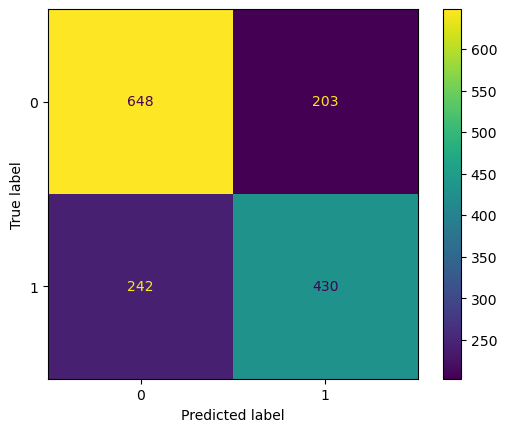

              precision    recall  f1-score   support

           0      0.728     0.761     0.744       851
           1      0.679     0.640     0.659       672

    accuracy                          0.708      1523
   macro avg      0.704     0.701     0.702      1523
weighted avg      0.707     0.708     0.707      1523



In [ ]:
#Confusion matrix LR_TI13
cm=confusion_matrix(y_test_TI13, predictions_TI13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI13, predictions_TI13, digits=3))

**KNeighborsClassifier**

In [ ]:
#Countvectorize, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 21, step=2)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

    #Define the logistic regression model with the hyperparameters
    knn_V12 = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, algorithm=algorithm)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V12_scaled = scaler.fit_transform(X_train_V12)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(knn_V12, X_train_V12_scaled, y_train_V12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_V12 = optuna.create_study(direction="maximize", study_name="KN_CV12")
study_V12.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params KN_CV12: {}".format(study_V12.best_params))
print("\nBest Accuracy KN_CV12: {}".format(study_V12.best_value))


#Train the logistic regression model with the optimized hyperparameters
best_params_V12 = study_V12.best_params
knn_V12 = KNeighborsClassifier(**best_params_V12, n_jobs=-1)
scaler = MinMaxScaler()
X_train_V12_scaled = scaler.fit_transform(X_train_V12)
knn_V12.fit(X_train_V12_scaled, y_train_V12)


#Evaluate the performance of the model on the testing set
X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_V12 = knn_V12.predict(X_test_V12_scaled)


[I 2023-05-29 17:21:48,670] A new study created in memory with name: KN_CV12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-05-29 17:22:14,039] Trial 11 finished with value: 0.7466338259441707 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 11 with value: 0.7466338259441707.
[I 2023-05-29 17:22:14,363] Trial 5 finished with value: 0.7279146141215106 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 11 with value: 0.7466338259441707.
[I 2023-05-29 17:22:14,522] Trial 15 finished with value: 0.6924466338259441 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 11 with value: 0.7466338259441707.
[I 2023-05-29 17:22:14,760] Trial 9 finished with value: 0.7201970443349754 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 11 with value: 0.7466338259441707.
[I 2023-05-29 17:22:15,072] Trial 14 finished with value: 0.6839080459770115 and par

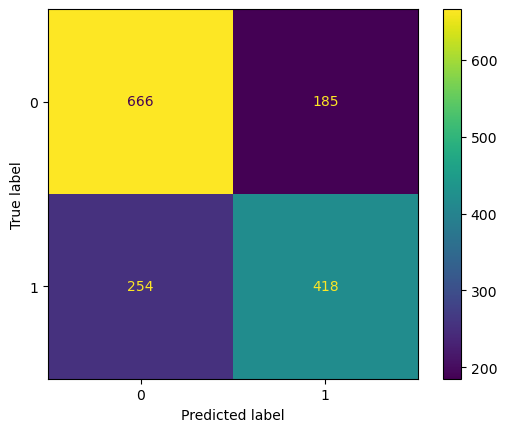

              precision    recall  f1-score   support

           0      0.724     0.783     0.752       851
           1      0.693     0.622     0.656       672

    accuracy                          0.712      1523
   macro avg      0.709     0.702     0.704      1523
weighted avg      0.710     0.712     0.710      1523



In [ ]:
#Confusion matrix KN_V12
cm=confusion_matrix(y_test_V12, predictions_V12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V12, predictions_V12, digits=3))

In [ ]:
#Countvectorize, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 21, step=2)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

    #Define the logistic regression model with the hyperparameters
    knn_V13 = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, algorithm=algorithm)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V13_scaled = scaler.fit_transform(X_train_V13)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(knn_V13, X_train_V13_scaled, y_train_V13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_V13 = optuna.create_study(direction="maximize", study_name="KN_CV13")
study_V13.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params KN_CV13: {}".format(study_V13.best_params))
print("\nBest Accuracy KN_CV13: {}".format(study_V13.best_value))


#Train the logistic regression model with the optimized hyperparameters
best_params_V13 = study_V13.best_params
knn_V13 = KNeighborsClassifier(**best_params_V13, n_jobs=-1)
scaler = MinMaxScaler()
X_train_V13_scaled = scaler.fit_transform(X_train_V13)
knn_V13.fit(X_train_V13_scaled, y_train_V13)


#Evaluate the performance of the model on the testing set
X_test_V13_scaled = scaler.transform(X_test_V13)
predictions_V13 = knn_V13.predict(X_test_V13_scaled)

[I 2023-05-29 17:40:48,972] A new study created in memory with name: KN_CV13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-05-29 17:41:28,261] Trial 7 finished with value: 0.6783251231527093 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 7 with value: 0.6783251231527093.
[I 2023-05-29 17:41:28,781] Trial 6 finished with value: 0.7172413793103447 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 6 with value: 0.7172413793103447.
[I 2023-05-29 17:41:29,284] Trial 1 finished with value: 0.7410509031198687 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 1 with value: 0.7410509031198687.
[I 2023-05-29 17:41:32,164] Trial 9 finished with value: 0.7413793103448276 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 9 with value: 0.7413793103448276.
[I 2023-05-29 17:41:35,344] Trial 11 finished with value: 0.7172413793103447 and parameter

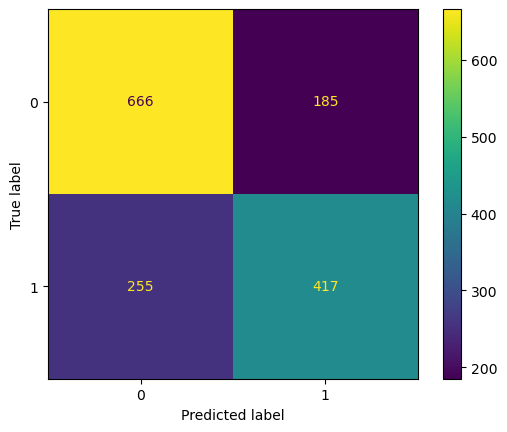

              precision    recall  f1-score   support

           0      0.723     0.783     0.752       851
           1      0.693     0.621     0.655       672

    accuracy                          0.711      1523
   macro avg      0.708     0.702     0.703      1523
weighted avg      0.710     0.711     0.709      1523



In [ ]:
#Confusion matrix KN_V13
cm=confusion_matrix(y_test_V13, predictions_V13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V13, predictions_V13, digits=3))

In [ ]:
#TF-IDF Vectorizer, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 21, step=2)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

    #Define the logistic regression model with the hyperparameters
    knn_TI12 = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, algorithm=algorithm)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(knn_TI12, X_train_TI12_scaled, y_train_TI12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_TI12 = optuna.create_study(direction="maximize", study_name="KN_TI12")
study_TI12.optimize(objective, n_trials=40, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params KN_TI12: {}".format(study_TI12.best_params))
print("\nBest Accuracy KN_TI12: {}".format(study_TI12.best_value))


#Train the logistic regression model with the optimized hyperparameters
best_params_TI12 = study_TI12.best_params
knn_TI12 = KNeighborsClassifier(**best_params_TI12, n_jobs=-1)
scaler = MinMaxScaler()
X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
knn_TI12.fit(X_train_TI12_scaled, y_train_TI12)


#Evaluate the performance of the model on the testing set
X_test_TI12_scaled = scaler.transform(X_test_TI12)
predictions_TI12 = knn_TI12.predict(X_test_TI12_scaled)

[I 2023-05-29 18:02:03,424] A new study created in memory with name: KN_TI12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2023-05-29 18:02:35,600] Trial 8 finished with value: 0.7459770114942529 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 8 with value: 0.7459770114942529.
[I 2023-05-29 18:02:35,806] Trial 12 finished with value: 0.7490968801313629 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 12 with value: 0.7490968801313629.
[I 2023-05-29 18:02:35,914] Trial 0 finished with value: 0.7408866995073892 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 12 with value: 0.7490968801313629.
[I 2023-05-29 18:02:36,098] Trial 4 finished with value: 0.7236453201970444 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 12 with value: 0.7490968801313629.
[I 2023-05-29 18:03:37,423] Trial 10 finished with value: 0.7239737274220033 and p

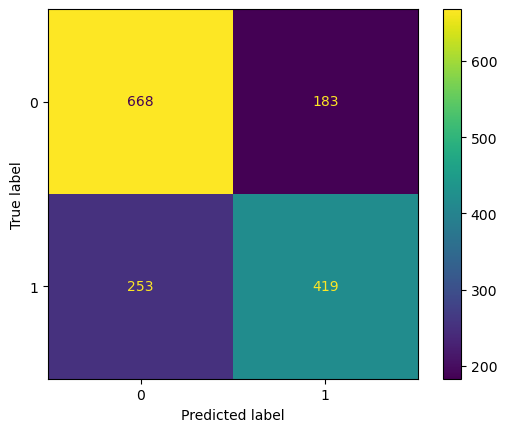

              precision    recall  f1-score   support

           0      0.725     0.785     0.754       851
           1      0.696     0.624     0.658       672

    accuracy                          0.714      1523
   macro avg      0.711     0.704     0.706      1523
weighted avg      0.712     0.714     0.712      1523



In [ ]:
#Confusion matrix KN_TI12
cm=confusion_matrix(y_test_TI12, predictions_TI12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI12, predictions_TI12, digits=3))

In [ ]:
#TF-IDF Vectorizer, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 27, step=2)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

    #Define the logistic regression model with the hyperparameters
    knn_TI13 = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, algorithm=algorithm)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(knn_TI13, X_train_TI13_scaled, y_train_TI13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_TI13 = optuna.create_study(direction="maximize", study_name="KN_TI13")
study_TI13.optimize(objective, n_trials=40, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params KN_TI13: {}".format(study_TI13.best_params))
print("\nBest Accuracy KN_TI13: {}".format(study_TI13.best_value))


#Train the logistic regression model with the optimized hyperparameters
best_params_TI13 = study_TI13.best_params
knn_TI13 = KNeighborsClassifier(**best_params_TI13, n_jobs=-1)
scaler = MinMaxScaler()
X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
knn_TI13.fit(X_train_TI13_scaled, y_train_TI13)


#Evaluate the performance of the model on the testing set
X_test_TI13_scaled = scaler.transform(X_test_TI13)
predictions_TI13 = knn_TI13.predict(X_test_TI13_scaled)

[I 2023-05-29 18:13:36,942] A new study created in memory with name: KN_TI13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2023-05-29 18:14:24,998] Trial 2 finished with value: 0.7118226600985221 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 2 with value: 0.7118226600985221.
[I 2023-05-29 18:14:27,203] Trial 5 finished with value: 0.7463054187192119 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 5 with value: 0.7463054187192119.
[I 2023-05-29 18:14:59,868] Trial 16 finished with value: 0.7563218390804598 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 16 with value: 0.7563218390804598.
[I 2023-05-29 18:16:16,327] Trial 6 finished with value: 0.7538587848932676 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 16 with value: 0.7563218390804598.
[I 2023-05-29 18:16:16,507] Trial 10 finished with value: 0.6479474548440065 and param

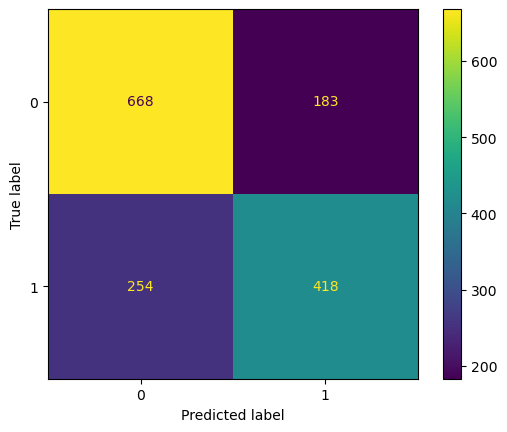

              precision    recall  f1-score   support

           0      0.725     0.785     0.754       851
           1      0.696     0.622     0.657       672

    accuracy                          0.713      1523
   macro avg      0.710     0.703     0.705      1523
weighted avg      0.712     0.713     0.711      1523



In [ ]:
#Confusion matrix KN_TI13
cm=confusion_matrix(y_test_TI13, predictions_TI13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI13, predictions_TI13, digits=3))

**Support Vector Classification**

In [21]:
#Countvectorize, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    C = trial.suggest_float('C', 0.1, 2.5, step=0.2)
    #gamma = trial.suggest_float('gamma', 0.01, 10, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])

    #Define the logistic regression model with the hyperparameters
    svc_V12 = SVC(C=C, kernel=kernel) # gamma=gamma

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V12_scaled = scaler.fit_transform(X_train_V12)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(svc_V12, X_train_V12_scaled, y_train_V12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_SVC12 = optuna.create_study(direction="maximize", study_name="SVC_CV12")
study_SVC12.optimize(objective, n_trials=20, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params SVC_CV12: {}".format(study_SVC12.best_params))
print("\nBest Accuracy SVC_CV12: {}".format(study_SVC12.best_value))




#Train the logistic regression model with the optimized hyperparameters
best_params_V12 = study_SVC12.best_params
svc_V12 = SVC(**best_params_V12)
scaler = MinMaxScaler()
X_train_V12_scaled = scaler.fit_transform(X_train_V12)
svc_V12.fit(X_train_V12_scaled, y_train_V12)


#Evaluate the performance of the model on the testing set
X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_V12 = svc_V12.predict(X_test_V12_scaled)

[I 2023-05-29 23:35:56,295] A new study created in memory with name: SVC_CV12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-05-29 23:45:39,879] Trial 7 finished with value: 0.7279146141215107 and parameters: {'C': 2.5, 'kernel': 'sigmoid'}. Best is trial 7 with value: 0.7279146141215107.
[I 2023-05-29 23:45:53,462] Trial 6 finished with value: 0.7142857142857143 and parameters: {'C': 1.3000000000000003, 'kernel': 'linear'}. Best is trial 7 with value: 0.7279146141215107.
[I 2023-05-29 23:46:05,203] Trial 15 finished with value: 0.741871921182266 and parameters: {'C': 0.30000000000000004, 'kernel': 'linear'}. Best is trial 15 with value: 0.741871921182266.
[I 2023-05-29 23:46:48,625] Trial 5 finished with value: 0.7492610837438425 and parameters: {'C': 1.1, 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.7492610837438425.
[I 2023-05-29 23:46:52,248] Trial 11 finished with value: 0.739080459770115 and parameters: {'C': 1.9000000000000001, 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.7492610837438425.
[I 2023-05-29 23:46:55,645] Trial 12 finished with value: 0.7458128078817734 and parameters

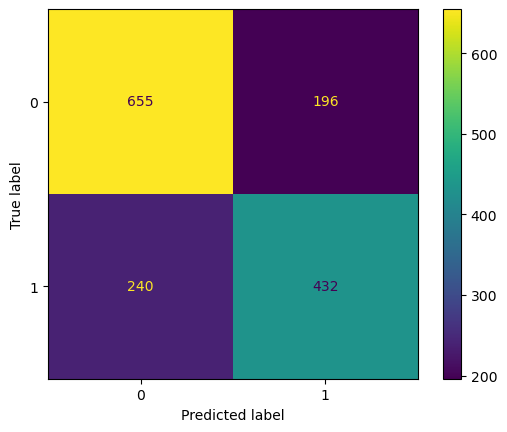

              precision    recall  f1-score   support

           0      0.732     0.770     0.750       851
           1      0.688     0.643     0.665       672

    accuracy                          0.714      1523
   macro avg      0.710     0.706     0.707      1523
weighted avg      0.712     0.714     0.712      1523



In [22]:
#Confusion matrix SVC_CV12
cm=confusion_matrix(y_test_V12, predictions_V12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V12, predictions_V12, digits=3))

In [23]:
#Countvectorize, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    C = trial.suggest_float('C', 0.3, 2.5, step=0.2)
    #gamma = trial.suggest_float('gamma', 0.01, 10, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])

    #Define the logistic regression model with the hyperparameters
    svc_V13 = SVC(C=C, kernel=kernel)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V13_scaled = scaler.fit_transform(X_train_V13)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(svc_V13, X_train_V13_scaled, y_train_V13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_SVC13 = optuna.create_study(direction="maximize", study_name="SVC_CV13")
study_SVC13.optimize(objective, n_trials=20, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params SVC_CV13: {}".format(study_SVC13.best_params))
print("\nBest Accuracy SVC_CV13: {}".format(study_SVC13.best_value))


#Train the logistic regression model with the optimized hyperparameters
best_params_V13 = study_SVC13.best_params
svc_V13 = SVC(**best_params_V13)
scaler = MinMaxScaler()
X_train_V13_scaled = scaler.fit_transform(X_train_V13)
svc_V13.fit(X_train_V13_scaled, y_train_V13)


#Evaluate the performance of the model on the testing set
X_test_V13_scaled = scaler.transform(X_test_V13)
predictions_V13 = svc_V13.predict(X_test_V13_scaled)

[I 2023-05-29 23:59:34,934] A new study created in memory with name: SVC_CV13


CPU times: total: 0 ns
Wall time: 987 µs


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-05-30 00:11:18,473] Trial 2 finished with value: 0.7080459770114943 and parameters: {'C': 2.1, 'kernel': 'linear'}. Best is trial 2 with value: 0.7080459770114943.
[I 2023-05-30 00:11:28,038] Trial 15 finished with value: 0.7313628899835796 and parameters: {'C': 0.5, 'kernel': 'linear'}. Best is trial 15 with value: 0.7313628899835796.
[I 2023-05-30 00:11:30,125] Trial 13 finished with value: 0.7121510673234811 and parameters: {'C': 1.5000000000000002, 'kernel': 'linear'}. Best is trial 15 with value: 0.7313628899835796.
[I 2023-05-30 00:11:37,913] Trial 3 finished with value: 0.7476190476190476 and parameters: {'C': 1.3, 'kernel': 'sigmoid'}. Best is trial 3 with value: 0.7476190476190476.
[I 2023-05-30 00:12:01,819] Trial 11 finished with value: 0.7060755336617406 and parameters: {'C': 2.5, 'kernel': 'linear'}. Best is trial 3 with value: 0.7476190476190476.
[I 2023-05-30 00:12:07,592] Trial 5 finished with value: 0.7154351395730706 and parameters: {'C': 1.3, 'kernel': 'linea

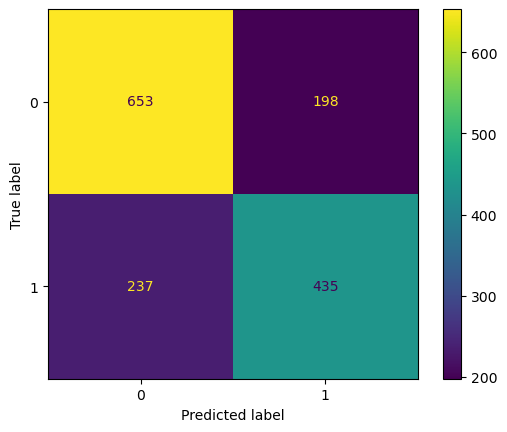

              precision    recall  f1-score   support

           0      0.734     0.767     0.750       851
           1      0.687     0.647     0.667       672

    accuracy                          0.714      1523
   macro avg      0.710     0.707     0.708      1523
weighted avg      0.713     0.714     0.713      1523



In [24]:
#Confusion matrix SVC_CV13
cm=confusion_matrix(y_test_V13, predictions_V13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V13, predictions_V13, digits=3))

In [89]:
#TF-IDF Vectorizer, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    C = trial.suggest_float('C', 0.3, 2.5, step=0.2)
    #gamma = trial.suggest_float('gamma', 0.01, 10, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])

    #Define the SVM model with the hyperparameters
    svc_TI12 = SVC(C=C, kernel=kernel) # gamma=gamma

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(svc_TI12, X_train_TI12_scaled, y_train_TI12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_SVCTI12 = optuna.create_study(direction="maximize", study_name="SVC_TI12")
study_SVCTI12.optimize(objective, n_trials=20, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params SVC_TI12: {}".format(study_SVCTI12.best_params))
print("\nBest Accuracy SVC_TI12: {}".format(study_SVCTI12.best_value))




#Train the logistic regression model with the optimized hyperparameters
best_params_TI12 = study_SVCTI12.best_params
svc_TI12 = SVC(**best_params_TI12)
scaler = MinMaxScaler()
X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
svc_TI12.fit(X_train_TI12_scaled, y_train_TI12)


#Evaluate the performance of the model on the testing set
X_test_TI12_scaled = scaler.transform(X_test_TI12)
predictions_TI12 = svc_TI12.predict(X_test_TI12_scaled)

[I 2023-05-30 13:07:51,515] A new study created in memory with name: SVC_TI12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-05-30 13:15:21,003] Trial 1 finished with value: 0.6894909688013136 and parameters: {'C': 2.1, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.6894909688013136.
[I 2023-05-30 13:15:29,823] Trial 4 finished with value: 0.6894909688013136 and parameters: {'C': 2.1, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.6894909688013136.
[I 2023-05-30 13:15:36,907] Trial 8 finished with value: 0.7004926108374384 and parameters: {'C': 1.5000000000000002, 'kernel': 'sigmoid'}. Best is trial 8 with value: 0.7004926108374384.
[I 2023-05-30 13:16:49,860] Trial 0 finished with value: 0.7155993431855501 and parameters: {'C': 1.3, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.7155993431855501.
[I 2023-05-30 13:17:12,837] Trial 7 finished with value: 0.7311986863711001 and parameters: {'C': 0.9000000000000001, 'kernel': 'sigmoid'}. Best is trial 7 with value: 0.7311986863711001.
[I 2023-05-30 13:18:02,439] Trial 11 finished with value: 0.7167487684729064 and parameters: {'C': 1.5000

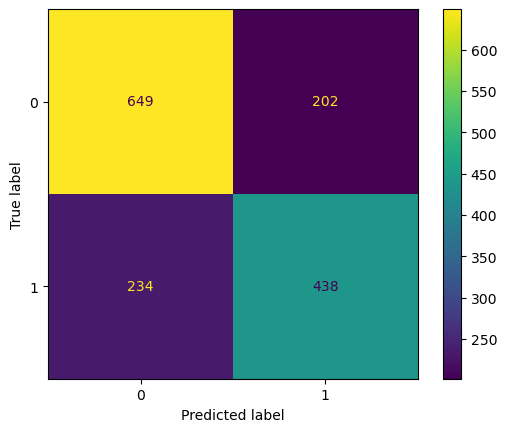

              precision    recall  f1-score   support

           0      0.735     0.763     0.749       851
           1      0.684     0.652     0.668       672

    accuracy                          0.714      1523
   macro avg      0.710     0.707     0.708      1523
weighted avg      0.713     0.714     0.713      1523



In [90]:
#Confusion matrix SVC_TI12
cm=confusion_matrix(y_test_TI12, predictions_TI12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI12, predictions_TI12, digits=3))

In [91]:
#TF-IDF Vectorizer, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    C = trial.suggest_float('C', 0.3, 2.5, step=0.2)
    #gamma = trial.suggest_float('gamma', 0.01, 10, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])

    #Define the SVM model with the hyperparameters
    svc_TI13 = SVC(C=C, kernel=kernel) # gamma=gamma

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(svc_TI13, X_train_TI13_scaled, y_train_TI13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_SVCTI13 = optuna.create_study(direction="maximize", study_name="SVC_TI13")
study_SVCTI13.optimize(objective, n_trials=20, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params SVC_TI13: {}".format(study_SVCTI13.best_params))
print("\nBest Accuracy SVC_TI13: {}".format(study_SVCTI13.best_value))




#Train the logistic regression model with the optimized hyperparameters
best_params_TI13 = study_SVCTI13.best_params
svc_TI13 = SVC(**best_params_TI13)
scaler = MinMaxScaler()
X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
svc_TI13.fit(X_train_TI13_scaled, y_train_TI13)


#Evaluate the performance of the model on the testing set
X_test_TI13_scaled = scaler.transform(X_test_TI13)
predictions_TI13 = svc_TI13.predict(X_test_TI13_scaled)

[I 2023-05-30 13:28:59,291] A new study created in memory with name: SVC_TI13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-05-30 13:39:55,129] Trial 5 finished with value: 0.696551724137931 and parameters: {'C': 2.1, 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.696551724137931.
[I 2023-05-30 13:40:16,407] Trial 2 finished with value: 0.7075533661740557 and parameters: {'C': 1.7000000000000002, 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.7075533661740557.
[I 2023-05-30 13:41:24,045] Trial 13 finished with value: 0.7113300492610838 and parameters: {'C': 2.5, 'kernel': 'linear'}. Best is trial 13 with value: 0.7113300492610838.
[I 2023-05-30 13:41:29,988] Trial 10 finished with value: 0.7113300492610838 and parameters: {'C': 2.5, 'kernel': 'linear'}. Best is trial 13 with value: 0.7113300492610838.
[I 2023-05-30 13:41:33,478] Trial 14 finished with value: 0.713136288998358 and parameters: {'C': 2.1, 'kernel': 'linear'}. Best is trial 14 with value: 0.713136288998358.
[I 2023-05-30 13:41:37,550] Trial 7 finished with value: 0.7151067323481116 and parameters: {'C': 1.7000000000000002, 'ke

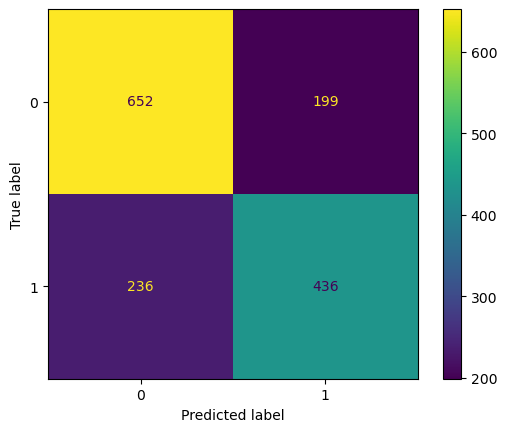

              precision    recall  f1-score   support

           0      0.734     0.766     0.750       851
           1      0.687     0.649     0.667       672

    accuracy                          0.714      1523
   macro avg      0.710     0.707     0.709      1523
weighted avg      0.713     0.714     0.713      1523



In [92]:
#Confusion matrix SVC_TI13
cm=confusion_matrix(y_test_TI13, predictions_TI13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI13, predictions_TI13, digits=3))

**RandomForestClassifier**

In [ ]:
#Countvectorize, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 50, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    #Define the logistic regression model with the hyperparameters
    rf_V12 = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf) 

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V12_scaled = scaler.fit_transform(X_train_V12)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(rf_V12, X_train_V12_scaled, y_train_V12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_RF12 = optuna.create_study(direction="maximize", study_name="RF_CV12")
study_RF12.optimize(objective, n_trials=20, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params RF_CV12: {}".format(study_RF12.best_params))
print("\nBest Accuracy RF_CV12: {}".format(study_RF12.best_value))




#Train the logistic regression model with the optimized hyperparameters
best_params_V12 = study_RF12.best_params
rf_V12 = RandomForestClassifier(**best_params_V12, n_jobs=-1)
scaler = MinMaxScaler()
X_train_V12_scaled = scaler.fit_transform(X_train_V12)
rf_V12.fit(X_train_V12_scaled, y_train_V12)


#Evaluate the performance of the model on the testing set
X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_V12 = rf_V12.predict(X_test_V12_scaled)

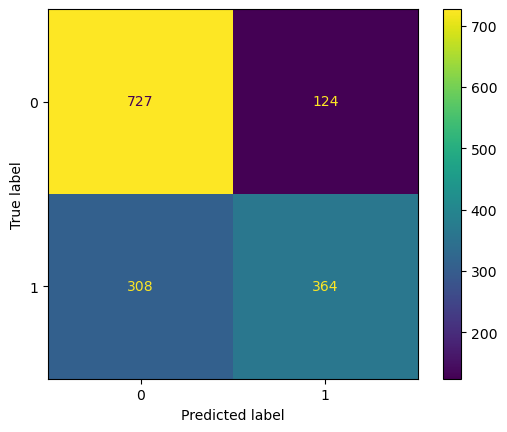

              precision    recall  f1-score   support

           0      0.702     0.854     0.771       851
           1      0.746     0.542     0.628       672

    accuracy                          0.716      1523
   macro avg      0.724     0.698     0.699      1523
weighted avg      0.722     0.716     0.708      1523



In [20]:
#Confusion matrix RF_CV12
cm=confusion_matrix(y_test_V12, predictions_V12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V12, predictions_V12, digits=3))

In [ ]:
#Countvectorize, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 50, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    #Define the logistic regression model with the hyperparameters
    rf_V13 = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf) 

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V13_scaled = scaler.fit_transform(X_train_V13)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(rf_V13, X_train_V13_scaled, y_train_V13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_RF13 = optuna.create_study(direction="maximize", study_name="RF_CV13")
study_RF13.optimize(objective, n_trials=30, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params RF_CV13: {}".format(study_RF13.best_params))
print("\nBest Accuracy RF_CV13: {}".format(study_RF13.best_value))




#Train the RFC model with the optimized hyperparameters
best_params_V13 = study_RF13.best_params
rf_V13 = RandomForestClassifier(**best_params_V13, n_jobs=-1)
scaler = MinMaxScaler()
X_train_V13_scaled = scaler.fit_transform(X_train_V13)
rf_V13.fit(X_train_V13_scaled, y_train_V13)


#Evaluate the performance of the model on the testing set
X_test_V13_scaled = scaler.transform(X_test_V13)
predictions_V13 = rf_V13.predict(X_test_V13_scaled)

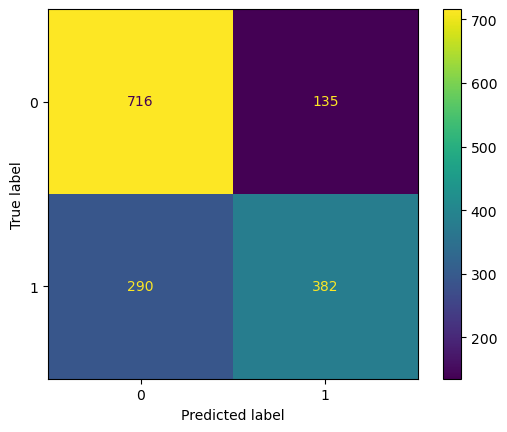

              precision    recall  f1-score   support

           0      0.712     0.841     0.771       851
           1      0.739     0.568     0.643       672

    accuracy                          0.721      1523
   macro avg      0.725     0.705     0.707      1523
weighted avg      0.724     0.721     0.714      1523



In [22]:
#Confusion matrix RF_CV13
cm=confusion_matrix(y_test_V13, predictions_V13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V13, predictions_V13, digits=3))

In [23]:
#TF-IDF Vectorizer, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 50, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    #Define the logistic regression model with the hyperparameters
    rf_TI12 = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf) 

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(rf_TI12, X_train_TI12_scaled, y_train_TI12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_RFTI12 = optuna.create_study(direction="maximize", study_name="RF_TI12")
study_RFTI12.optimize(objective, n_trials=20, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params RF_TI12: {}".format(study_RFTI12.best_params))
print("\nBest Accuracy RF_TI12: {}".format(study_RFTI12.best_value))




#Train the logistic regression model with the optimized hyperparameters
best_params_TI12 = study_RFTI12.best_params
rf_TI12 = RandomForestClassifier(**best_params_TI12, n_jobs=-1)
scaler = MinMaxScaler()
X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
rf_TI12.fit(X_train_TI12_scaled, y_train_TI12)


#Evaluate the performance of the model on the testing set
X_test_TI12_scaled = scaler.transform(X_test_TI12)
predictions_TI12 = rf_TI12.predict(X_test_TI12_scaled)

[I 2023-05-30 00:51:51,081] A new study created in memory with name: RF_TI12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-05-30 00:52:13,878] Trial 3 finished with value: 0.7382594417077175 and parameters: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.7382594417077175.
[I 2023-05-30 00:52:18,116] Trial 12 finished with value: 0.5875205254515599 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.7382594417077175.
[I 2023-05-30 00:52:30,830] Trial 8 finished with value: 0.7380952380952381 and parameters: {'n_estimators': 50, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.7382594417077175.
[I 2023-05-30 00:52:56,188] Trial 7 finished with value: 0.746305418719212 and parameters: {'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.746305418719212.
[I 2023-05-30 00:52:56,360] Trial 11 finished with value: 0.7467980295566503 and parameters: {'

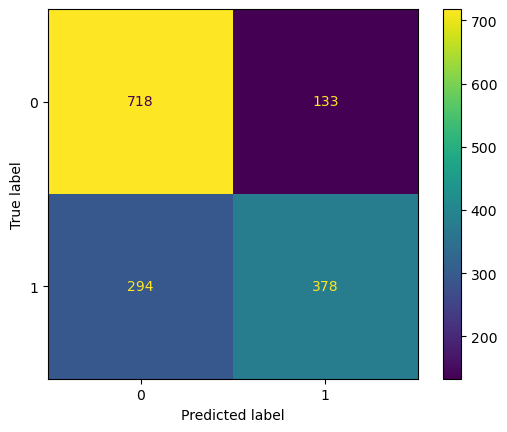

              precision    recall  f1-score   support

           0      0.709     0.844     0.771       851
           1      0.740     0.562     0.639       672

    accuracy                          0.720      1523
   macro avg      0.725     0.703     0.705      1523
weighted avg      0.723     0.720     0.713      1523



In [24]:
#Confusion matrix RF_TI12
cm=confusion_matrix(y_test_TI12, predictions_TI12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI12, predictions_TI12, digits=3))

In [25]:
#TF-IDF Vectorizer, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 50, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    #Define the RandomForestClassifier model with the hyperparameters
    rf_TI13 = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf) 

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
 

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(rf_TI13, X_train_TI13_scaled, y_train_TI13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_RFTI13 = optuna.create_study(direction="maximize", study_name="RF_TI13")
study_RFTI13.optimize(objective, n_trials=30, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params RF_TI13: {}".format(study_RFTI13.best_params))
print("\nBest Accuracy RF_TI13: {}".format(study_RFTI13.best_value))




#Train the RF model with the optimized hyperparameters
best_params_TI13 = study_RFTI13.best_params
rf_TI13 = RandomForestClassifier(**best_params_TI13, n_jobs=-1)
scaler = MinMaxScaler()
X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
rf_TI13.fit(X_train_TI13_scaled, y_train_TI13)


#Evaluate the performance of the model on the testing set
X_test_TI13_scaled = scaler.transform(X_test_TI13)
predictions_TI13 = rf_TI13.predict(X_test_TI13_scaled)

[I 2023-05-30 00:57:42,956] A new study created in memory with name: RF_TI13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-05-30 00:58:02,328] Trial 5 finished with value: 0.596551724137931 and parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 5 with value: 0.596551724137931.
[I 2023-05-30 00:58:14,311] Trial 8 finished with value: 0.7244663382594416 and parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 8 with value: 0.7244663382594416.
[I 2023-05-30 00:58:21,151] Trial 0 finished with value: 0.7400656814449917 and parameters: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7400656814449917.
[I 2023-05-30 00:58:24,429] Trial 13 finished with value: 0.7149425287356321 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7400656814449917.
[I 2023-05-30 00:58:31,225] Trial 10 finished with value: 0.7408866995073892 and parameters: {

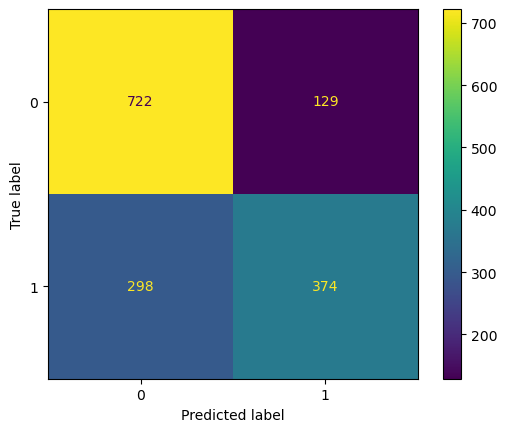

              precision    recall  f1-score   support

           0      0.708     0.848     0.772       851
           1      0.744     0.557     0.637       672

    accuracy                          0.720      1523
   macro avg      0.726     0.702     0.704      1523
weighted avg      0.724     0.720     0.712      1523



In [26]:
#Confusion matrix RF_TI13
cm=confusion_matrix(y_test_TI13, predictions_TI13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI13, predictions_TI13, digits=3))

**PassiveAggressiveClassifier**

In [28]:
#Countvectorize, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    average = trial.suggest_categorical('average', [True, False])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    #Define the logistic regression model with the hyperparameters
    model_PA12 = PassiveAggressiveClassifier(C=C, fit_intercept=fit_intercept, max_iter=max_iter, tol=tol, loss=loss, average=average, 
                                             class_weight=class_weight)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V12_scaled = scaler.fit_transform(X_train_V12)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(model_PA12, X_train_V12_scaled, y_train_V12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_V12 = optuna.create_study(direction="maximize", study_name="PA_CV12")
study_V12.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params PA_CV12: {}".format(study_V12.best_params))
print("\nBest Accuracy PA_CV12: {}".format(study_V12.best_value))


#Train the PAC model with the optimized hyperparameters
best_params_V12 = study_V12.best_params
model_PA12 = PassiveAggressiveClassifier(**best_params_V12, n_jobs=-1)
scaler = MinMaxScaler()
X_train_V12_scaled = scaler.fit_transform(X_train_V12)
model_PA12.fit(X_train_V12_scaled, y_train_V12)


#Evaluate the performance of the model on the testing set
X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_V12 = model_PA12.predict(X_test_V12_scaled)


[I 2023-05-30 01:20:41,032] A new study created in memory with name: PA_CV12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 

[I 2023-05-30 01:20:46,842] Trial 2 finished with value: 0.6707717569786535 and parameters: {'C': 80760.09219409489, 'fit_intercept': True, 'max_iter': 400, 'tol': 7.113836209872043e-05, 'loss': 'squared_hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6707717569786535.
[I 2023-05-30 01:20:47,116] Trial 8 finished with value: 0.6003284072249591 and parameters: {'C': 15.973368901343356, 'fit_intercept': True, 'max_iter': 1000, 'tol': 5.175462710600518e-05, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 2 with value: 0.6707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:47,602] Trial 3 finished with value: 0.5720853858784893 and parameters: {'C': 1.3957923209789805e-05, 'fit_intercept': False, 'max_iter': 100, 'tol': 0.0065555557333184305, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 2 with value: 0.6707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:48,976] Trial 1 finished with value: 0.6288998357963875 and parameters: {'C': 13.696544149174471, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.00013120467739712618, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:50,433] Trial 12 finished with value: 0.6203612479474547 and parameters: {'C': 2.0001660655293207, 'fit_intercept': True, 'max_iter': 700, 'tol': 0.0063090306355653184, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 2 with value: 0.6707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:50,899] Trial 4 finished with value: 0.690311986863711 and parameters: {'C': 4.811287064372343, 'fit_intercept': True, 'max_iter': 400, 'tol': 0.0022987627910429176, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 4 with value: 0.690311986863711.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:52,346] Trial 10 finished with value: 0.6292282430213465 and parameters: {'C': 0.7797335583533817, 'fit_intercept': True, 'max_iter': 900, 'tol': 0.004004229645545826, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.690311986863711.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:52,640] Trial 11 finished with value: 0.648111658456486 and parameters: {'C': 0.22182525203463913, 'fit_intercept': False, 'max_iter': 700, 'tol': 0.004290911031624054, 'loss': 'squared_hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.690311986863711.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:53,047] Trial 5 finished with value: 0.5935960591133005 and parameters: {'C': 31.695553325833014, 'fit_intercept': False, 'max_iter': 1000, 'tol': 9.997666006699507e-06, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.690311986863711.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:54,264] Trial 13 finished with value: 0.7555008210180624 and parameters: {'C': 0.0016765492866730684, 'fit_intercept': True, 'max_iter': 400, 'tol': 0.00158536036680163, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:54,757] Trial 6 finished with value: 0.6146141215106733 and parameters: {'C': 1.5885861265297614, 'fit_intercept': False, 'max_iter': 100, 'tol': 1.2864905321590487e-05, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:55,124] Trial 17 finished with value: 0.5977011494252873 and parameters: {'C': 7.987664030425659, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0009096751351258847, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:55,664] Trial 15 finished with value: 0.6305418719211822 and parameters: {'C': 1057.611075428144, 'fit_intercept': False, 'max_iter': 100, 'tol': 5.043923212413692e-06, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:56,155] Trial 7 finished with value: 0.6288998357963875 and parameters: {'C': 2058.5700697537113, 'fit_intercept': False, 'max_iter': 500, 'tol': 1.7578587737122708e-06, 'loss': 'squared_hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:20:56,837] Trial 16 finished with value: 0.6348111658456486 and parameters: {'C': 13.906916682501137, 'fit_intercept': False, 'max_iter': 400, 'tol': 0.005918820590917923, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:58,567] Trial 14 finished with value: 0.6484400656814449 and parameters: {'C': 296.81569331247215, 'fit_intercept': False, 'max_iter': 600, 'tol': 0.0003759159576305045, 'loss': 'hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:20:59,582] Trial 18 finished with value: 0.6252873563218391 and parameters: {'C': 0.6885794214021814, 'fit_intercept': False, 'max_iter': 600, 'tol': 0.0006175833051640636, 'loss': 'squared_hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:21:00,330] Trial 19 finished with value: 0.6192118226600986 and parameters: {'C': 0.6204891523506395, 'fit_intercept': True, 'max_iter': 800, 'tol': 7.993609162993553e-06, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:21:05,396] Trial 21 finished with value: 0.6435139573070607 and parameters: {'C': 0.3531215913435998, 'fit_intercept': False, 'max_iter': 100, 'tol': 1.1993141521955787e-05, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:21:07,008] Trial 23 finished with value: 0.6500821018062398 and parameters: {'C': 6129.463351065561, 'fit_intercept': False, 'max_iter': 500, 'tol': 0.00014228447140384563, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:21:07,370] Trial 22 finished with value: 0.7057471264367817 and parameters: {'C': 0.15257596114697344, 'fit_intercept': True, 'max_iter': 800, 'tol': 0.0028919691504946214, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702:

[I 2023-05-30 01:21:13,439] Trial 9 finished with value: 0.6779967159277505 and parameters: {'C': 0.0494946909474261, 'fit_intercept': True, 'max_iter': 800, 'tol': 1.128719635608535e-06, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:21:21,148] Trial 32 finished with value: 0.719047619047619 and parameters: {'C': 0.012605378117579792, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0018321711055960192, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:21:21,793] Trial 31 finished with value: 0.7147783251231528 and parameters: {'C': 0.014053090003840342, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0020273788521664986, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:21:25,236] Trial 33 finished with value: 0.7218390804597702 and parameters: {'C': 0.030824942822876254, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0013816222654958058, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702:

[I 2023-05-30 01:21:28,444] Trial 34 finished with value: 0.7376026272577996 and parameters: {'C': 0.014229335619731895, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0016310119198380167, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 13 with value: 0.7555008210180624.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)

[I 2023-05-30 01:21:30,037] Trial 26 finished with value: 0.758128078817734 and parameters: {'C': 0.0008744724509196693, 'fit_intercept': True, 'max_iter': 400, 'tol': 0.0006851285904765543, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.
[I 2023-05-30 01:21:30,234] Trial 35 finished with value: 0.7430213464696223 and parameters: {'C': 0.009730519036418974, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0016236975664216378, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:21:33,602] Trial 37 finished with value: 0.7513957307060755 and parameters: {'C': 0.0070857270240332415, 'fit_intercept': True, 'max_iter': 400, 'tol': 0.0018845900533289868, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:21:34,029] Trial 36 finished with value: 0.7344827586206897 and parameters: {'C': 0.014808083743818522, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0013666562937558633, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:21:35,607] Trial 41 finished with value: 0.7540229885057471 and parameters: {'C': 0.0016519874939785021, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.009807713871881348, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_logu

[I 2023-05-30 01:21:36,345] Trial 25 finished with value: 0.7307060755336618 and parameters: {'C': 0.00010022139543494842, 'fit_intercept': True, 'max_iter': 100, 'tol': 1.0702450705561482e-06, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.
[I 2023-05-30 01:21:37,976] Trial 43 finished with value: 0.754351395730706 and parameters: {'C': 0.0010893474427661, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.009414043826514222, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:21:39,464] Trial 29 finished with value: 0.7311986863711002 and parameters: {'C': 0.011316800584297489, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0007775322131584107, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\2379837077.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:21:40,532] Trial 28 finished with value: 0.7126436781609196 and parameters: {'C': 0.007154825122181254, 'fit_intercept': True, 'max_iter': 400, 'tol': 0.0007619192011488101, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.
[I 2023-05-30 01:21:41,823] Trial 45 finished with value: 0.7523809523809524 and parameters: {'C': 0.001012734875228145, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.009606980717536866, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.
[I 2023-05-30 01:21:42,092] Trial 30 finished with value: 0.7083743842364532 and parameters: {'C': 0.008563403469339658, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0005097786377216876, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:21:43,525] Trial 47 finished with value: 0.7558292282430215 and parameters: {'C': 0.0017763055762539794, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.00973019904978818, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.
[I 2023-05-30 01:21:43,810] Trial 46 finished with value: 0.7541871921182265 and parameters: {'C': 0.001212752522053321, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.00925813784186263, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.
[I 2023-05-30 01:21:45,769] Trial 48 finished with value: 0.7535303776683088 and parameters: {'C': 0.0009744813899664782, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.008644335549109516, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.
[I 2023-05-30 01:21:46,226] Trial 24 finished with value: 0.7142857142857142 and parameters: {'C': 7.74710969902414

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:21:54,342] Trial 0 finished with value: 0.7321839080459771 and parameters: {'C': 0.0006772564879995751, 'fit_intercept': False, 'max_iter': 200, 'tol': 3.4593518150001064e-06, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.
[I 2023-05-30 01:22:02,979] Trial 44 finished with value: 0.7571428571428571 and parameters: {'C': 0.00039714499506652515, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.0004460280818428449, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 26 with value: 0.758128078817734.
[I 2023-05-30 01:22:10,524] Trial 20 finished with value: 0.752216748768473 and parameters: {'C': 4.58796857059511e-05, 'fit_intercept': True, 'max_iter': 600, 'tol': 1.779658666753481e-05, 'loss': 'squared_hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 26 with value: 0.758128078817734.
[I 2023-05-30 01:22:12,151] Trial 42 finished with value: 0.7559934318555008 and parameters: {

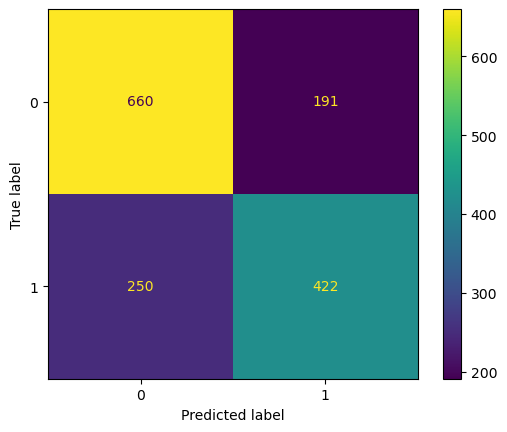

              precision    recall  f1-score   support

           0      0.725     0.776     0.750       851
           1      0.688     0.628     0.657       672

    accuracy                          0.710      1523
   macro avg      0.707     0.702     0.703      1523
weighted avg      0.709     0.710     0.709      1523



In [29]:
#Confusion matrix PA_CV12
cm=confusion_matrix(y_test_V12, predictions_V12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V12, predictions_V12, digits=3))

In [30]:
#Countvectorize, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    average = trial.suggest_categorical('average', [True, False])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    #Define the logistic regression model with the hyperparameters
    model_PA13 = PassiveAggressiveClassifier(C=C, fit_intercept=fit_intercept, max_iter=max_iter, tol=tol, loss=loss, average=average, 
                                             class_weight=class_weight)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V13_scaled = scaler.fit_transform(X_train_V13)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(model_PA13, X_train_V13_scaled, y_train_V13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_V13 = optuna.create_study(direction="maximize", study_name="PA_CV13")
study_V13.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params PA_CV13: {}".format(study_V13.best_params))
print("\nBest Accuracy PA_CV13: {}".format(study_V13.best_value))


#Train the PAC model with the optimized hyperparameters
best_params_V13 = study_V13.best_params
model_PA13 = PassiveAggressiveClassifier(**best_params_V13, n_jobs=-1)
scaler = MinMaxScaler()
X_train_V13_scaled = scaler.fit_transform(X_train_V13)
model_PA13.fit(X_train_V13_scaled, y_train_V13)


#Evaluate the performance of the model on the testing set
X_test_V13_scaled = scaler.transform(X_test_V13)
predictions_V13 = model_PA13.predict(X_test_V13_scaled)


[I 2023-05-30 01:28:16,983] A new study created in memory with name: PA_CV13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-

[I 2023-05-30 01:28:25,105] Trial 8 finished with value: 0.7026272577996716 and parameters: {'C': 9817.411355700458, 'fit_intercept': True, 'max_iter': 100, 'tol': 1.853503430047042e-06, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7026272577996716.
[I 2023-05-30 01:28:25,206] Trial 12 finished with value: 0.6397372742200328 and parameters: {'C': 129.7994528506204, 'fit_intercept': True, 'max_iter': 600, 'tol': 7.815236319101399e-06, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 8 with value: 0.7026272577996716.
[I 2023-05-30 01:28:25,294] Trial 5 finished with value: 0.6328407224958948 and parameters: {'C': 1520.7096293429477, 'fit_intercept': True, 'max_iter': 900, 'tol': 9.413644832746632e-06, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 8 with value: 0.7026272577996716.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)


[I 2023-05-30 01:28:26,311] Trial 2 finished with value: 0.6617405582922824 and parameters: {'C': 12015.054121440244, 'fit_intercept': True, 'max_iter': 900, 'tol': 1.1260096220126573e-06, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 8 with value: 0.7026272577996716.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_logunif

[I 2023-05-30 01:28:31,631] Trial 14 finished with value: 0.7566502463054187 and parameters: {'C': 0.0005319345615172396, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.005166528983304149, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:28:31,747] Trial 3 finished with value: 0.6786535303776684 and parameters: {'C': 5.283422786962878, 'fit_intercept': True, 'max_iter': 500, 'tol': 3.1306026400861293e-06, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:

[I 2023-05-30 01:28:32,409] Trial 4 finished with value: 0.6688013136288997 and parameters: {'C': 0.17454710438339133, 'fit_intercept': False, 'max_iter': 1000, 'tol': 0.004446057672359671, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:28:32,552] Trial 15 finished with value: 0.6858784893267652 and parameters: {'C': 4.550039761676128, 'fit_intercept': True, 'max_iter': 800, 'tol': 3.230868302428118e-06, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:28:33,504] Trial 19 finished with value: 0.7006568144499179 and parameters: {'C': 1521.6928427927485, 'fit_intercept': True, 'max_iter': 900, 'tol': 0.0007748787007509579, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:28:35,962] Trial 7 finished with value: 0.6538587848932677 and parameters: {'C': 426.23443748265134, 'fit_intercept': False, 'max_iter': 300, 'tol': 0.0014508744235470353, 'loss': 'hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:28:37,849] Trial 6 finished with value: 0.6417077175697865 and parameters: {'C': 0.7108496308282058, 'fit_intercept': False, 'max_iter': 400, 'tol': 1.221385480834445e-06, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:28:39,539] Trial 17 finished with value: 0.6100164203612479 and parameters: {'C': 647.5610753634921, 'fit_intercept': False, 'max_iter': 800, 'tol': 0.0022239696964877513, 'loss': 'squared_hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:28:41,088] Trial 25 finished with value: 0.4267651888341543 and parameters: {'C': 9.222388054649604e-05, 'fit_intercept': False, 'max_iter': 100, 'tol': 0.007945052838186105, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: C

[I 2023-05-30 01:28:45,842] Trial 21 finished with value: 0.641543513957307 and parameters: {'C': 1.5277495004708221, 'fit_intercept': True, 'max_iter': 400, 'tol': 2.6546638570702087e-06, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:28:47,928] Trial 20 finished with value: 0.639080459770115 and parameters: {'C': 1.5933523745766789, 'fit_intercept': True, 'max_iter': 400, 'tol': 1.2919990228038369e-05, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:28:49,001] Trial 11 finished with value: 0.6596059113300493 and parameters: {'C': 0.08063272938807879, 'fit_intercept': False, 'max_iter': 400, 'tol': 0.0001812332580619815, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: C

[I 2023-05-30 01:28:52,005] Trial 16 finished with value: 0.6679802955665025 and parameters: {'C': 0.2426674973446118, 'fit_intercept': False, 'max_iter': 200, 'tol': 4.15629328848419e-06, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:28:52,829] Trial 9 finished with value: 0.6617405582922824 and parameters: {'C': 0.052313983320427374, 'fit_intercept': True, 'max_iter': 400, 'tol': 2.6915676465047178e-05, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:

[I 2023-05-30 01:28:53,090] Trial 18 finished with value: 0.6765188834154351 and parameters: {'C': 0.16881726144695572, 'fit_intercept': False, 'max_iter': 100, 'tol': 0.0010617381528714633, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:28:53,276] Trial 22 finished with value: 0.6505747126436782 and parameters: {'C': 84850.96630281639, 'fit_intercept': False, 'max_iter': 800, 'tol': 0.0001129873493277799, 'loss': 'hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:28:54,546] Trial 30 finished with value: 0.7001642036124794 and parameters: {'C': 59589.32893638746, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0001517259630589762, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:28:55,624] Trial 24 finished with value: 0.651559934318555 and parameters: {'C': 533.4373471543026, 'fit_intercept': False, 'max_iter': 100, 'tol': 6.302145154029722e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:28:56,196] Trial 31 finished with value: 0.6908045977011493 and parameters: {'C': 94335.56917411837, 'fit_intercept': True, 'max_iter': 100, 'tol': 6.543342195171232e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: C

[I 2023-05-30 01:28:58,424] Trial 33 finished with value: 0.6973727422003284 and parameters: {'C': 34052.49546580866, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.00010233012460099424, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:28:59,148] Trial 34 finished with value: 0.6917898193760262 and parameters: {'C': 36755.53348062374, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.00018823377206153956, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: C

[I 2023-05-30 01:29:01,708] Trial 36 finished with value: 0.7021346469622332 and parameters: {'C': 9662.41643248478, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.000608761358025305, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:29:01,904] Trial 37 finished with value: 0.7072249589490969 and parameters: {'C': 4534.41087915861, 'fit_intercept': True, 'max_iter': 600, 'tol': 0.0004898193473223971, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:

[I 2023-05-30 01:29:01,972] Trial 38 finished with value: 0.7055829228243022 and parameters: {'C': 5454.394967269779, 'fit_intercept': True, 'max_iter': 600, 'tol': 0.0004702412623290773, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:29:04,941] Trial 39 finished with value: 0.7009852216748769 and parameters: {'C': 5351.914721861517, 'fit_intercept': True, 'max_iter': 600, 'tol': 0.0005963793686475734, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:29:06,938] Trial 40 finished with value: 0.6931034482758619 and parameters: {'C': 54.44429684657286, 'fit_intercept': True, 'max_iter': 600, 'tol': 0.0005502057332060573, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:

[I 2023-05-30 01:29:08,332] Trial 41 finished with value: 0.699671592775041 and parameters: {'C': 52.80249121854189, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.00046562711860868855, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:29:08,444] Trial 42 finished with value: 0.7037766830870279 and parameters: {'C': 56.285469152639564, 'fit_intercept': True, 'max_iter': 600, 'tol': 0.00029141718250160013, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:29:08,447] Trial 43 finished with value: 0.7016420361247948 and parameters: {'C': 39.94577200176072, 'fit_intercept': True, 'max_iter': 600, 'tol': 0.00028768949956426354, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\857341704.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: C

[I 2023-05-30 01:29:09,959] Trial 44 finished with value: 0.5973727422003284 and parameters: {'C': 54.99601056351999, 'fit_intercept': True, 'max_iter': 700, 'tol': 0.00038203442633775563, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:29:10,654] Trial 10 finished with value: 0.7170771756978654 and parameters: {'C': 0.004641587059129975, 'fit_intercept': True, 'max_iter': 100, 'tol': 2.2803649781071165e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:29:14,029] Trial 47 finished with value: 0.7087027914614122 and parameters: {'C': 3925.420445909283, 'fit_intercept': True, 'max_iter': 700, 'tol': 0.002599486273653573, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:29:14,203] Trial 46 finished with value: 0.7072249589490969 and parameters: {'C': 6994.934280352839, 'fit_intercept': True, 'max_iter': 700, 'tol': 0.002244158295318138, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:29:14,585] Trial 48 finished with value: 0.7022988505747126 and parameters: {'C': 3389.405319579074, 'fit_intercept': True, 'max_iter': 700, 'tol': 0.0026758022643447563, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:29:14,868] Trial 1 finished with value: 0.6637110016420362 and parameters: {'C': 0.011214425869661251, 

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn

[I 2023-05-30 01:29:26,470] Trial 13 finished with value: 0.6732348111658456 and parameters: {'C': 0.016286099715317928, 'fit_intercept': False, 'max_iter': 700, 'tol': 3.412074679795584e-06, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:29:26,669] Trial 23 finished with value: 0.7142857142857142 and parameters: {'C': 0.00230022252125198, 'fit_intercept': False, 'max_iter': 100, 'tol': 2.731118757090782e-06, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:29:28,687] Trial 26 finished with value: 0.7410509031198687 and parameters: {'C': 0.0012249458307998242, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0001602615544710464, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:29:28,835] Trial 28 finished with value: 0.7174055829228244 and parameters: {'C': 0.004730873346052165, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0001306644631769997, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:29:29,172] Trial 27 finished with value: 0.7476190476190477 and parameters: {'C': 0.0005663467529616307, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.00010334744007673413, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:29:34,163] Trial 29 finished with value: 0.7361247947454844 and parameters: {'C': 0.0015842821923204933, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0001112956147059078, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:29:35,978] Trial 32 finished with value: 0.7413793103448276 and parameters: {'C': 0.001260125721160836, 'fit_intercept': True, 'max_iter': 100, 'tol': 3.9386586651253704e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:29:57,218] Trial 35 finished with value: 0.7180623973727422 and parameters: {'C': 0.0025145205317829663, 'fit_intercept': True, 'max_iter': 200, 'tol': 3.30897531513499e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:30:03,368] Trial 45 finished with value: 0.7251231527093596 and parameters: {'C': 0.0022989594489896126, 'fit_intercept': True, 'max_iter': 700, 'tol': 0.0003014986170156105, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
[I 2023-05-30 01:30:11,727] Trial 0 finished with value: 0.7249589490968801 and parameters: {'C': 0.00033843988718468987, 'fit_intercept': False, 'max_iter': 500, 'tol': 0.0001990342816052933, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7566502463054187.
Best Params PA_CV13: {'C': 0.0005319345615172396, 'fit_intercept': True, 'max_iter': 100, 

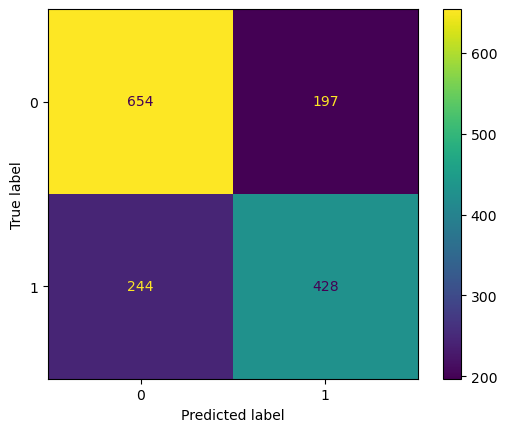

              precision    recall  f1-score   support

           0      0.728     0.769     0.748       851
           1      0.685     0.637     0.660       672

    accuracy                          0.710      1523
   macro avg      0.707     0.703     0.704      1523
weighted avg      0.709     0.710     0.709      1523



In [31]:
#Confusion matrix PA_CV13
cm=confusion_matrix(y_test_V13, predictions_V13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V13, predictions_V13, digits=3))

In [32]:
#TF-IDF Vectorizer, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    average = trial.suggest_categorical('average', [True, False])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    #Define the logistic regression model with the hyperparameters
    model_PATI12 = PassiveAggressiveClassifier(C=C, fit_intercept=fit_intercept, max_iter=max_iter, tol=tol, loss=loss, average=average, 
                                             class_weight=class_weight)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(model_PATI12, X_train_TI12_scaled, y_train_TI12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_TI12 = optuna.create_study(direction="maximize", study_name="PA_TI12")
study_TI12.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params PA_TI12: {}".format(study_TI12.best_params))
print("\nBest Accuracy PA_TI12: {}".format(study_TI12.best_value))


#Train the PAC model with the optimized hyperparameters
best_params_TI12 = study_TI12.best_params
model_PATI12 = PassiveAggressiveClassifier(**best_params_TI12, n_jobs=-1)
scaler = MinMaxScaler()
X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
model_PATI12.fit(X_train_TI12_scaled, y_train_TI12)


#Evaluate the performance of the model on the testing set
X_test_TI12_scaled = scaler.transform(X_test_TI12)
predictions_TI12 = model_PATI12.predict(X_test_TI12_scaled)

[I 2023-05-30 01:33:19,332] A new study created in memory with name: PA_TI12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)

[I 2023-05-30 01:33:24,697] Trial 2 finished with value: 0.6295566502463055 and parameters: {'C': 188.0988453389845, 'fit_intercept': True, 'max_iter': 300, 'tol': 2.1921341424966554e-06, 'loss': 'squared_hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6295566502463055.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:33:24,976] Trial 9 finished with value: 0.7077175697865353 and parameters: {'C': 1848.7062068050864, 'fit_intercept': True, 'max_iter': 200, 'tol': 1.5426311227684925e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 9 with value: 0.7077175697865353.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:33:25,384] Trial 14 finished with value: 0.7100164203612479 and parameters: {'C': 196.07203331349072, 'fit_intercept': True, 'max_iter': 800, 'tol': 6.634353313804163e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)

[I 2023-05-30 01:33:25,723] Trial 5 finished with value: 0.6646962233169129 and parameters: {'C': 9.69214830067741, 'fit_intercept': True, 'max_iter': 300, 'tol': 6.88639438241476e-05, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.
[I 2023-05-30 01:33:25,911] Trial 4 finished with value: 0.7055829228243022 and parameters: {'C': 5088.1476262848, 'fit_intercept': True, 'max_iter': 400, 'tol': 1.4738171714976024e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)

[I 2023-05-30 01:33:30,833] Trial 7 finished with value: 0.6382594417077175 and parameters: {'C': 24254.88479774401, 'fit_intercept': False, 'max_iter': 700, 'tol': 0.00016403644331672323, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.
[I 2023-05-30 01:33:31,002] Trial 10 finished with value: 0.6160919540229884 and parameters: {'C': 139.67486349873377, 'fit_intercept': False, 'max_iter': 700, 'tol': 7.457771788661778e-06, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)

[I 2023-05-30 01:33:31,080] Trial 17 finished with value: 0.7009852216748769 and parameters: {'C': 15.080270552565347, 'fit_intercept': True, 'max_iter': 800, 'tol': 5.719716720082397e-06, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.
[I 2023-05-30 01:33:32,305] Trial 11 finished with value: 0.6559934318555009 and parameters: {'C': 75546.29575789027, 'fit_intercept': False, 'max_iter': 900, 'tol': 2.1501965431398117e-06, 'loss': 'hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:33:34,453] Trial 0 finished with value: 0.6541871921182266 and parameters: {'C': 1826.1983787724191, 'fit_intercept': False, 'max_iter': 500, 'tol': 0.001979240059077345, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:33:34,711] Trial 21 finished with value: 0.6133004926108374 and parameters: {'C': 180.49819967239145, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.0021916399470762113, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:33:35,799] Trial 18 finished with value: 0.6303776683087028 and parameters: {'C': 1.2654854282260934, 'fit_intercept': True, 'max_iter': 700, 'tol': 0.0002687948993646755, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:33:37,667] Trial 6 finished with value: 0.6569786535303777 and parameters: {'C': 2732.2528908971117, 'fit_intercept': False, 'max_iter': 900, 'tol': 1.6098074992692578e-05, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702:

[I 2023-05-30 01:33:39,404] Trial 15 finished with value: 0.6582922824302134 and parameters: {'C': 0.17732678268712804, 'fit_intercept': False, 'max_iter': 900, 'tol': 7.840640743647951e-05, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:33:40,582] Trial 13 finished with value: 0.6658456486042692 and parameters: {'C': 0.1977612030433084, 'fit_intercept': True, 'max_iter': 400, 'tol': 4.4287402368755236e-05, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702:

[I 2023-05-30 01:33:51,143] Trial 24 finished with value: 0.641871921182266 and parameters: {'C': 0.30280684240878714, 'fit_intercept': False, 'max_iter': 600, 'tol': 0.00014354251432854742, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702:

[I 2023-05-30 01:33:56,896] Trial 26 finished with value: 0.6876847290640395 and parameters: {'C': 0.09634198650220824, 'fit_intercept': True, 'max_iter': 100, 'tol': 5.447515833104269e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702:

[I 2023-05-30 01:33:57,464] Trial 25 finished with value: 0.7080459770114942 and parameters: {'C': 0.02273582094254943, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.0023548736877686757, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:34:00,058] Trial 12 finished with value: 0.6753694581280787 and parameters: {'C': 0.027799966734625196, 'fit_intercept': False, 'max_iter': 300, 'tol': 0.00013430882948470212, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7100164203612479.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:34:00,735] Trial 16 finished with value: 0.7288998357963875 and parameters: {'C': 0.0007383335194643426, 'fit_intercept': False, 'max_iter': 400, 'tol': 0.001672814210777122, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 16 with value: 0.7288998357963875.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_logu

[I 2023-05-30 01:34:03,690] Trial 23 finished with value: 0.6844006568144498 and parameters: {'C': 0.006988882187052321, 'fit_intercept': False, 'max_iter': 100, 'tol': 6.0699546827238244e-05, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 16 with value: 0.7288998357963875.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:34:05,415] Trial 33 finished with value: 0.7520525451559934 and parameters: {'C': 0.002422129110456378, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.008853842827028734, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 33 with value: 0.7520525451559934.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702:

[I 2023-05-30 01:34:10,272] Trial 22 finished with value: 0.710344827586207 and parameters: {'C': 0.013457188749730573, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.0006600695675660954, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 33 with value: 0.7520525451559934.
[I 2023-05-30 01:34:10,390] Trial 19 finished with value: 0.6880131362889984 and parameters: {'C': 0.012950464588374856, 'fit_intercept': False, 'max_iter': 1000, 'tol': 0.0005390610802074489, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 33 with value: 0.7520525451559934.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:34:12,287] Trial 35 finished with value: 0.7034482758620688 and parameters: {'C': 0.0003563021347644303, 'fit_intercept': False, 'max_iter': 500, 'tol': 0.006590318555020659, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 33 with value: 0.7520525451559934.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702:

[I 2023-05-30 01:34:14,607] Trial 36 finished with value: 0.7513957307060755 and parameters: {'C': 0.00013038135356889085, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.009227936340232537, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 33 with value: 0.7520525451559934.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:34:15,618] Trial 27 finished with value: 0.7039408866995074 and parameters: {'C': 0.02218980315447704, 'fit_intercept': True, 'max_iter': 1000, 'tol': 3.139545784118697e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 33 with value: 0.7520525451559934.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:34:18,083] Trial 40 finished with value: 0.4267651888341543 and parameters: {'C': 1.967221588333973e-05, 'fit_intercept': True, 'max_iter': 400, 'tol': 0.006953731620980804, 'loss': 'hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 33 with value: 0.7520525451559934.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:34:19,563] Trial 41 finished with value: 0.5310344827586208 and parameters: {'C': 2.4487754863317244e-05, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.009863119619545805, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 33 with value: 0.7520525451559934.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:34:21,002] Trial 42 finished with value: 0.4530377668308703 and parameters: {'C': 1.4024446563160267e-05, 'fit_intercept': True, 'max_iter': 600, 'tol': 0.009991484783967492, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 33 with value: 0.7520525451559934.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_logu

[I 2023-05-30 01:34:22,870] Trial 28 finished with value: 0.7607553366174056 and parameters: {'C': 0.00017670337734197378, 'fit_intercept': True, 'max_iter': 100, 'tol': 5.422372422026077e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 28 with value: 0.7607553366174056.
[I 2023-05-30 01:34:23,230] Trial 38 finished with value: 0.7321839080459769 and parameters: {'C': 0.00033663481347934236, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.00986224509735149, 'loss': 'hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.7607553366174056.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:34:23,873] Trial 39 finished with value: 0.7254515599343186 and parameters: {'C': 0.00029140837991198685, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.008966843072702062, 'loss': 'hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.7607553366174056.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\1631933250.py:6: FutureWarning: suggest_logu

[I 2023-05-30 01:34:27,846] Trial 29 finished with value: 0.7438423645320197 and parameters: {'C': 0.002384139601984447, 'fit_intercept': True, 'max_iter': 100, 'tol': 3.2449723130497526e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 28 with value: 0.7607553366174056.
[I 2023-05-30 01:34:28,415] Trial 43 finished with value: 0.7564860426929393 and parameters: {'C': 0.00049177672829044, 'fit_intercept': True, 'max_iter': 600, 'tol': 0.009427950010019946, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.7607553366174056.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:34:29,266] Trial 30 finished with value: 0.7466338259441708 and parameters: {'C': 0.00197635713574537, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0006936797707142246, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 28 with value: 0.7607553366174056.
[I 2023-05-30 01:34:31,757] Trial 48 finished with value: 0.7558292282430213 and parameters: {'C': 0.0017756126803552456, 'fit_intercept': True, 'max_iter': 800, 'tol': 0.0040545372610401005, 'loss': 'hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.7607553366174056.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:34:33,520] Trial 46 finished with value: 0.7536945812807881 and parameters: {'C': 0.0007707394180981265, 'fit_intercept': True, 'max_iter': 800, 'tol': 0.0036278217379757944, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.7607553366174056.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:34:34,411] Trial 44 finished with value: 0.7270935960591134 and parameters: {'C': 0.0010174264671051654, 'fit_intercept': False, 'max_iter': 600, 'tol': 0.004046462253195808, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.7607553366174056.
[I 2023-05-30 01:34:35,511] Trial 31 finished with value: 0.7095238095238094 and parameters: {'C': 0.01416573213406737, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.000524457223464596, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 28 with value: 0.7607553366174056.
[I 2023-05-30 01:34:35,554] Trial 8 finished with value: 0.693103448275862 and parameters: {'C': 0.005824210052374677, 'fit_intercept': False, 'max_iter': 900, 'tol': 0.00022170703163188217, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.7607553366174056.
[I 2023-05-30 01:34:36,502] Trial 45 finished with value: 0.7226600985221

c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:34:46,730] Trial 1 finished with value: 0.7505747126436781 and parameters: {'C': 0.0008074488459093828, 'fit_intercept': True, 'max_iter': 300, 'tol': 4.2810757701613635e-06, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.7607553366174056.
[I 2023-05-30 01:34:47,824] Trial 32 finished with value: 0.710016420361248 and parameters: {'C': 0.010498847867222072, 'fit_intercept': True, 'max_iter': 1000, 'tol': 1.1930450655168472e-06, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 28 with value: 0.7607553366174056.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:35:02,656] Trial 34 finished with value: 0.7441707717569788 and parameters: {'C': 0.0009931237533054489, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.0006252880098888622, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.7607553366174056.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:35:25,967] Trial 3 finished with value: 0.7323481116584565 and parameters: {'C': 3.333458564392893e-05, 'fit_intercept': False, 'max_iter': 500, 'tol': 3.2930393155483133e-06, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 28 with value: 0.7607553366174056.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:35:51,950] Trial 20 finished with value: 0.7364532019704433 and parameters: {'C': 0.000579004190909488, 'fit_intercept': False, 'max_iter': 600, 'tol': 4.448321716034957e-05, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 28 with value: 0.7607553366174056.
Best Params PA_TI12: {'C': 0.00017670337734197378, 'fit_intercept': True, 'max_iter': 100, 'tol': 5.422372422026077e-05, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}

Best Accuracy PA_TI12: 0.7607553366174056


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


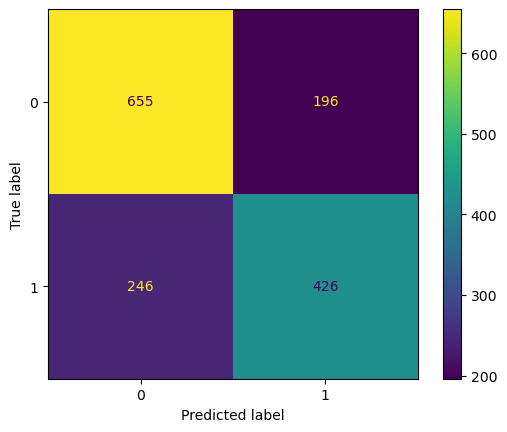

              precision    recall  f1-score   support

           0      0.727     0.770     0.748       851
           1      0.685     0.634     0.658       672

    accuracy                          0.710      1523
   macro avg      0.706     0.702     0.703      1523
weighted avg      0.708     0.710     0.708      1523



In [33]:
#Confusion matrix PA_TI12
cm=confusion_matrix(y_test_TI12, predictions_TI12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI12, predictions_TI12, digits=3))

In [34]:
#TF-IDF Vectorizer, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    average = trial.suggest_categorical('average', [True, False])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    #Define the logistic regression model with the hyperparameters
    model_PATI13 = PassiveAggressiveClassifier(C=C, fit_intercept=fit_intercept, max_iter=max_iter, tol=tol, loss=loss, average=average, 
                                             class_weight=class_weight)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(model_PATI13, X_train_TI13_scaled, y_train_TI13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_TI13 = optuna.create_study(direction="maximize", study_name="PA_TI13")
study_TI13.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params PA_TI13: {}".format(study_TI13.best_params))
print("\nBest Accuracy PA_TI13: {}".format(study_TI13.best_value))


#Train the PAC model with the optimized hyperparameters
best_params_TI13 = study_TI13.best_params
model_PATI13 = PassiveAggressiveClassifier(**best_params_TI13, n_jobs=-1)
scaler = MinMaxScaler()
X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
model_PATI13.fit(X_train_TI13_scaled, y_train_TI13)


#Evaluate the performance of the model on the testing set
X_test_TI13_scaled = scaler.transform(X_test_TI13)
predictions_TI13 = model_PATI13.predict(X_test_TI13_scaled)

[I 2023-05-30 01:39:03,263] A new study created in memory with name: PA_TI13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:

[I 2023-05-30 01:39:09,513] Trial 7 finished with value: 0.6579638752052546 and parameters: {'C': 16591.650438547716, 'fit_intercept': True, 'max_iter': 400, 'tol': 1.1210705082139261e-06, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 7 with value: 0.6579638752052546.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:09,787] Trial 11 finished with value: 0.7113300492610838 and parameters: {'C': 17692.27758401722, 'fit_intercept': True, 'max_iter': 400, 'tol': 0.00011920039399911432, 'loss': 'hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 11 with value: 0.7113300492610838.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:10,311] Trial 2 finished with value: 0.6724137931034482 and parameters: {'C': 5412.54629775887, 'fit_intercept': True, 'max_iter': 800, 'tol': 1.3680589283900106e-05, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 11 with value: 0.7113300492610838.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:11,345] Trial 4 finished with value: 0.7090311986863711 and parameters: {'C': 125.66635411986123, 'fit_intercept': True, 'max_iter': 700, 'tol': 1.1230401976197493e-06, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 11 with value: 0.7113300492610838.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:14,459] Trial 15 finished with value: 0.758456486042693 and parameters: {'C': 0.0007288041036379729, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.0069283147442245115, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:17,570] Trial 0 finished with value: 0.6331691297208538 and parameters: {'C': 45483.01979639603, 'fit_intercept': False, 'max_iter': 800, 'tol': 0.003153048717330717, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:18,568] Trial 10 finished with value: 0.7490968801313629 and parameters: {'C': 0.0055518042269540975, 'fit_intercept': True, 'max_iter': 700, 'tol': 0.0027712513548547734, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:18,814] Trial 13 finished with value: 0.6272577996715928 and parameters: {'C': 13310.341535771746, 'fit_intercept': False, 'max_iter': 100, 'tol': 0.00018810543604184316, 'loss': 'squared_hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_logunif

[I 2023-05-30 01:39:19,679] Trial 3 finished with value: 0.6596059113300493 and parameters: {'C': 19596.24968103122, 'fit_intercept': False, 'max_iter': 900, 'tol': 0.000502406978552656, 'loss': 'squared_hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.758456486042693.
[I 2023-05-30 01:39:19,704] Trial 6 finished with value: 0.6648604269293925 and parameters: {'C': 2.9175706161246944, 'fit_intercept': False, 'max_iter': 200, 'tol': 0.0001656485691672352, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:39:20,295] Trial 1 finished with value: 0.6349753694581282 and parameters: {'C': 6603.254641828469, 'fit_intercept': False, 'max_iter': 100, 'tol': 1.2086054449267189e-06, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:39:23,928] Trial 18 finished with value: 0.6389162561576354 and parameters: {'C': 0.7352590743610395, 'fit_intercept': False, 'max_iter': 600, 'tol': 0.00434439041598645, 'loss': 'squared_hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.758456486042693.
[I 2023-05-30 01:39:24,153] Trial 16 finished with value: 0.6880131362889984 and parameters: {'C': 2.8757926159184293, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.0032547015562223343, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:

[I 2023-05-30 01:39:24,725] Trial 5 finished with value: 0.6551724137931034 and parameters: {'C': 21978.030376122246, 'fit_intercept': False, 'max_iter': 1000, 'tol': 8.987034619196218e-06, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:25,072] Trial 25 finished with value: 0.5732348111658456 and parameters: {'C': 1.0247081378202342e-05, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.006820615572781835, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:26,410] Trial 24 finished with value: 0.5732348111658456 and parameters: {'C': 1.0949682128349295e-05, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.006558515837737415, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: C

[I 2023-05-30 01:39:29,408] Trial 9 finished with value: 0.6635467980295566 and parameters: {'C': 0.5334845201884577, 'fit_intercept': False, 'max_iter': 800, 'tol': 0.00038176660746793323, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:31,129] Trial 14 finished with value: 0.7426929392446634 and parameters: {'C': 0.0019271963107509247, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.002270053148154744, 'loss': 'squared_hinge', 'average': False, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:

[I 2023-05-30 01:39:34,124] Trial 21 finished with value: 0.7178981937602626 and parameters: {'C': 0.05068438295793546, 'fit_intercept': True, 'max_iter': 200, 'tol': 0.00814642043516624, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.
[I 2023-05-30 01:39:34,224] Trial 26 finished with value: 0.7568144499178981 and parameters: {'C': 0.0004707877342720593, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.00876503888784364, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:34,443] Trial 30 finished with value: 0.757799671592775 and parameters: {'C': 0.000971179973922145, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.008790876698680242, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:36,539] Trial 29 finished with value: 0.7573070607553365 and parameters: {'C': 0.00042862462470596654, 'fit_intercept': True, 'max_iter': 400, 'tol': 0.00979805916766621, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:39:37,639] Trial 28 finished with value: 0.7577996715927751 and parameters: {'C': 0.00029226797310967425, 'fit_intercept': True, 'max_iter': 400, 'tol': 0.009592225721316518, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: C

[I 2023-05-30 01:39:41,258] Trial 27 finished with value: 0.7571428571428571 and parameters: {'C': 0.0002894581210715527, 'fit_intercept': True, 'max_iter': 400, 'tol': 0.00836843773097785, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:39:46,530] Trial 36 finished with value: 0.7561576354679802 and parameters: {'C': 0.0003396706345810071, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.00990534862663786, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:48,007] Trial 32 finished with value: 0.7541871921182266 and parameters: {'C': 0.0009725605921839442, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.0012301520726317686, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:48,347] Trial 31 finished with value: 0.7555008210180624 and parameters: {'C': 0.0007084472479223079, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.0014977872424581193, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:39:49,237] Trial 34 finished with value: 0.757799671592775 and parameters: {'C': 0.0009728120652763105, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.0014981272943516493, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 15 with value: 0.758456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:52,454] Trial 35 finished with value: 0.7589490968801313 and parameters: {'C': 0.0005531256652099771, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.0011684867996849275, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: C

[I 2023-05-30 01:39:54,471] Trial 17 finished with value: 0.7280788177339902 and parameters: {'C': 0.00032649068053928684, 'fit_intercept': False, 'max_iter': 100, 'tol': 0.0002933872173747404, 'loss': 'squared_hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 35 with value: 0.7589490968801313.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:39:57,321] Trial 19 finished with value: 0.7584564860426928 and parameters: {'C': 0.0001433219572653267, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0002666926176569606, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.
[I 2023-05-30 01:40:01,287] Trial 37 finished with value: 0.7561576354679802 and parameters: {'C': 0.0002921949484657197, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.0011697199860592786, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 35 with value: 0.7589490968801313.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:40:04,090] Trial 44 finished with value: 0.5732348111658456 and parameters: {'C': 5.931549861403167e-05, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.003834418073325546, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:40:06,914] Trial 33 finished with value: 0.7523809523809524 and parameters: {'C': 0.001419324342649487, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.0008850355858203793, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 35 with value: 0.7589490968801313.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_1180\239396777.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)


[I 2023-05-30 01:40:09,460] Trial 40 finished with value: 0.719376026272578 and parameters: {'C': 0.01864208179992002, 'fit_intercept': True, 'max_iter': 600, 'tol': 0.001721676835929686, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn

[I 2023-05-30 01:40:24,344] Trial 12 finished with value: 0.6779967159277505 and parameters: {'C': 0.004530817697642338, 'fit_intercept': False, 'max_iter': 200, 'tol': 6.210073357698954e-05, 'loss': 'squared_hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 35 with value: 0.7589490968801313.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:40:43,572] Trial 38 finished with value: 0.758128078817734 and parameters: {'C': 7.567650136989558e-05, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.0011907713712709337, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 35 with value: 0.7589490968801313.
[I 2023-05-30 01:40:43,979] Trial 41 finished with value: 0.7573070607553365 and parameters: {'C': 8.20069439525102e-05, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0015092672967043383, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.
[I 2023-05-30 01:40:45,618] Trial 42 finished with value: 0.7574712643678161 and parameters: {'C': 8.602491094991782e-05, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0012287139356473346, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:40:49,744] Trial 39 finished with value: 0.7566502463054188 and parameters: {'C': 6.279898243566742e-05, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.001217379444150479, 'loss': 'hinge', 'average': False, 'class_weight': 'balanced'}. Best is trial 35 with value: 0.7589490968801313.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:40:57,151] Trial 22 finished with value: 0.7541871921182267 and parameters: {'C': 0.00010957670992621362, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.00019712062874011676, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:40:58,252] Trial 48 finished with value: 0.7584564860426929 and parameters: {'C': 6.578622580189758e-05, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0007606468544411478, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.
[I 2023-05-30 01:41:00,901] Trial 43 finished with value: 0.7574712643678161 and parameters: {'C': 5.511109881583928e-05, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0007241961363375276, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:41:01,185] Trial 49 finished with value: 0.7500821018062398 and parameters: {'C': 5.073978508972329e-05, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0006465792218163591, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.
[I 2023-05-30 01:41:02,283] Trial 45 finished with value: 0.758456486042693 and parameters: {'C': 4.8855683976549795e-05, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0009891262642317763, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.
[I 2023-05-30 01:41:03,105] Trial 46 finished with value: 0.7579638752052545 and parameters: {'C': 4.9761801053177526e-05, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0010425069709436698, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:41:09,655] Trial 8 finished with value: 0.72183908045977 and parameters: {'C': 0.0028492220750306915, 'fit_intercept': True, 'max_iter': 500, 'tol': 7.84362897553852e-06, 'loss': 'squared_hinge', 'average': True, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.
[I 2023-05-30 01:41:10,395] Trial 47 finished with value: 0.7573070607553366 and parameters: {'C': 4.948045305969431e-05, 'fit_intercept': True, 'max_iter': 300, 'tol': 0.0006504181260453324, 'loss': 'hinge', 'average': False, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn

[I 2023-05-30 01:42:08,484] Trial 23 finished with value: 0.7528735632183909 and parameters: {'C': 0.0004593755792655965, 'fit_intercept': True, 'max_iter': 500, 'tol': 3.959426596388472e-05, 'loss': 'hinge', 'average': True, 'class_weight': 'balanced'}. Best is trial 35 with value: 0.7589490968801313.


c:\Users\Iuliia\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[I 2023-05-30 01:42:20,660] Trial 20 finished with value: 0.7062397372742202 and parameters: {'C': 0.004763884968921792, 'fit_intercept': False, 'max_iter': 600, 'tol': 1.3762156232060197e-06, 'loss': 'hinge', 'average': True, 'class_weight': None}. Best is trial 35 with value: 0.7589490968801313.
Best Params PA_TI13: {'C': 0.0005531256652099771, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.0011684867996849275, 'loss': 'hinge', 'average': False, 'class_weight': None}

Best Accuracy PA_TI13: 0.7589490968801313


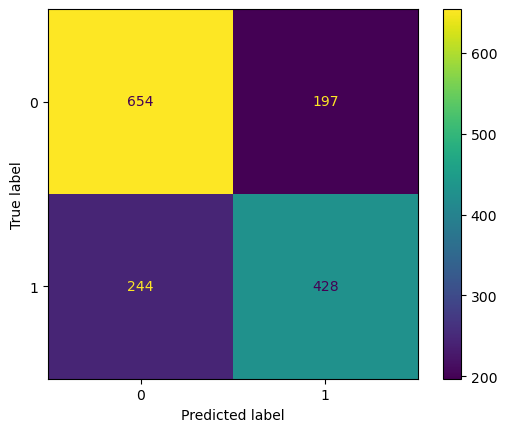

              precision    recall  f1-score   support

           0      0.728     0.769     0.748       851
           1      0.685     0.637     0.660       672

    accuracy                          0.710      1523
   macro avg      0.707     0.703     0.704      1523
weighted avg      0.709     0.710     0.709      1523



In [35]:
#Confusion matrix PA_TI13
cm=confusion_matrix(y_test_TI13, predictions_TI13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI13, predictions_TI13, digits=3))

**XGBoost**

In [73]:
#Countvectorize, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),

        #tree booster parametrs
        'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'tree_method': 'gpu_hist',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
    
        #learning parametrs
        'objective': 'binary:logistic'
          
    }

    
    #Define the XGB model with the hyperparameters
    xgb_V12 = XGBClassifier(**params)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V12_scaled = scaler.fit_transform(X_train_V12)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(xgb_V12, X_train_V12_scaled, y_train_V12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_V12 = optuna.create_study(direction="maximize", study_name="XGB_CV12")
study_V12.optimize(objective, n_trials=20, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params XGB_CV12: {}".format(study_V12.best_params))
print("\nBest Accuracy XGB_CV12: {}".format(study_V12.best_value))


#Train the XGB model with the optimized hyperparameters
best_params_V12 = study_V12.best_params
xgb_v12 = XGBClassifier(**best_params_V12, n_jobs=-1)
scaler = MinMaxScaler()
X_train_V12_scaled = scaler.fit_transform(X_train_V12)
xgb_v12.fit(X_train_V12_scaled, y_train_V12)


#Evaluate the performance of the model on the testing set
X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_V12 = xgb_v12.predict(X_test_V12_scaled)

[I 2023-05-30 11:35:50,241] A new study created in memory with name: XGB_CV12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1875773572.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1875773572.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1875773572.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_lo

[I 2023-05-30 11:37:28,037] Trial 13 finished with value: 0.7650246305418719 and parameters: {'n_estimators': 113, 'gamma': 9.622565760906994, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7469475674716275, 'reg_lambda': 0.019749459203614473, 'reg_alpha': 0.0014269329434473093, 'colsample_bytree': 0.6708208752286495, 'learning_rate': 0.39741788696037506}. Best is trial 13 with value: 0.7650246305418719.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1875773572.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 11:39:07,709] Trial 14 finished with value: 0.7532019704433498 and parameters: {'n_estimators': 95, 'gamma': 0.05003086135456758, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.7270624242766022, 'reg_lambda': 0.3429971692425068, 'reg_alpha': 0.02010781395031454, 'colsample_bytree': 0.8878247041738716, 'learning_rate': 0.1802029005086072}. Best is trial 13 with value: 0.7650246305418719.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1875773572.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 11:39:29,836] Trial 3 finished with value: 0.7453201970443349 and parameters: {'n_estimators': 321, 'gamma': 5.571938187364032, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7836672094407502, 'reg_lambda': 0.21988282137234427, 'reg_alpha': 0.003750087987707496, 'colsample_bytree': 0.9515314842003164, 'learning_rate': 0.9597517306559922}. Best is trial 13 with value: 0.7650246305418719.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1875773572.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 11:40:43,976] Trial 15 finished with value: 0.7658456486042693 and parameters: {'n_estimators': 482, 'gamma': 2.190274783345822, 'max_depth': 1, 'min_child_weight': 7, 'subsample': 0.5717876255296941, 'reg_lambda': 0.07847769148541292, 'reg_alpha': 0.002595806173759346, 'colsample_bytree': 0.6428125659385613, 'learning_rate': 0.4113018810319787}. Best is trial 15 with value: 0.7658456486042693.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1875773572.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 11:41:07,894] Trial 10 finished with value: 0.7586206896551724 and parameters: {'n_estimators': 412, 'gamma': 4.513970515405392, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.5561990291090217, 'reg_lambda': 0.20755530968016914, 'reg_alpha': 0.020603808310445507, 'colsample_bytree': 0.7920481791925786, 'learning_rate': 0.30234695237572434}. Best is trial 15 with value: 0.7658456486042693.
[I 2023-05-30 11:41:22,700] Trial 12 finished with value: 0.7711001642036125 and parameters: {'n_estimators': 132, 'gamma': 1.977423739203426, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.7915497585723386, 'reg_lambda': 0.00486618753701216, 'reg_alpha': 0.007172210586951742, 'colsample_bytree': 0.5637912147790702, 'learning_rate': 0.01628506192779554}. Best is trial 12 with value: 0.7711001642036125.
[I 2023-05-30 11:41:29,379] Trial 2 finished with value: 0.7600985221674877 and parameters: {'n_estimators': 358, 'gamma': 0.04820638454109174, 'max_depth': 3, 'min_child_we

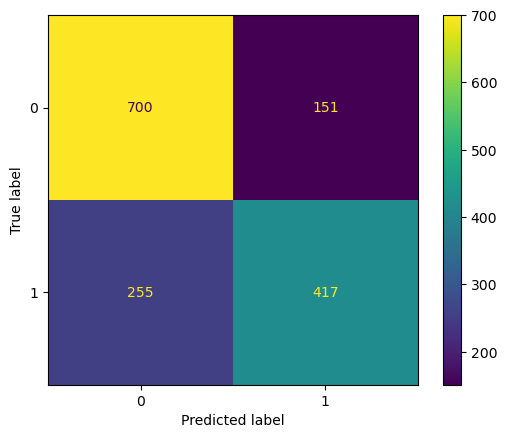

              precision    recall  f1-score   support

           0      0.733     0.823     0.775       851
           1      0.734     0.621     0.673       672

    accuracy                          0.733      1523
   macro avg      0.734     0.722     0.724      1523
weighted avg      0.734     0.733     0.730      1523



In [74]:
#Confusion matrix XGB_CV12
cm=confusion_matrix(y_test_V12, predictions_V12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V12, predictions_V12, digits=3))

In [75]:
#Countvectorize, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),

        #tree booster parametrs
        'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'tree_method': 'gpu_hist',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
    
        #learning parametrs
        'objective': 'binary:logistic'
          
    }

    
    #Define the XGB model with the hyperparameters
    xgb_V13 = XGBClassifier(**params)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V13_scaled = scaler.fit_transform(X_train_V13)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(xgb_V13, X_train_V13_scaled, y_train_V13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_V13 = optuna.create_study(direction="maximize", study_name="XGB_CV13")
study_V13.optimize(objective, n_trials=20, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params XGB_CV13: {}".format(study_V13.best_params))
print("\nBest Accuracy XGB_CV13: {}".format(study_V13.best_value))


#Train the XGB model with the optimized hyperparameters
best_params_V13 = study_V13.best_params
xgb_v13 = XGBClassifier(**best_params_V13, n_jobs=-1)
scaler = MinMaxScaler()
X_train_V13_scaled = scaler.fit_transform(X_train_V13)
xgb_v13.fit(X_train_V13_scaled, y_train_V13)


#Evaluate the performance of the model on the testing set
X_test_V13_scaled = scaler.transform(X_test_V13)
predictions_V13 = xgb_v13.predict(X_test_V13_scaled)

[I 2023-05-30 11:52:08,892] A new study created in memory with name: XGB_CV13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3859995269.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3859995269.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3859995269.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_lo

[I 2023-05-30 11:54:04,593] Trial 13 finished with value: 0.7615763546798029 and parameters: {'n_estimators': 96, 'gamma': 0.05833902238756626, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.6467122384062707, 'reg_lambda': 0.006905472863511623, 'reg_alpha': 0.003779118711721551, 'colsample_bytree': 0.8733479393243435, 'learning_rate': 0.05648432781828479}. Best is trial 13 with value: 0.7615763546798029.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3859995269.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 11:54:05,292] Trial 0 finished with value: 0.7683087027914614 and parameters: {'n_estimators': 74, 'gamma': 4.454867595307714, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.7990625375497458, 'reg_lambda': 0.004961006372875796, 'reg_alpha': 0.10319284508803925, 'colsample_bytree': 0.839233247749636, 'learning_rate': 0.24500050957706748}. Best is trial 0 with value: 0.7683087027914614.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3859995269.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 11:54:27,797] Trial 9 finished with value: 0.7571428571428571 and parameters: {'n_estimators': 104, 'gamma': 1.113093903650205, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.9793935765014783, 'reg_lambda': 0.08131819095981424, 'reg_alpha': 0.007184276486502448, 'colsample_bytree': 0.5330052898125184, 'learning_rate': 0.684985161345098}. Best is trial 0 with value: 0.7683087027914614.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3859995269.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 11:55:05,203] Trial 2 finished with value: 0.7648604269293924 and parameters: {'n_estimators': 109, 'gamma': 1.964805137827167, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.6829006610126271, 'reg_lambda': 0.09564954760763363, 'reg_alpha': 0.00556070726392882, 'colsample_bytree': 0.6672138295853479, 'learning_rate': 0.1723801492590489}. Best is trial 0 with value: 0.7683087027914614.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3859995269.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 11:55:09,564] Trial 16 finished with value: 0.7558292282430213 and parameters: {'n_estimators': 62, 'gamma': 2.2259103861390233, 'max_depth': 3, 'min_child_weight': 0, 'subsample': 0.6304196126130591, 'reg_lambda': 0.7170705719633776, 'reg_alpha': 0.7354472710155049, 'colsample_bytree': 0.6249097690304883, 'learning_rate': 0.5743386735619342}. Best is trial 0 with value: 0.7683087027914614.
[I 2023-05-30 11:55:23,250] Trial 10 finished with value: 0.7637110016420362 and parameters: {'n_estimators': 233, 'gamma': 9.760460983978293, 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.9026958589931409, 'reg_lambda': 0.4749710533618451, 'reg_alpha': 0.016890624669488933, 'colsample_bytree': 0.8220806262842748, 'learning_rate': 0.22274651500747492}. Best is trial 0 with value: 0.7683087027914614.
[I 2023-05-30 11:56:26,215] Trial 4 finished with value: 0.7343185550082102 and parameters: {'n_estimators': 407, 'gamma': 4.943469474864675, 'max_depth': 1, 'min_child_weight': 1, 

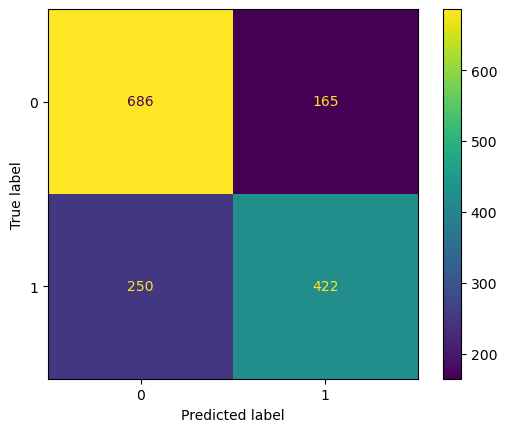

              precision    recall  f1-score   support

           0      0.733     0.806     0.768       851
           1      0.719     0.628     0.670       672

    accuracy                          0.728      1523
   macro avg      0.726     0.717     0.719      1523
weighted avg      0.727     0.728     0.725      1523



In [76]:
#Confusion matrix XGB_CV13
cm=confusion_matrix(y_test_V13, predictions_V13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V13, predictions_V13, digits=3))

In [77]:
#TF-IDF Vectorizer, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),

        #tree booster parametrs
        'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'tree_method': 'gpu_hist',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
    
        #learning parametrs
        'objective': 'binary:logistic'
          
    }

    
    #Define the XGB model with the hyperparameters
    xgb_TI12 = XGBClassifier(**params)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(xgb_TI12, X_train_TI12_scaled, y_train_TI12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_TI12 = optuna.create_study(direction="maximize", study_name="XGB_TI12")
study_TI12.optimize(objective, n_trials=30, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params XGB_TI12: {}".format(study_TI12.best_params))
print("\nBest Accuracy XGB_TI12: {}".format(study_TI12.best_value))


#Train the XGB model with the optimized hyperparameters
best_params_TI12 = study_TI12.best_params
xgb_TI12 = XGBClassifier(**best_params_TI12, n_jobs=-1)
scaler = MinMaxScaler()
X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
xgb_TI12.fit(X_train_TI12_scaled, y_train_TI12)


#Evaluate the performance of the model on the testing set
X_test_TI12_scaled = scaler.transform(X_test_TI12)
predictions_TI12 = xgb_TI12.predict(X_test_TI12_scaled)

[I 2023-05-30 12:05:31,492] A new study created in memory with name: XGB_TI12


CPU times: total: 0 ns
Wall time: 1 ms


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_lo

[I 2023-05-30 12:06:57,721] Trial 3 finished with value: 0.7592775041050903 and parameters: {'n_estimators': 67, 'gamma': 0.21544736520839153, 'max_depth': 1, 'min_child_weight': 0, 'subsample': 0.7778545202910997, 'reg_lambda': 0.35790826751912164, 'reg_alpha': 0.14498292040116237, 'colsample_bytree': 0.6060726234637617, 'learning_rate': 0.4838707347649768}. Best is trial 3 with value: 0.7592775041050903.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:07:49,162] Trial 12 finished with value: 0.7630541871921181 and parameters: {'n_estimators': 147, 'gamma': 0.07184454320386922, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.8356330016863217, 'reg_lambda': 0.018877427030158593, 'reg_alpha': 0.012110761032579203, 'colsample_bytree': 0.6312209251518078, 'learning_rate': 0.27513169761825085}. Best is trial 12 with value: 0.7630541871921181.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:08:04,237] Trial 0 finished with value: 0.7249589490968802 and parameters: {'n_estimators': 56, 'gamma': 0.3248708544521034, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.5232786333679922, 'reg_lambda': 0.04217648703034499, 'reg_alpha': 0.025215837131690854, 'colsample_bytree': 0.7102806022978108, 'learning_rate': 0.7424293579027254}. Best is trial 12 with value: 0.7630541871921181.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:08:21,964] Trial 1 finished with value: 0.7630541871921183 and parameters: {'n_estimators': 95, 'gamma': 0.3086924386747521, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8516000281838866, 'reg_lambda': 0.07914509248339038, 'reg_alpha': 0.00792598882653446, 'colsample_bytree': 0.5270321527004693, 'learning_rate': 0.22307123817075467}. Best is trial 1 with value: 0.7630541871921183.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:09:16,363] Trial 10 finished with value: 0.7673234811165845 and parameters: {'n_estimators': 290, 'gamma': 1.0824224592892606, 'max_depth': 1, 'min_child_weight': 6, 'subsample': 0.5645517037248231, 'reg_lambda': 0.0015693406295717125, 'reg_alpha': 0.07070654493857971, 'colsample_bytree': 0.5302388730107943, 'learning_rate': 0.23882427469484735}. Best is trial 10 with value: 0.7673234811165845.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:09:32,945] Trial 9 finished with value: 0.7499178981937603 and parameters: {'n_estimators': 214, 'gamma': 0.8559187003979469, 'max_depth': 9, 'min_child_weight': 0, 'subsample': 0.9999548112365167, 'reg_lambda': 0.5124023981907605, 'reg_alpha': 0.04581450801530853, 'colsample_bytree': 0.5808010151208918, 'learning_rate': 0.5817471029780823}. Best is trial 10 with value: 0.7673234811165845.
[I 2023-05-30 12:09:33,019] Trial 6 finished with value: 0.7218390804597702 and parameters: {'n_estimators': 137, 'gamma': 0.018177915866622003, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.8777597237699457, 'reg_lambda': 0.04287044485892097, 'reg_alpha': 0.003723674091667602, 'colsample_bytree': 0.9854556958125866, 'learning_rate': 0.8558715627687175}. Best is trial 10 with value: 0.7673234811165845.
[I 2023-05-30 12:10:09,697] Trial 13 finished with value: 0.7415435139573071 and parameters: {'n_estimators': 219, 'gamma': 0.08619681486196025, 'max_depth': 4, 'min_child_weig

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:10:18,491] Trial 7 finished with value: 0.765353037766831 and parameters: {'n_estimators': 387, 'gamma': 4.326667400929925, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.9544254103293817, 'reg_lambda': 0.17563614391760524, 'reg_alpha': 0.0020182899207436635, 'colsample_bytree': 0.9265214685258374, 'learning_rate': 0.4859881585552224}. Best is trial 10 with value: 0.7673234811165845.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:10:34,141] Trial 8 finished with value: 0.7651888341543513 and parameters: {'n_estimators': 332, 'gamma': 1.507351170718679, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.592939440605946, 'reg_lambda': 0.29291322476819437, 'reg_alpha': 0.23962091332237404, 'colsample_bytree': 0.8650470206308007, 'learning_rate': 0.17884095099911476}. Best is trial 10 with value: 0.7673234811165845.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:10:45,744] Trial 15 finished with value: 0.7334975369458129 and parameters: {'n_estimators': 336, 'gamma': 0.015716788484993877, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6281754583989081, 'reg_lambda': 0.20812602200397032, 'reg_alpha': 0.007907386476798353, 'colsample_bytree': 0.7168061257166201, 'learning_rate': 0.42647825724759747}. Best is trial 10 with value: 0.7673234811165845.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:11:46,938] Trial 2 finished with value: 0.7326765188834155 and parameters: {'n_estimators': 406, 'gamma': 3.2039962901583188, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7598483577008011, 'reg_lambda': 0.4815200746345546, 'reg_alpha': 0.6256860857796681, 'colsample_bytree': 0.646911833220716, 'learning_rate': 0.9814343996911058}. Best is trial 10 with value: 0.7673234811165845.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:12:38,164] Trial 23 finished with value: 0.7507389162561576 and parameters: {'n_estimators': 53, 'gamma': 1.6931834763206763, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.828934483959144, 'reg_lambda': 0.2381456026690965, 'reg_alpha': 0.26530679425510334, 'colsample_bytree': 0.7976467418665975, 'learning_rate': 0.581828112168869}. Best is trial 10 with value: 0.7673234811165845.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:13:46,991] Trial 21 finished with value: 0.7272577996715928 and parameters: {'n_estimators': 97, 'gamma': 0.09414157669975416, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.9759433147250544, 'reg_lambda': 0.005700665876337153, 'reg_alpha': 0.12705332631707356, 'colsample_bytree': 0.8195507698123264, 'learning_rate': 0.6819691018765378}. Best is trial 10 with value: 0.7673234811165845.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1222245328.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:14:39,089] Trial 22 finished with value: 0.7589490968801313 and parameters: {'n_estimators': 152, 'gamma': 2.929664048133518, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.5219756326208103, 'reg_lambda': 0.06044608581677001, 'reg_alpha': 0.05576251740741905, 'colsample_bytree': 0.7856602265631842, 'learning_rate': 0.32621974213052074}. Best is trial 10 with value: 0.7673234811165845.
[I 2023-05-30 12:14:46,279] Trial 18 finished with value: 0.770935960591133 and parameters: {'n_estimators': 294, 'gamma': 0.013626041051833768, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7415416803099051, 'reg_lambda': 0.729133387528537, 'reg_alpha': 0.007661740275043155, 'colsample_bytree': 0.7917123135776081, 'learning_rate': 0.08025363745447199}. Best is trial 18 with value: 0.770935960591133.
[I 2023-05-30 12:15:12,994] Trial 17 finished with value: 0.7512315270935961 and parameters: {'n_estimators': 491, 'gamma': 5.779861494614215, 'max_depth': 6, 'min_child_weigh

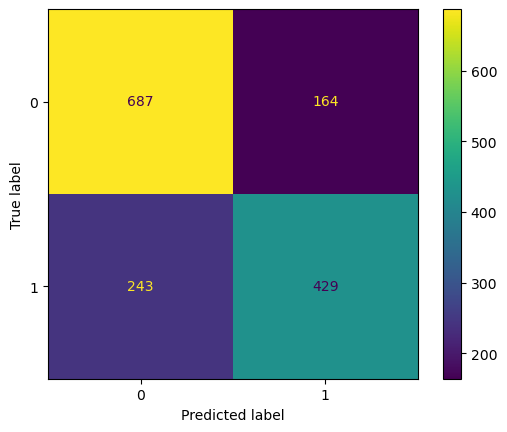

              precision    recall  f1-score   support

           0      0.739     0.807     0.771       851
           1      0.723     0.638     0.678       672

    accuracy                          0.733      1523
   macro avg      0.731     0.723     0.725      1523
weighted avg      0.732     0.733     0.730      1523



In [78]:
#Confusion matrix XGB_TI12
cm=confusion_matrix(y_test_TI12, predictions_TI12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI12, predictions_TI12, digits=3))

In [79]:
#TF-IDF Vectorizer, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),

        #tree booster parametrs
        'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'tree_method': 'gpu_hist',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
    
        #learning parametrs
        'objective': 'binary:logistic'
          
    }

    
    #Define the XGB model with the hyperparameters
    xgb_TI13 = XGBClassifier(**params)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(xgb_TI13, X_train_TI13_scaled, y_train_TI13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_TI13 = optuna.create_study(direction="maximize", study_name="XGB_TI13")
study_TI13.optimize(objective, n_trials=30, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params XGB_TI13: {}".format(study_TI13.best_params))
print("\nBest Accuracy XGB_TI13: {}".format(study_TI13.best_value))


#Train the XGB model with the optimized hyperparameters
best_params_TI13 = study_TI13.best_params
xgb_TI13 = XGBClassifier(**best_params_TI13, n_jobs=-1)
scaler = MinMaxScaler()
X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
xgb_TI13.fit(X_train_TI13_scaled, y_train_TI13)


#Evaluate the performance of the model on the testing set
X_test_TI13_scaled = scaler.transform(X_test_TI13)
predictions_TI13 = xgb_TI13.predict(X_test_TI13_scaled)

[I 2023-05-30 12:21:27,995] A new study created in memory with name: XGB_TI13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_lo

[I 2023-05-30 12:25:14,869] Trial 1 finished with value: 0.7574712643678161 and parameters: {'n_estimators': 184, 'gamma': 0.3008084528418228, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7946259358951897, 'reg_lambda': 0.48804606815144186, 'reg_alpha': 0.009335157477421422, 'colsample_bytree': 0.8897081466387493, 'learning_rate': 0.35610493271331634}. Best is trial 1 with value: 0.7574712643678161.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:25:16,459] Trial 12 finished with value: 0.7707717569786535 and parameters: {'n_estimators': 141, 'gamma': 0.09818826046908534, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.7274475910433563, 'reg_lambda': 0.008613576756512623, 'reg_alpha': 0.1819080467627342, 'colsample_bytree': 0.832772167502744, 'learning_rate': 0.03159039993547051}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:25:18,478] Trial 2 finished with value: 0.7553366174055829 and parameters: {'n_estimators': 256, 'gamma': 0.15916974573972456, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.6384563370909713, 'reg_lambda': 0.5907761373255866, 'reg_alpha': 0.003771881867260307, 'colsample_bytree': 0.9738954681601617, 'learning_rate': 0.27952004346810894}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:25:20,904] Trial 14 finished with value: 0.6975369458128079 and parameters: {'n_estimators': 77, 'gamma': 0.5557215156232732, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.5590362639076212, 'reg_lambda': 0.00842843830702818, 'reg_alpha': 0.002819841429891942, 'colsample_bytree': 0.8057086953580419, 'learning_rate': 0.9345029246420141}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:25:47,453] Trial 7 finished with value: 0.7628899835796388 and parameters: {'n_estimators': 389, 'gamma': 1.555147232530252, 'max_depth': 1, 'min_child_weight': 4, 'subsample': 0.9490881600399247, 'reg_lambda': 0.005996572401211171, 'reg_alpha': 0.6392729991308929, 'colsample_bytree': 0.8397000049427642, 'learning_rate': 0.7024414611818947}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:26:08,916] Trial 15 finished with value: 0.7600985221674877 and parameters: {'n_estimators': 248, 'gamma': 0.7364963789898178, 'max_depth': 3, 'min_child_weight': 0, 'subsample': 0.6335941335047615, 'reg_lambda': 0.06841984985673644, 'reg_alpha': 0.0061568774190638035, 'colsample_bytree': 0.806438260415059, 'learning_rate': 0.142721791692153}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:26:22,837] Trial 0 finished with value: 0.7505747126436781 and parameters: {'n_estimators': 191, 'gamma': 0.20405276645344486, 'max_depth': 6, 'min_child_weight': 0, 'subsample': 0.8947888292520311, 'reg_lambda': 0.4825388766365842, 'reg_alpha': 0.0019806722371863653, 'colsample_bytree': 0.5384315931750093, 'learning_rate': 0.30116539458974756}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:26:38,610] Trial 4 finished with value: 0.722167487684729 and parameters: {'n_estimators': 491, 'gamma': 0.0896633589418814, 'max_depth': 1, 'min_child_weight': 0, 'subsample': 0.6006999550485219, 'reg_lambda': 0.0021812013100956026, 'reg_alpha': 0.23193015834163136, 'colsample_bytree': 0.9336809711036366, 'learning_rate': 0.9181269763680667}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:27:28,944] Trial 8 finished with value: 0.7502463054187192 and parameters: {'n_estimators': 427, 'gamma': 2.456464786597126, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9779891557250056, 'reg_lambda': 0.4206353237647479, 'reg_alpha': 0.065489637259974, 'colsample_bytree': 0.6895994556405373, 'learning_rate': 0.6437630987232503}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:27:38,419] Trial 9 finished with value: 0.7216748768472907 and parameters: {'n_estimators': 370, 'gamma': 0.6212766077343038, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9945399782208608, 'reg_lambda': 0.02368135513578549, 'reg_alpha': 0.09635811251826949, 'colsample_bytree': 0.5244841704418661, 'learning_rate': 0.9852156786918594}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:27:55,390] Trial 5 finished with value: 0.7481116584564861 and parameters: {'n_estimators': 443, 'gamma': 2.7131703162562637, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.806487741733701, 'reg_lambda': 0.005826193404880754, 'reg_alpha': 0.19184944230069456, 'colsample_bytree': 0.6189722387163656, 'learning_rate': 0.9366167475742159}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:28:28,471] Trial 16 finished with value: 0.7316912972085386 and parameters: {'n_estimators': 171, 'gamma': 3.913715496421077, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.5279409198320765, 'reg_lambda': 0.07611836762363204, 'reg_alpha': 0.022374410968579585, 'colsample_bytree': 0.6501355001120208, 'learning_rate': 0.6897173635221172}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:29:21,321] Trial 18 finished with value: 0.7497536945812808 and parameters: {'n_estimators': 180, 'gamma': 0.7768046720572802, 'max_depth': 4, 'min_child_weight': 0, 'subsample': 0.7387571715847913, 'reg_lambda': 0.4433523182503032, 'reg_alpha': 0.10180231307543483, 'colsample_bytree': 0.8416859839762678, 'learning_rate': 0.2686955875463188}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:29:43,746] Trial 22 finished with value: 0.7650246305418719 and parameters: {'n_estimators': 231, 'gamma': 0.22808032137459736, 'max_depth': 1, 'min_child_weight': 9, 'subsample': 0.9131465599720427, 'reg_lambda': 0.0011897031726786813, 'reg_alpha': 0.008193866702028754, 'colsample_bytree': 0.845461299873643, 'learning_rate': 0.6976590349022974}. Best is trial 12 with value: 0.7707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\1651816378.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 10),


[I 2023-05-30 12:29:45,178] Trial 23 finished with value: 0.7633825944170771 and parameters: {'n_estimators': 132, 'gamma': 0.10986118279031319, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7936273661960689, 'reg_lambda': 0.7995977452082375, 'reg_alpha': 0.16606010481413214, 'colsample_bytree': 0.700493052823385, 'learning_rate': 0.010313253868535125}. Best is trial 12 with value: 0.7707717569786535.
[I 2023-05-30 12:29:57,908] Trial 3 finished with value: 0.757799671592775 and parameters: {'n_estimators': 414, 'gamma': 0.9806782419858701, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.9263692837473803, 'reg_lambda': 0.008733010610225205, 'reg_alpha': 0.013873822846791263, 'colsample_bytree': 0.9415398376668115, 'learning_rate': 0.1282300587112143}. Best is trial 12 with value: 0.7707717569786535.
[I 2023-05-30 12:30:25,121] Trial 17 finished with value: 0.7407224958949097 and parameters: {'n_estimators': 189, 'gamma': 1.6455946972247295, 'max_depth': 10, 'min_child_wei

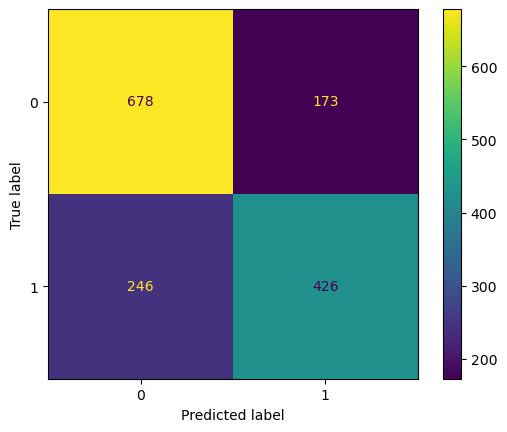

              precision    recall  f1-score   support

           0      0.734     0.797     0.764       851
           1      0.711     0.634     0.670       672

    accuracy                          0.725      1523
   macro avg      0.722     0.715     0.717      1523
weighted avg      0.724     0.725     0.723      1523



In [80]:
#Confusion matrix XGB_TI13
cm=confusion_matrix(y_test_TI13, predictions_TI13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI13, predictions_TI13, digits=3))

**Gaussian Naive Bayes (GNB)**

In [81]:
#Countvectorize, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
    priors = None # Use default priors

    #Define the GNB model with the hyperparameters
    gnb_V12 = GaussianNB(priors=priors, var_smoothing=var_smoothing)

    # #Scale the data using MinMaxScaler
    # scaler = MinMaxScaler()
    # X_train_V12_scaled = scaler.fit_transform(X_train_V12)
    # #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(gnb_V12, X_train_V12, y_train_V12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_V12 = optuna.create_study(direction="maximize", study_name="GNB_CV12")
study_V12.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params GNB_CV12: {}".format(study_V12.best_params))
print("\nBest Accuracy GNB_CV12: {}".format(study_V12.best_value))


#Train the XGB model with the optimized hyperparameters
best_params_V12 = study_V12.best_params
gnb_V12 = GaussianNB(**best_params_V12)
#scaler = MinMaxScaler()
#X_train_V12_scaled = scaler.fit_transform(X_train_V12)
gnb_V12.fit(X_train_V12, y_train_V12)


#Evaluate the performance of the model on the testing set
#X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_V12 = gnb_V12.predict(X_test_V12)

[I 2023-05-30 12:44:33,794] A new study created in memory with name: GNB_CV12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:44:48,611] Trial 2 finished with value: 0.6203612479474548 and parameters: {'var_smoothing': 0.003784019203441529}. Best is trial 2 with value: 0.6203612479474548.
[I 2023-05-30 12:44:48,672] Trial 12 finished with value: 0.4625615763546798 and parameters: {'var_smoothing': 1.182318934040877e-10}. Best is trial 2 with value: 0.6203612479474548.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:44:49,456] Trial 1 finished with value: 0.6321839080459769 and parameters: {'var_smoothing': 0.00015129241655038287}. Best is trial 1 with value: 0.6321839080459769.
[I 2023-05-30 12:44:49,480] Trial 8 finished with value: 0.47553366174055833 and parameters: {'var_smoothing': 5.575470868466851e-09}. Best is trial 1 with value: 0.6321839080459769.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:44:49,593] Trial 13 finished with value: 0.4832512315270936 and parameters: {'var_smoothing': 1.1804898137196984e-06}. Best is trial 1 with value: 0.6321839080459769.
[I 2023-05-30 12:44:49,610] Trial 7 finished with value: 0.606568144499179 and parameters: {'var_smoothing': 0.015176062181214341}. Best is trial 1 with value: 0.6321839080459769.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:44:49,656] Trial 10 finished with value: 0.6330049261083743 and parameters: {'var_smoothing': 0.0003562060551428092}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:44:49,738] Trial 4 finished with value: 0.4878489326765189 and parameters: {'var_smoothing': 5.74189262856114e-06}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:44:49,809] Trial 9 finished with value: 0.4688013136288999 and parameters: {'var_smoothing': 9.158856929308231e-10}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:44:49,959] Trial 6 finished with value: 0.59064039408867 and parameters: {'var_smoothing': 0.03180512786451157}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:44:50,018] Trial 0 finished with value: 0.47471264367816096 and parameters: {'var_smoothing': 1.2877733477098248e-08}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:44:50,059] Trial 11 finished with value: 0.49244663382594417 and parameters: {'var_smoothing': 9.853903881947266e-06}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:44:50,126] Trial 5 finished with value: 0.47569786535303776 and parameters: {'var_smoothing': 5.987815738053953e-09}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:44:50,141] Trial 15 finished with value: 0.5075533661740558 and parameters: {'var_smoothing': 1.3873072744426325e-05}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:44:50,145] Trial 3 finished with value: 0.4668308702791461 and parameters: {'var_smoothing': 6.618045498063867e-10}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:44:50,294] Trial 14 finished with value: 0.5752052545155993 and parameters: {'var_smoothing': 0.061913041567077866}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:45:00,395] Trial 17 finished with value: 0.4807881773399014 and parameters: {'var_smoothing': 7.803919464759019e-08}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:45:00,804] Trial 18 finished with value: 0.4835796387520526 and parameters: {'var_smoothing': 1.0917339844202873e-06}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:01,020] Trial 19 finished with value: 0.48489326765188834 and parameters: {'var_smoothing': 3.3463687680930195e-07}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:01,081] Trial 16 finished with value: 0.47307060755336616 and parameters: {'var_smoothing': 2.1113748063686002e-09}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:45:01,111] Trial 22 finished with value: 0.6328407224958948 and parameters: {'var_smoothing': 0.0004934225313497523}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:01,577] Trial 23 finished with value: 0.631855500821018 and parameters: {'var_smoothing': 0.0006875515542150146}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:01,603] Trial 21 finished with value: 0.6321839080459769 and parameters: {'var_smoothing': 0.00018361982644992224}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:45:02,878] Trial 20 finished with value: 0.6313628899835797 and parameters: {'var_smoothing': 0.0002840780190534721}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:02,931] Trial 27 finished with value: 0.6321839080459769 and parameters: {'var_smoothing': 0.0005319402892386926}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:02,998] Trial 25 finished with value: 0.632183908045977 and parameters: {'var_smoothing': 0.0005521838179089495}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:45:03,019] Trial 24 finished with value: 0.631855500821018 and parameters: {'var_smoothing': 0.0006082613402235515}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:03,220] Trial 26 finished with value: 0.632512315270936 and parameters: {'var_smoothing': 0.00038377962572168204}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:03,396] Trial 28 finished with value: 0.6328407224958948 and parameters: {'var_smoothing': 0.0004965501525937229}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:45:04,074] Trial 29 finished with value: 0.6307060755336618 and parameters: {'var_smoothing': 0.0008913928806176422}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:04,298] Trial 30 finished with value: 0.6323481116584565 and parameters: {'var_smoothing': 0.0005826718951103131}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:45:04,446] Trial 31 finished with value: 0.6321839080459769 and parameters: {'var_smoothing': 0.0005409218375785203}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:12,064] Trial 32 finished with value: 0.6323481116584565 and parameters: {'var_smoothing': 0.0005812794165564644}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:45:13,142] Trial 33 finished with value: 0.632512315270936 and parameters: {'var_smoothing': 0.0003774959317426305}. Best is trial 10 with value: 0.6330049261083743.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\2786451588.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:45:13,253] Trial 35 finished with value: 0.6328407224958948 and parameters: {'var_smoothing': 0.00015550079865860668}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:14,063] Trial 34 finished with value: 0.6323481116584565 and parameters: {'var_smoothing': 0.00019215341343172037}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:15,413] Trial 36 finished with value: 0.6259441707717569 and parameters: {'var_smoothing': 0.00010152543510546876}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:15,461] Trial 37 finished with value: 0.6236453201970443 and parameters: {'var_smoothing': 8.888165903544231e-05}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:16,071] Trial 40 finished with value: 0.555008210180624 and parameters: {'var_smoothing': 2.7577180187265757e-05}. Best is trial 10 with value: 0.6330049261083743.
[I 2023-05-30 12:45:16,373] Trial 38 finished with value: 0.6243021346469622 

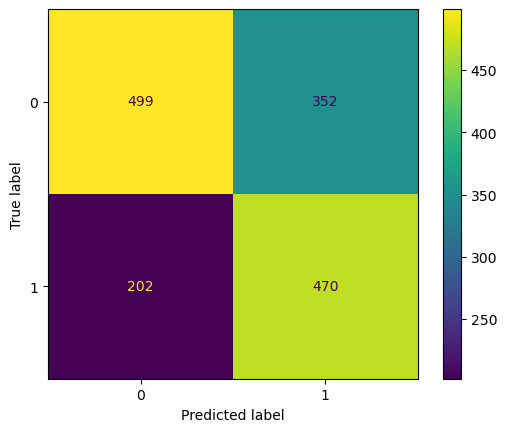

              precision    recall  f1-score   support

           0      0.712     0.586     0.643       851
           1      0.572     0.699     0.629       672

    accuracy                          0.636      1523
   macro avg      0.642     0.643     0.636      1523
weighted avg      0.650     0.636     0.637      1523



In [82]:
#Confusion matrix GNB_CV12
cm=confusion_matrix(y_test_V12, predictions_V12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V12, predictions_V12, digits=3))

In [83]:
#Countvectorize, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
    priors = None # Use default priors

    #Define the GNB model with the hyperparameters
    gnb_V13 = GaussianNB(priors=priors, var_smoothing=var_smoothing)

    # #Scale the data using MinMaxScaler
    # scaler = MinMaxScaler()
    # X_train_V12_scaled = scaler.fit_transform(X_train_V12)
    # #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(gnb_V13, X_train_V13, y_train_V13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_V13 = optuna.create_study(direction="maximize", study_name="GNB_CV13")
study_V13.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params GNB_CV13: {}".format(study_V13.best_params))
print("\nBest Accuracy GNB_CV13: {}".format(study_V13.best_value))


#Train the XGB model with the optimized hyperparameters
best_params_V13 = study_V13.best_params
gnb_V13 = GaussianNB(**best_params_V13)
#scaler = MinMaxScaler()
#X_train_V12_scaled = scaler.fit_transform(X_train_V12)
gnb_V13.fit(X_train_V13, y_train_V13)


#Evaluate the performance of the model on the testing set
#X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_V13 = gnb_V13.predict(X_test_V13)

[I 2023-05-30 12:50:13,218] A new study created in memory with name: GNB_CV13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:50:34,433] Trial 6 finished with value: 0.48275862068965514 and parameters: {'var_smoothing': 7.031522183627254e-07}. Best is trial 6 with value: 0.48275862068965514.
[I 2023-05-30 12:50:34,698] Trial 2 finished with value: 0.5733990147783251 and parameters: {'var_smoothing': 0.06491029621011264}. Best is trial 2 with value: 0.5733990147783251.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:50:34,888] Trial 5 finished with value: 0.6174055829228242 and parameters: {'var_smoothing': 0.0053699219066331684}. Best is trial 5 with value: 0.6174055829228242.
[I 2023-05-30 12:50:35,095] Trial 4 finished with value: 0.6131362889983579 and parameters: {'var_smoothing': 0.00878594166482702}. Best is trial 5 with value: 0.6174055829228242.
[I 2023-05-30 12:50:35,474] Trial 8 finished with value: 0.4766830870279146 and parameters: {'var_smoothing': 7.433192591892749e-08}. Best is trial 5 with value: 0.6174055829228242.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:50:35,812] Trial 10 finished with value: 0.6060755336617405 and parameters: {'var_smoothing': 0.015278134613401637}. Best is trial 5 with value: 0.6174055829228242.
[I 2023-05-30 12:50:35,840] Trial 1 finished with value: 0.6323481116584565 and parameters: {'var_smoothing': 0.00042038192943476293}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:35,927] Trial 0 finished with value: 0.600328407224959 and parameters: {'var_smoothing': 0.024540479605103725}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:50:36,120] Trial 9 finished with value: 0.47126436781609193 and parameters: {'var_smoothing': 3.6645036901114113e-09}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:36,152] Trial 13 finished with value: 0.6123152709359606 and parameters: {'var_smoothing': 0.010173916683811427}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:50:36,215] Trial 15 finished with value: 0.6285714285714287 and parameters: {'var_smoothing': 0.001458220154963223}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:36,216] Trial 12 finished with value: 0.6323481116584565 and parameters: {'var_smoothing': 0.0004467413099308043}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:36,249] Trial 14 finished with value: 0.6308702791461412 and parameters: {'var_smoothing': 0.0006699469061262623}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:50:36,446] Trial 7 finished with value: 0.6149425287356322 and parameters: {'var_smoothing': 0.007150027801722537}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:36,571] Trial 3 finished with value: 0.4794745484400657 and parameters: {'var_smoothing': 1.7990728014736818e-07}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:50:36,646] Trial 11 finished with value: 0.4789819376026273 and parameters: {'var_smoothing': 1.3297373303880202e-07}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:50:48,589] Trial 18 finished with value: 0.5573070607553366 and parameters: {'var_smoothing': 3.0157365141450245e-05}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:48,874] Trial 16 finished with value: 0.5752052545155993 and parameters: {'var_smoothing': 0.06076614292047706}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:50:49,868] Trial 19 finished with value: 0.46633825944170776 and parameters: {'var_smoothing': 1.0520243548463228e-09}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:50,085] Trial 17 finished with value: 0.5403940886699508 and parameters: {'var_smoothing': 2.5360478400341698e-05}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:50:51,337] Trial 20 finished with value: 0.6123152709359606 and parameters: {'var_smoothing': 0.010192312854181255}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:50:51,965] Trial 21 finished with value: 0.6141215106732348 and parameters: {'var_smoothing': 8.130939537600543e-05}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:52,087] Trial 22 finished with value: 0.6082101806239737 and parameters: {'var_smoothing': 7.349971109333508e-05}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:50:52,088] Trial 24 finished with value: 0.5875205254515599 and parameters: {'var_smoothing': 5.1985811423938855e-05}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:52,129] Trial 23 finished with value: 0.5942528735632184 and parameters: {'var_smoothing': 5.797214163485841e-05}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:50:52,960] Trial 25 finished with value: 0.5848932676518884 and parameters: {'var_smoothing': 4.945936693257463e-05}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:53,111] Trial 30 finished with value: 0.5773399014778325 and parameters: {'var_smoothing': 4.2262141487306235e-05}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:53,113] Trial 29 finished with value: 0.6197044334975369 and parameters: {'var_smoothing': 9.10535198249554e-05}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:50:53,320] Trial 28 finished with value: 0.6041050903119869 and parameters: {'var_smoothing': 6.929558303805678e-05}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:53,453] Trial 31 finished with value: 0.5903119868637109 and parameters: {'var_smoothing': 5.4710233041948114e-05}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:50:53,474] Trial 27 finished with value: 0.6178981937602627 and parameters: {'var_smoothing': 8.524439291117591e-05}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:50:54,014] Trial 26 finished with value: 0.610673234811166 and parameters: {'var_smoothing': 7.699215775202932e-05}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:51:03,486] Trial 33 finished with value: 0.5773399014778325 and parameters: {'var_smoothing': 4.226571946562986e-05}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:51:03,566] Trial 32 finished with value: 0.6308702791461412 and parameters: {'var_smoothing': 0.00014716509813451098}. Best is trial 1 with value: 0.6323481116584565.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\4268960590.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:51:04,270] Trial 34 finished with value: 0.616584564860427 and parameters: {'var_smoothing': 8.351086023111462e-05}. Best is trial 1 with value: 0.6323481116584565.
[I 2023-05-30 12:51:05,219] Trial 36 finished with value: 0.632840722495895 and parameters: {'var_smoothing': 0.00037846953905747795}. Best is trial 36 with value: 0.632840722495895.
[I 2023-05-30 12:51:05,549] Trial 35 finished with value: 0.6326765188834154 and parameters: {'var_smoothing': 0.0002710976536728071}. Best is trial 36 with value: 0.632840722495895.
[I 2023-05-30 12:51:07,707] Trial 38 finished with value: 0.632512315270936 and parameters: {'var_smoothing': 0.0004234084637483224}. Best is trial 36 with value: 0.632840722495895.
[I 2023-05-30 12:51:07,842] Trial 37 finished with value: 0.6323481116584564 and parameters: {'var_smoothing': 0.00039523004497398005}. Best is trial 36 with value: 0.632840722495895.
[I 2023-05-30 12:51:08,322] Trial 41 finished with value: 0.6302134646962234 and param

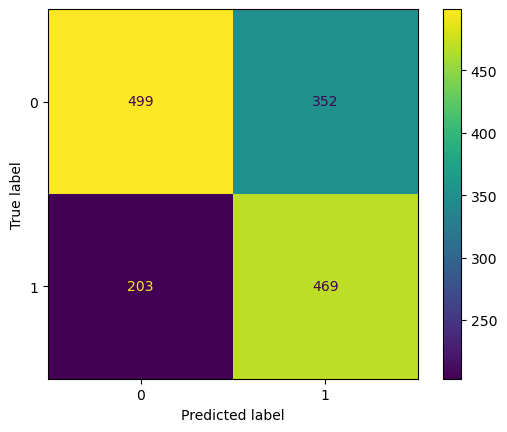

              precision    recall  f1-score   support

           0      0.711     0.586     0.643       851
           1      0.571     0.698     0.628       672

    accuracy                          0.636      1523
   macro avg      0.641     0.642     0.635      1523
weighted avg      0.649     0.636     0.636      1523



In [84]:
#Confusion matrix GNB_CV13
cm=confusion_matrix(y_test_V13, predictions_V13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V13, predictions_V13, digits=3))

In [85]:
#TF-IDF Vectorizer, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
    priors = None # Use default priors

    #Define the GNB model with the hyperparameters
    gnb_TI12 = GaussianNB(priors=priors, var_smoothing=var_smoothing)

    # #Scale the data using MinMaxScaler
    # scaler = MinMaxScaler()
    # X_train_V12_scaled = scaler.fit_transform(X_train_V12)
    # #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(gnb_TI12, X_train_TI12, y_train_TI12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_TI12 = optuna.create_study(direction="maximize", study_name="GNB_TI12")
study_TI12.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params GNB_TI12: {}".format(study_TI12.best_params))
print("\nBest Accuracy GNB_TI12: {}".format(study_TI12.best_value))


#Train the XGB model with the optimized hyperparameters
best_params_TI12 = study_TI12.best_params
gnb_TI12 = GaussianNB(**best_params_TI12)
#scaler = MinMaxScaler()
#X_train_V12_scaled = scaler.fit_transform(X_train_V12)
gnb_TI12.fit(X_train_TI12, y_train_TI12)


#Evaluate the performance of the model on the testing set
#X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_TI12 = gnb_TI12.predict(X_test_TI12)

[I 2023-05-30 12:55:36,583] A new study created in memory with name: GNB_TI12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:55:49,474] Trial 6 finished with value: 0.6326765188834155 and parameters: {'var_smoothing': 0.0007766717718664329}. Best is trial 6 with value: 0.6326765188834155.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:55:49,807] Trial 0 finished with value: 0.6103448275862069 and parameters: {'var_smoothing': 0.01283921336466987}. Best is trial 6 with value: 0.6326765188834155.
[I 2023-05-30 12:55:50,022] Trial 3 finished with value: 0.5668308702791462 and parameters: {'var_smoothing': 0.09434580653858557}. Best is trial 6 with value: 0.6326765188834155.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:55:50,052] Trial 1 finished with value: 0.6371100164203612 and parameters: {'var_smoothing': 0.0004212578076084774}. Best is trial 1 with value: 0.6371100164203612.
[I 2023-05-30 12:55:50,171] Trial 5 finished with value: 0.6106732348111658 and parameters: {'var_smoothing': 0.012460028349767444}. Best is trial 1 with value: 0.6371100164203612.
[I 2023-05-30 12:55:50,195] Trial 8 finished with value: 0.48407224958949097 and parameters: {'var_smoothing': 2.7901327045859073e-09}. Best is trial 1 with value: 0.6371100164203612.
[I 2023-05-30 12:55:50,283] Trial 7 finished with value: 0.48949096880131365 and parameters: {'var_smoothing': 2.296938567228255e-08}. Best is trial 1 with value: 0.6371100164203612.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:55:50,385] Trial 12 finished with value: 0.6310344827586206 and parameters: {'var_smoothing': 0.0011440758089556046}. Best is trial 1 with value: 0.6371100164203612.
[I 2023-05-30 12:55:50,902] Trial 2 finished with value: 0.6417077175697865 and parameters: {'var_smoothing': 0.0002827200711899546}. Best is trial 2 with value: 0.6417077175697865.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:55:50,948] Trial 10 finished with value: 0.6651888341543514 and parameters: {'var_smoothing': 6.357500045094999e-05}. Best is trial 10 with value: 0.6651888341543514.
[I 2023-05-30 12:55:50,978] Trial 11 finished with value: 0.6182266009852218 and parameters: {'var_smoothing': 0.00607106411834981}. Best is trial 10 with value: 0.6651888341543514.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:55:51,075] Trial 4 finished with value: 0.6349753694581282 and parameters: {'var_smoothing': 0.0004826985772683467}. Best is trial 10 with value: 0.6651888341543514.
[I 2023-05-30 12:55:51,101] Trial 15 finished with value: 0.5476190476190477 and parameters: {'var_smoothing': 3.911090031058638e-06}. Best is trial 10 with value: 0.6651888341543514.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:55:51,140] Trial 14 finished with value: 0.541871921182266 and parameters: {'var_smoothing': 3.516662946457565e-06}. Best is trial 10 with value: 0.6651888341543514.
[I 2023-05-30 12:55:51,229] Trial 9 finished with value: 0.5760262725779968 and parameters: {'var_smoothing': 0.056543479630500645}. Best is trial 10 with value: 0.6651888341543514.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:55:51,358] Trial 13 finished with value: 0.48653530377668314 and parameters: {'var_smoothing': 5.099786121252169e-07}. Best is trial 10 with value: 0.6651888341543514.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:56:01,951] Trial 16 finished with value: 0.4789819376026273 and parameters: {'var_smoothing': 3.6996616203542273e-10}. Best is trial 10 with value: 0.6651888341543514.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:56:02,263] Trial 19 finished with value: 0.6206896551724137 and parameters: {'var_smoothing': 0.0037912392398936983}. Best is trial 10 with value: 0.6651888341543514.
[I 2023-05-30 12:56:02,594] Trial 20 finished with value: 0.4789819376026273 and parameters: {'var_smoothing': 3.7312367930814273e-10}. Best is trial 10 with value: 0.6651888341543514.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:56:02,609] Trial 17 finished with value: 0.6124794745484401 and parameters: {'var_smoothing': 0.01014239626985931}. Best is trial 10 with value: 0.6651888341543514.
[I 2023-05-30 12:56:02,981] Trial 18 finished with value: 0.4873563218390805 and parameters: {'var_smoothing': 4.885887681984331e-09}. Best is trial 10 with value: 0.6651888341543514.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:56:03,511] Trial 21 finished with value: 0.5692939244663382 and parameters: {'var_smoothing': 0.07858780249927091}. Best is trial 10 with value: 0.6651888341543514.
[I 2023-05-30 12:56:03,932] Trial 24 finished with value: 0.6697865353037766 and parameters: {'var_smoothing': 2.5191705112625412e-05}. Best is trial 24 with value: 0.6697865353037766.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:56:04,376] Trial 22 finished with value: 0.6551724137931035 and parameters: {'var_smoothing': 1.3257051365302818e-05}. Best is trial 24 with value: 0.6697865353037766.
[I 2023-05-30 12:56:04,460] Trial 23 finished with value: 0.6661740558292282 and parameters: {'var_smoothing': 1.8728872724013775e-05}. Best is trial 24 with value: 0.6697865353037766.
[I 2023-05-30 12:56:04,506] Trial 25 finished with value: 0.6697865353037767 and parameters: {'var_smoothing': 4.551737022037486e-05}. Best is trial 25 with value: 0.6697865353037767.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inste

[I 2023-05-30 12:56:04,632] Trial 28 finished with value: 0.6706075533661741 and parameters: {'var_smoothing': 4.363853409934055e-05}. Best is trial 28 with value: 0.6706075533661741.
[I 2023-05-30 12:56:04,659] Trial 27 finished with value: 0.6702791461412152 and parameters: {'var_smoothing': 2.352136924125698e-05}. Best is trial 28 with value: 0.6706075533661741.
[I 2023-05-30 12:56:04,833] Trial 26 finished with value: 0.6707717569786535 and parameters: {'var_smoothing': 4.353424966808485e-05}. Best is trial 26 with value: 0.6707717569786535.
[I 2023-05-30 12:56:05,071] Trial 29 finished with value: 0.6688013136288997 and parameters: {'var_smoothing': 5.084833214400643e-05}. Best is trial 26 with value: 0.6707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:56:05,610] Trial 30 finished with value: 0.6702791461412152 and parameters: {'var_smoothing': 4.051926623895304e-05}. Best is trial 26 with value: 0.6707717569786535.
[I 2023-05-30 12:56:05,653] Trial 31 finished with value: 0.6697865353037766 and parameters: {'var_smoothing': 4.62131262822613e-05}. Best is trial 26 with value: 0.6707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:56:14,582] Trial 32 finished with value: 0.6681444991789819 and parameters: {'var_smoothing': 2.863459888205206e-05}. Best is trial 26 with value: 0.6707717569786535.
[I 2023-05-30 12:56:14,688] Trial 34 finished with value: 0.6648604269293925 and parameters: {'var_smoothing': 6.477953051361581e-05}. Best is trial 26 with value: 0.6707717569786535.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\3975220566.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:56:14,763] Trial 33 finished with value: 0.6707717569786535 and parameters: {'var_smoothing': 4.290658086841915e-05}. Best is trial 26 with value: 0.6707717569786535.
[I 2023-05-30 12:56:15,261] Trial 36 finished with value: 0.6707717569786535 and parameters: {'var_smoothing': 3.618106465797721e-05}. Best is trial 26 with value: 0.6707717569786535.
[I 2023-05-30 12:56:15,885] Trial 35 finished with value: 0.6605911330049261 and parameters: {'var_smoothing': 7.995399941838277e-05}. Best is trial 26 with value: 0.6707717569786535.
[I 2023-05-30 12:56:17,317] Trial 37 finished with value: 0.6706075533661741 and parameters: {'var_smoothing': 4.26782919585235e-05}. Best is trial 26 with value: 0.6707717569786535.
[I 2023-05-30 12:56:17,460] Trial 38 finished with value: 0.665024630541872 and parameters: {'var_smoothing': 6.369820001929397e-05}. Best is trial 26 with value: 0.6707717569786535.
[I 2023-05-30 12:56:17,512] Trial 40 finished with value: 0.48998357963875205 and 

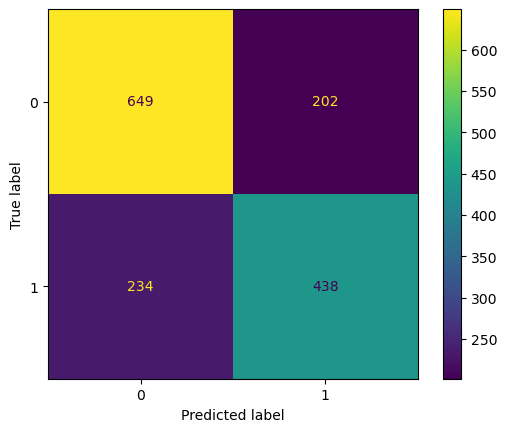

              precision    recall  f1-score   support

           0      0.735     0.763     0.749       851
           1      0.684     0.652     0.668       672

    accuracy                          0.714      1523
   macro avg      0.710     0.707     0.708      1523
weighted avg      0.713     0.714     0.713      1523



In [228]:
#Confusion matrix GNB_TI12
cm=confusion_matrix(y_test_TI12, predictions_TI12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI12, predictions_TI12, digits=3))

In [226]:
predicted_prob_TI12=gnb_TI12.predict_proba(X_test_TI12)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, auc, precision_recall_curve

classes = np.unique(y_test_TI12)
y_test_TI12_array = pd.get_dummies(y_test_TI12, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_TI12, predictions_TI12)

auc = roc_auc_score(y_test_TI12, predicted_prob_TI12[:,1], multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
#print("Detail:")
#print(classification_report(y_test_TI12, predictions_TI12))
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_TI12_array[:,i],  
                           predicted_prob_TI12[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              roc_auc_score(y_test_TI12_array[:, i], predicted_prob_TI12[:, i])))
               
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_TI12_array[:,i], predicted_prob_TI12[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  roc_auc_score(y_test_TI12_array[:, i], predicted_prob_TI12[:, i]))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [87]:
#TF-IDF Vectorizer, ngram_range=(1, 3)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
    priors = None # Use default priors

    #Define the GNB model with the hyperparameters
    gnb_TI13 = GaussianNB(priors=priors, var_smoothing=var_smoothing)

    # #Scale the data using MinMaxScaler
    # scaler = MinMaxScaler()
    # X_train_V12_scaled = scaler.fit_transform(X_train_V12)
    # #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(gnb_TI13, X_train_TI13, y_train_TI13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_TI13 = optuna.create_study(direction="maximize", study_name="GNB_TI13")
study_TI13.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params GNB_TI12: {}".format(study_TI13.best_params))
print("\nBest Accuracy GNB_TI12: {}".format(study_TI13.best_value))


#Train the XGB model with the optimized hyperparameters
best_params_TI13 = study_TI13.best_params
gnb_TI13 = GaussianNB(**best_params_TI13)
#scaler = MinMaxScaler()
#X_train_V12_scaled = scaler.fit_transform(X_train_V12)
gnb_TI13.fit(X_train_TI13, y_train_TI13)


#Evaluate the performance of the model on the testing set
#X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_TI13 = gnb_TI13.predict(X_test_TI13)

[I 2023-05-30 12:57:44,278] A new study created in memory with name: GNB_TI13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  

[I 2023-05-30 12:58:00,471] Trial 1 finished with value: 0.4870279146141215 and parameters: {'var_smoothing': 2.9527970931692144e-07}. Best is trial 1 with value: 0.4870279146141215.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:58:01,606] Trial 10 finished with value: 0.47454844006568137 and parameters: {'var_smoothing': 1.4675346756695784e-10}. Best is trial 1 with value: 0.4870279146141215.
[I 2023-05-30 12:58:01,668] Trial 4 finished with value: 0.625615763546798 and parameters: {'var_smoothing': 0.0024928920736369737}. Best is trial 4 with value: 0.625615763546798.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:58:02,379] Trial 11 finished with value: 0.4914614121510673 and parameters: {'var_smoothing': 1.6079287685312767e-07}. Best is trial 4 with value: 0.625615763546798.
[I 2023-05-30 12:58:02,694] Trial 8 finished with value: 0.6307060755336618 and parameters: {'var_smoothing': 0.0011922243350237479}. Best is trial 8 with value: 0.6307060755336618.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  

[I 2023-05-30 12:58:02,706] Trial 9 finished with value: 0.5441707717569787 and parameters: {'var_smoothing': 3.655400062214795e-06}. Best is trial 8 with value: 0.6307060755336618.
[I 2023-05-30 12:58:02,720] Trial 13 finished with value: 0.5009852216748769 and parameters: {'var_smoothing': 1.914353047280612e-06}. Best is trial 8 with value: 0.6307060755336618.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:58:02,913] Trial 3 finished with value: 0.490311986863711 and parameters: {'var_smoothing': 9.366397194326031e-09}. Best is trial 8 with value: 0.6307060755336618.
[I 2023-05-30 12:58:03,431] Trial 6 finished with value: 0.5628899835796387 and parameters: {'var_smoothing': 4.555653304524797e-06}. Best is trial 8 with value: 0.6307060755336618.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:58:03,459] Trial 0 finished with value: 0.47881773399014776 and parameters: {'var_smoothing': 7.308948469830264e-10}. Best is trial 8 with value: 0.6307060755336618.
[I 2023-05-30 12:58:03,585] Trial 14 finished with value: 0.4830870279146141 and parameters: {'var_smoothing': 3.09919017139288e-09}. Best is trial 8 with value: 0.6307060755336618.
[I 2023-05-30 12:58:03,668] Trial 15 finished with value: 0.6311986863711001 and parameters: {'var_smoothing': 0.0011300287942512298}. Best is trial 15 with value: 0.6311986863711001.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  

[I 2023-05-30 12:58:03,803] Trial 2 finished with value: 0.480623973727422 and parameters: {'var_smoothing': 1.851788769873575e-09}. Best is trial 15 with value: 0.6311986863711001.
[I 2023-05-30 12:58:03,975] Trial 5 finished with value: 0.5926108374384237 and parameters: {'var_smoothing': 0.029643183691668667}. Best is trial 15 with value: 0.6311986863711001.
[I 2023-05-30 12:58:05,259] Trial 7 finished with value: 0.4917898193760263 and parameters: {'var_smoothing': 1.326292411413626e-07}. Best is trial 15 with value: 0.6311986863711001.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:58:05,711] Trial 12 finished with value: 0.6527093596059114 and parameters: {'var_smoothing': 0.000123193913668996}. Best is trial 12 with value: 0.6527093596059114.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:58:16,064] Trial 18 finished with value: 0.4816091954022988 and parameters: {'var_smoothing': 2.5545656222657624e-09}. Best is trial 12 with value: 0.6527093596059114.
[I 2023-05-30 12:58:16,328] Trial 16 finished with value: 0.629064039408867 and parameters: {'var_smoothing': 0.0012891449363035044}. Best is trial 12 with value: 0.6527093596059114.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:58:16,936] Trial 19 finished with value: 0.4789819376026273 and parameters: {'var_smoothing': 8.154657552127824e-10}. Best is trial 12 with value: 0.6527093596059114.
[I 2023-05-30 12:58:17,227] Trial 17 finished with value: 0.47816091954022993 and parameters: {'var_smoothing': 6.271002358970718e-10}. Best is trial 12 with value: 0.6527093596059114.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  

[I 2023-05-30 12:58:17,341] Trial 21 finished with value: 0.5702791461412151 and parameters: {'var_smoothing': 0.07099184039892487}. Best is trial 12 with value: 0.6527093596059114.
[I 2023-05-30 12:58:17,860] Trial 26 finished with value: 0.6376026272577997 and parameters: {'var_smoothing': 0.0004108334884534675}. Best is trial 12 with value: 0.6527093596059114.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  

[I 2023-05-30 12:58:18,444] Trial 28 finished with value: 0.6397372742200329 and parameters: {'var_smoothing': 0.0003315327115962188}. Best is trial 12 with value: 0.6527093596059114.
[I 2023-05-30 12:58:18,457] Trial 20 finished with value: 0.48949096880131365 and parameters: {'var_smoothing': 1.922278482985693e-07}. Best is trial 12 with value: 0.6527093596059114.
[I 2023-05-30 12:58:18,735] Trial 24 finished with value: 0.6106732348111658 and parameters: {'var_smoothing': 0.012431565845533218}. Best is trial 12 with value: 0.6527093596059114.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:58:18,855] Trial 23 finished with value: 0.5760262725779967 and parameters: {'var_smoothing': 0.05889272746331226}. Best is trial 12 with value: 0.6527093596059114.
[I 2023-05-30 12:58:19,241] Trial 22 finished with value: 0.5665024630541872 and parameters: {'var_smoothing': 0.097391408494589}. Best is trial 12 with value: 0.6527093596059114.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:58:19,789] Trial 25 finished with value: 0.6157635467980296 and parameters: {'var_smoothing': 0.007370729137478464}. Best is trial 12 with value: 0.6527093596059114.
[I 2023-05-30 12:58:19,854] Trial 30 finished with value: 0.6535303776683088 and parameters: {'var_smoothing': 0.00011525723499136886}. Best is trial 30 with value: 0.6535303776683088.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  

[I 2023-05-30 12:58:19,875] Trial 29 finished with value: 0.6464696223316913 and parameters: {'var_smoothing': 0.00018426650338755176}. Best is trial 30 with value: 0.6535303776683088.
[I 2023-05-30 12:58:20,384] Trial 27 finished with value: 0.639080459770115 and parameters: {'var_smoothing': 0.0003708634304336613}. Best is trial 30 with value: 0.6535303776683088.
[I 2023-05-30 12:58:20,386] Trial 31 finished with value: 0.6474548440065682 and parameters: {'var_smoothing': 0.0001766733702866888}. Best is trial 30 with value: 0.6535303776683088.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:58:31,287] Trial 32 finished with value: 0.6535303776683088 and parameters: {'var_smoothing': 0.00011567704337501353}. Best is trial 30 with value: 0.6535303776683088.


C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
C:\Users\Iuliia\AppData\Local\Temp\ipykernel_27676\40902946.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)


[I 2023-05-30 12:58:32,964] Trial 34 finished with value: 0.651559934318555 and parameters: {'var_smoothing': 0.00013245939264327832}. Best is trial 30 with value: 0.6535303776683088.
[I 2023-05-30 12:58:32,971] Trial 33 finished with value: 0.660919540229885 and parameters: {'var_smoothing': 8.394909466338379e-05}. Best is trial 33 with value: 0.660919540229885.
[I 2023-05-30 12:58:33,832] Trial 36 finished with value: 0.6620689655172414 and parameters: {'var_smoothing': 7.719490697049626e-05}. Best is trial 36 with value: 0.6620689655172414.
[I 2023-05-30 12:58:33,969] Trial 35 finished with value: 0.6551724137931034 and parameters: {'var_smoothing': 0.0001078770187866616}. Best is trial 36 with value: 0.6620689655172414.
[I 2023-05-30 12:58:34,489] Trial 37 finished with value: 0.6607553366174056 and parameters: {'var_smoothing': 8.366910226878181e-05}. Best is trial 36 with value: 0.6620689655172414.
[I 2023-05-30 12:58:35,020] Trial 41 finished with value: 0.6484400656814451 and p

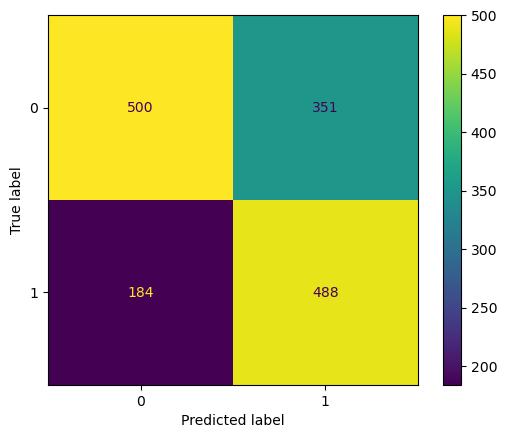

              precision    recall  f1-score   support

           0      0.731     0.588     0.651       851
           1      0.582     0.726     0.646       672

    accuracy                          0.649      1523
   macro avg      0.656     0.657     0.649      1523
weighted avg      0.665     0.649     0.649      1523



In [88]:
#Confusion matrix GNB_TI13
cm=confusion_matrix(y_test_TI13, predictions_TI13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI13, predictions_TI13, digits=3))

**DecisionTreeClassifier**

In [164]:
#Countvectorize, ngram_range=(1, 2)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
       
          
    }

    
    #Define the DT model with the hyperparameters
    dt_V12 = DecisionTreeClassifier(**params)

    #Scale the data using MinMaxScaler
    #scaler = MinMaxScaler()
    #X_train_V12_scaled = scaler.fit_transform(X_train_V12)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(dt_V12, X_train_V12, y_train_V12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_DTCV12 = optuna.create_study(direction="maximize", study_name="DT_CV12")
study_DTCV12.optimize(objective, n_trials=30, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params DT_CV12: {}".format(study_DTCV12.best_params))
print("\nBest Accuracy DT_CV12: {}".format(study_DTCV12.best_value))


#Train the DT model with the optimized hyperparameters
best_params_DTCV12 = study_DTCV12.best_params
dt_V12 = DecisionTreeClassifier(**best_params_DTCV12)
#scaler = MinMaxScaler()
#X_train_V12_scaled = scaler.fit_transform(X_train_V12)
dt_V12.fit(X_train_V12, y_train_V12)


#Evaluate the performance of the model on the testing set
#X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_DTCV12 = dt_V12.predict(X_test_V12)

[I 2023-05-30 17:06:44,175] A new study created in memory with name: DT_CV12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-05-30 17:06:52,353] Trial 6 finished with value: 0.5729064039408867 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 6 with value: 0.5729064039408867.
[I 2023-05-30 17:06:52,433] Trial 1 finished with value: 0.5735632183908046 and parameters: {'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5735632183908046.
[I 2023-05-30 17:06:52,456] Trial 4 finished with value: 0.5732348111658456 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.5735632183908046.
[I 2023-05-30 17:06:52,518] Trial 3 finished with value: 0.5732348111658456 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.5735632183908046.
[I 2023-05-30 17:06:53,118] Trial 2 finished with value: 0.5712643678160919 and par

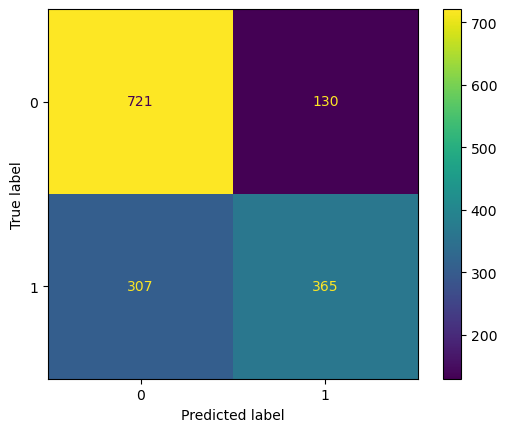

              precision    recall  f1-score   support

           0      0.701     0.847     0.767       851
           1      0.737     0.543     0.626       672

    accuracy                          0.713      1523
   macro avg      0.719     0.695     0.696      1523
weighted avg      0.717     0.713     0.705      1523



In [165]:
#Confusion matrix DT_CV12
cm=confusion_matrix(y_test_V12, predictions_DTCV12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V12, predictions_DTCV12, digits=3))

In [166]:
#Countvectorize, ngram_range=(1, 2) + scaler
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
       
          
    }

    
    #Define the DT model with the hyperparameters
    dt_V12_ = DecisionTreeClassifier(**params)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V12_scaled = scaler.fit_transform(X_train_V12)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(dt_V12_, X_train_V12_scaled, y_train_V12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_DTCV12_ = optuna.create_study(direction="maximize", study_name="DT_CV12_")
study_DTCV12_.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params DT_CV12_: {}".format(study_DTCV12_.best_params))
print("\nBest Accuracy DT_CV12_: {}".format(study_DTCV12_.best_value))


#Train the DT model with the optimized hyperparameters
best_params_DTCV12_ = study_DTCV12_.best_params
dt_V12_ = DecisionTreeClassifier(**best_params_DTCV12_)
scaler = MinMaxScaler()
X_train_V12_scaled = scaler.fit_transform(X_train_V12)
dt_V12_.fit(X_train_V12_scaled, y_train_V12)


#Evaluate the performance of the model on the testing set
X_test_V12_scaled = scaler.transform(X_test_V12)
predictions_DTCV12_ = dt_V12_.predict(X_test_V12_scaled)

[I 2023-05-30 17:12:32,241] A new study created in memory with name: DT_CV12_


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-05-30 17:12:36,188] Trial 3 finished with value: 0.5688013136288999 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 3 with value: 0.5688013136288999.
[I 2023-05-30 17:12:36,413] Trial 0 finished with value: 0.6091954022988506 and parameters: {'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6091954022988506.
[I 2023-05-30 17:12:36,502] Trial 4 finished with value: 0.5727422003284073 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.6091954022988506.
[I 2023-05-30 17:12:36,617] Trial 7 finished with value: 0.5724137931034482 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.6091954022988506.
[I 2023-05-30 17:12:36,812] Trial 2 finished with value: 0.5715927750410508 and para

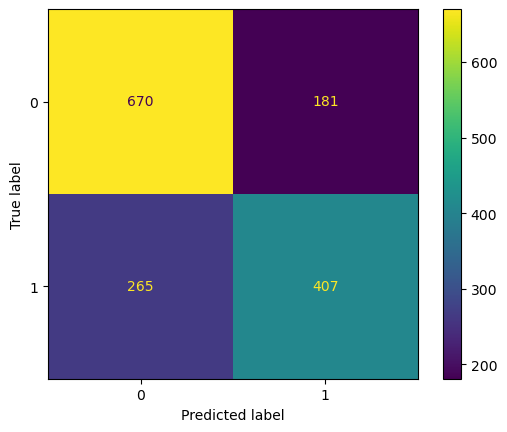

              precision    recall  f1-score   support

           0      0.717     0.787     0.750       851
           1      0.692     0.606     0.646       672

    accuracy                          0.707      1523
   macro avg      0.704     0.696     0.698      1523
weighted avg      0.706     0.707     0.704      1523



In [167]:
#Confusion matrix DT_CV12 + scaler
cm=confusion_matrix(y_test_V12, predictions_DTCV12_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V12, predictions_DTCV12_, digits=3))

In [168]:
#Countvectorize, ngram_range=(1, 3) + scaler
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
       
          
    }

    
    #Define the DT model with the hyperparameters
    dt_DTCV13 = DecisionTreeClassifier(**params)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_V13_scaled = scaler.fit_transform(X_train_V13)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(dt_DTCV13, X_train_V13_scaled, y_train_V13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_DTCV13 = optuna.create_study(direction="maximize", study_name="DT_CV13")
study_DTCV13.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params DT_CV13: {}".format(study_DTCV13.best_params))
print("\nBest Accuracy DT_CV13: {}".format(study_DTCV13.best_value))


#Train the DT model with the optimized hyperparameters
best_params_DTCV13 = study_DTCV13.best_params
dt_DTCV13 = DecisionTreeClassifier(**best_params_DTCV13)
scaler = MinMaxScaler()
X_train_V13_scaled = scaler.fit_transform(X_train_V13)
dt_DTCV13.fit(X_train_V13_scaled, y_train_V13)


#Evaluate the performance of the model on the testing set
X_test_V13_scaled = scaler.transform(X_test_V13)
predictions_DTCV13 = dt_DTCV13.predict(X_test_V13_scaled)

[I 2023-05-30 17:16:51,558] A new study created in memory with name: DT_CV13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-05-30 17:16:56,340] Trial 8 finished with value: 0.5699507389162562 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 8 with value: 0.5699507389162562.
[I 2023-05-30 17:16:56,625] Trial 12 finished with value: 0.580952380952381 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.580952380952381.
[I 2023-05-30 17:16:56,736] Trial 3 finished with value: 0.5712643678160919 and parameters: {'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 12 with value: 0.580952380952381.
[I 2023-05-30 17:16:56,765] Trial 15 finished with value: 0.5730706075533661 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 12 with value: 0.580952380952381.
[I 2023-05-30 17:16:56,894] Trial 4 finished with value: 0.5830870279146141 and par

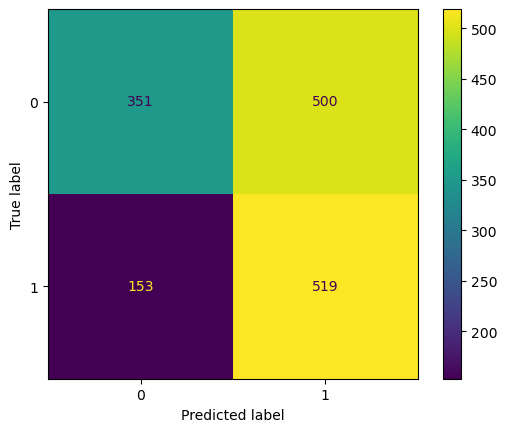

              precision    recall  f1-score   support

           0      0.696     0.412     0.518       851
           1      0.509     0.772     0.614       672

    accuracy                          0.571      1523
   macro avg      0.603     0.592     0.566      1523
weighted avg      0.614     0.571     0.560      1523



In [169]:
#Confusion matrix DT_CV13 + scaler
cm=confusion_matrix(y_test_V13, predictions_DTCV13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_V13, predictions_DTCV13, digits=3))

In [170]:
#TF-IDF Vectorizer, ngram_range=(1, 2) + scaler
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
       
          
    }

    
    #Define the DT model with the hyperparameters
    dt_TI12 = DecisionTreeClassifier(**params)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(dt_TI12, X_train_TI12_scaled, y_train_TI12, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_DTTI12 = optuna.create_study(direction="maximize", study_name="DT_TI12")
study_DTTI12.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params DT_TI12: {}".format(study_DTTI12.best_params))
print("\nBest Accuracy DT_TI12: {}".format(study_DTTI12.best_value))


#Train the DT model with the optimized hyperparameters
best_params_DTTI12 = study_DTTI12.best_params
dt_TI12 = DecisionTreeClassifier(**best_params_DTTI12)
scaler = MinMaxScaler()
X_train_TI12_scaled = scaler.fit_transform(X_train_TI12)
dt_TI12.fit(X_train_TI12_scaled, y_train_TI12)


#Evaluate the performance of the model on the testing set
X_test_TI12_scaled = scaler.transform(X_test_TI12)
predictions_DTTI12 = dt_TI12.predict(X_test_TI12_scaled)

[I 2023-05-30 17:24:50,465] A new study created in memory with name: DT_TI12


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-05-30 17:24:53,910] Trial 9 finished with value: 0.5724137931034482 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 9 with value: 0.5724137931034482.
[I 2023-05-30 17:24:54,220] Trial 7 finished with value: 0.573727422003284 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 7 with value: 0.573727422003284.
[I 2023-05-30 17:24:54,259] Trial 10 finished with value: 0.5722495894909688 and parameters: {'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 7 with value: 0.573727422003284.
[I 2023-05-30 17:24:54,299] Trial 5 finished with value: 0.6091954022988506 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.6091954022988506.
[I 2023-05-30 17:24:54,332] Trial 1 finished with value: 0.5722495894909688 and parame

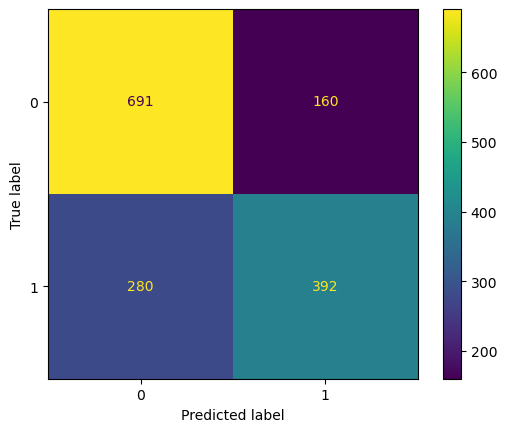

              precision    recall  f1-score   support

           0      0.712     0.812     0.759       851
           1      0.710     0.583     0.641       672

    accuracy                          0.711      1523
   macro avg      0.711     0.698     0.700      1523
weighted avg      0.711     0.711     0.706      1523



In [171]:
#Confusion matrix DT_TI12 + scaler
cm=confusion_matrix(y_test_TI12, predictions_DTTI12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI12, predictions_DTTI12, digits=3))

In [173]:
#TF-IDF Vectorizer, ngram_range=(1, 3) + scaler
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the hyperparameters to be optimized
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
       
          
    }

    
    #Define the DT model with the hyperparameters
    dt_TI13 = DecisionTreeClassifier(**params)

    #Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
    #X_test_scaled = scaler.transform(X_test_V12)

    # Perform kFold cross-validation and return the mean validation score
    scores = cross_val_score(dt_TI13, X_train_TI13_scaled, y_train_TI13, cv=kfold, scoring=scoring).mean()
    return scores

%time
#Run the optimization
study_DTTI13 = optuna.create_study(direction="maximize", study_name="DT_TI13")
study_DTTI13.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

#Print best parametrs
print("Best Params DT_TI13: {}".format(study_DTTI13.best_params))
print("\nBest Accuracy DT_TI13: {}".format(study_DTTI13.best_value))


#Train the DT model with the optimized hyperparameters
best_params_DTTI13 = study_DTTI13.best_params
dt_TI13 = DecisionTreeClassifier(**best_params_DTTI13)
scaler = MinMaxScaler()
X_train_TI13_scaled = scaler.fit_transform(X_train_TI13)
dt_TI13.fit(X_train_TI13_scaled, y_train_TI13)


#Evaluate the performance of the model on the testing set
X_test_TI13_scaled = scaler.transform(X_test_TI13)
predictions_DTTI13 = dt_TI13.predict(X_test_TI13_scaled)

[I 2023-05-30 17:30:05,305] A new study created in memory with name: DT_TI13


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\Iuliia\miniconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-05-30 17:30:09,066] Trial 1 finished with value: 0.5727422003284073 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.5727422003284073.
[I 2023-05-30 17:30:09,238] Trial 2 finished with value: 0.5717569786535304 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.5727422003284073.
[I 2023-05-30 17:30:09,313] Trial 0 finished with value: 0.5729064039408868 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.5729064039408868.
[I 2023-05-30 17:30:09,415] Trial 5 finished with value: 0.5729064039408867 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5729064039408868.
[I 2023-05-30 17:30:09,594] Trial 7 finished with value: 0.5701149425287356 and para

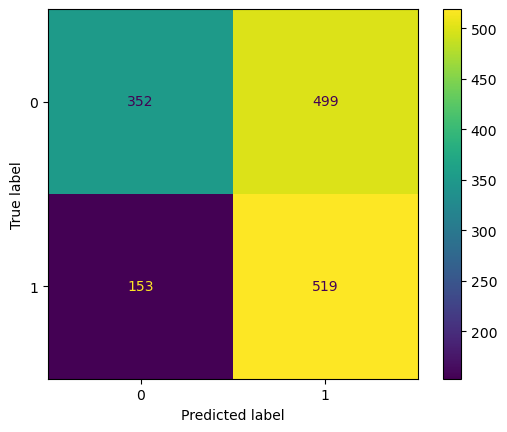

              precision    recall  f1-score   support

           0      0.697     0.414     0.519       851
           1      0.510     0.772     0.614       672

    accuracy                          0.572      1523
   macro avg      0.603     0.593     0.567      1523
weighted avg      0.614     0.572     0.561      1523



In [174]:
#Confusion matrix DT_TI13 + scaler
cm=confusion_matrix(y_test_TI13, predictions_DTTI13)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test_TI13, predictions_DTTI13, digits=3))